# Data preprocess

In [ ]:
import os, re, json, math, unicodedata, difflib, statistics
from pathlib import Path
from collections import defaultdict, Counter
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
BASE = Path("/content/drive/MyDrive/NLP/project")

JSON_PATH   = BASE / "json_files" / "normalized_data_final.json"
IMAGES_DIR  = BASE / "images"
OUT_DIR     = BASE / "reports/data_preprocess"
OUT_DIR.mkdir(parents=True, exist_ok=True)

In [ ]:
def load_json_list(path: Path):
    text = path.read_text(encoding="utf-8")
    text_s = text.strip()
    if not text_s:
        return []
    # Try parse as a list
    try:
        data = json.loads(text_s)
        if isinstance(data, list):
            return data
        elif isinstance(data, dict):
            # If single dict, wrap into a list
            return [data]
    except json.JSONDecodeError:
        pass
    # Fallback: JSON Lines
    out = []
    for line in text.splitlines():
        line = line.strip()
        if not line:
            continue
        try:
            out.append(json.loads(line))
        except json.JSONDecodeError:
            # Skip bad lines quietly
            continue
    return out

records = load_json_list(JSON_PATH)
df = pd.DataFrame(records)

In [ ]:
for col in ["name", "category", "summary"]:
    if col not in df.columns:
        df[col] = None

In [ ]:
ARABIC_DIAC_RANGE = (
    list(range(0x0610, 0x061A+1)) +  # Quranic annotations
    list(range(0x064B, 0x065F+1)) +  # Tashkeel
    list(range(0x06D6, 0x06DC+1)) +
    list(range(0x06DF, 0x06E8+1)) +
    list(range(0x06EA, 0x06ED+1))
)
ARABIC_DIAC = ''.join(chr(c) for c in ARABIC_DIAC_RANGE)

def strip_diacritics(s: str) -> str:
    return re.sub(f"[{re.escape(ARABIC_DIAC)}]", "", s)

def normalize_fa(s) -> str:
    if s is None:
        return ""
    s = str(s)
    # Replace Arabic Yeh/Kaf with Persian forms
    s = s.replace("ي", "ی").replace("ى", "ی").replace("ﻯ","ی").replace("ﻱ","ی")
    s = s.replace("ك", "ک")
    # Common arabic/persian digits -> remove digits entirely for matching
    s = re.sub(r"[0-9۰-۹]", " ", s)
    # Remove tatweel
    s = s.replace("ـ", "")
    # Replace underscores, hyphens with spaces
    s = s.replace("_", " ").replace("-", " ")
    # Replace ZWNJ with space
    s = s.replace("\u200c", " ")
    # Strip combining marks/diacritics
    s = strip_diacritics(s)
    # Normalize unicode (NFC)
    s = unicodedata.normalize("NFC", s)
    # Remove most punctuation, keep letters and spaces
    s = re.sub(r"[^\w\s\u0600-\u06FF]", " ", s, flags=re.UNICODE)
    # \w keeps underscore; we removed underscores already. Also remove leftover ASCII letters that are lone
    # Collapse whitespace
    s = re.sub(r"\s+", " ", s, flags=re.UNICODE).strip()
    return s

def simple_key(s: str) -> str:
    # final key for matching: normalized, lowercase, collapse spaces
    s = normalize_fa(s).lower()
    return re.sub(r"\s+", " ", s)

In [ ]:
def is_nonempty_text(x):
    if x is None:
        return False
    if isinstance(x, str):
        return len(x.strip()) > 0
    return False

df["summary_present"] = df["summary"].apply(is_nonempty_text)

In [ ]:
def text_len(s):
    if not is_nonempty_text(s):
        return 0
    # length in characters of normalized summary
    return len(normalize_fa(str(s)))

df["summary_len"]  = df["summary"].apply(text_len)
df["word_count"]   = df["summary"].apply(lambda s: len(normalize_fa(str(s)).split()) if is_nonempty_text(s) else 0)
df["name_key"]     = df["name"].apply(simple_key)
df["category"]     = df["category"].fillna("").astype(str)

In [ ]:
def agg_stats(sub: pd.DataFrame):
    total = len(sub)
    present = int(sub["summary_present"].sum())
    pct = (present / total * 100.0) if total else 0.0
    lengths = [l for l in sub["summary_len"].tolist() if l > 0]
    words   = [w for w in sub["word_count"].tolist() if w > 0]
    def safemean(v): return float(np.mean(v)) if v else 0.0
    def safemed(v): return float(np.median(v)) if v else 0.0
    def safeq(v, q): return float(np.quantile(v, q)) if v else 0.0
    return pd.Series({
        "records": total,
        "summary_present": present,
        "summary_present_%": round(pct, 2),
        "char_len_mean": round(safemean(lengths), 2),
        "char_len_median": round(safemed(lengths), 2),
        "char_len_p25": round(safeq(lengths, 0.25), 2),
        "char_len_p75": round(safeq(lengths, 0.75), 2),
        "word_count_mean": round(safemean(words), 2),
        "word_count_median": round(safemed(words), 2),
    })

summary_by_cat = df.groupby("category", dropna=False).apply(agg_stats).reset_index()
summary_overall = agg_stats(df)

/tmp/ipython-input-2801786406.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary_by_cat = df.groupby("category", dropna=False).apply(agg_stats).reset_index()


In [ ]:
print("=== SUMMARY FIELD — OVERALL ===")
display(pd.DataFrame([summary_overall]))
print("\n=== SUMMARY FIELD — BY CATEGORY ===")
display(summary_by_cat)

=== SUMMARY FIELD — OVERALL ===


records  summary_present  summary_present_%  char_len_mean  \
0   4092.0           4092.0              100.0         236.52   

   char_len_median  char_len_p25  char_len_p75  word_count_mean  \
0            207.0         125.0         310.0            47.24   

   word_count_median  
0               41.0


=== SUMMARY FIELD — BY CATEGORY ===


category  records  summary_present  summary_present_%  char_len_mean  \
0    art_music    468.0            468.0              100.0         310.78   
1      athlete   2329.0           2329.0              100.0         181.83   
2        poets    203.0            203.0              100.0         299.46   
3  politicians    981.0            981.0              100.0         308.49   
4   scientists    111.0            111.0              100.0         319.59   

   char_len_median  char_len_p25  char_len_p75  word_count_mean  \
0            266.5        174.75         374.0            66.23   
1            150.0         94.00         230.0            34.44   
2            297.0        161.50         396.0            62.01   
3            301.0        229.00         373.0            63.53   
4            338.0        180.00         425.5            64.98   

   word_count_median  
0               55.5  
1               29.0  
2               61.0  
3               62.0  
4               70.0

In [ ]:
summary_by_cat.to_csv(OUT_DIR / "summary_stats_by_category.csv", index=False)

In [ ]:
IMG_FOLDERS = {
    "politicians":    IMAGES_DIR / "politicians_images",
    "art_music":      IMAGES_DIR / "art_music_images",
    "poets":          IMAGES_DIR / "poets_images",
    "scientists":     IMAGES_DIR / "scientists_images",
    "athlete":        IMAGES_DIR / "athlete_images",
}

IMAGE_EXTS = {".jpg", ".jpeg", ".png", ".webp", ".bmp", ".tif", ".tiff"}

In [ ]:
PERSIAN_BLOCK = r"\u0600-\u06FF"
# longest contiguous run of Persian letters + space + ZWNJ + hyphen-like
NAME_RE = re.compile(rf"[{PERSIAN_BLOCK}\s\u200c\-]+", re.UNICODE)

def extract_candidate_non_athlete(fname_noext: str) -> str:
    """
    Try several strategies:
      - If there's a Persian segment after the last underscore, try that
      - Or before the first underscore
      - Otherwise: take the longest Persian segment anywhere
    """
    base = fname_noext
    parts = base.split("_")
    cands = []
    # After last underscore
    if "_" in base:
        tail = parts[-1]
        cands.append(tail)
        head = parts[0]
        cands.append(head)
    # All Persian-like segments
    for m in NAME_RE.finditer(base):
        seg = m.group(0)
        if seg and re.search(rf"[{PERSIAN_BLOCK}]", seg):
            cands.append(seg)

    # Pick the "best" candidate: longest normalized
    cands_norm = [(c, simple_key(c)) for c in cands if c]
    if not cands_norm:
        return simple_key(base)
    cands_norm.sort(key=lambda x: len(x[1]), reverse=True)
    return cands_norm[0][1]

ATHLETE_SUFFIXES = {"crawled", "image", "value", "img", "photo", "pic"}

def extract_candidate_athlete(fname_noext: str) -> str:
    """
    Pattern like: "<id>_<first>_<last>[_...]_<suffix>"
    We drop the first numeric id, drop trailing known suffix,
    join remaining name tokens with space, then normalize.
    Handles double underscores as empty tokens gracefully.
    """
    parts = fname_noext.split("_")
    # drop empty tokens
    parts = [p for p in parts if p != ""]
    if not parts:
        return simple_key(fname_noext)

    # Drop a leading pure-number token (ID)
    if re.fullmatch(r"\d+", parts[0]):
        parts = parts[1:] if len(parts) > 1 else parts

    # Drop trailing known suffix token if present
    if parts and parts[-1].lower() in ATHLETE_SUFFIXES:
        parts = parts[:-1] if len(parts) > 1 else parts

    name_raw = " ".join(parts)
    return simple_key(name_raw)

ARTMUSIC_START_NUMS = re.compile(r'^(\d+)_(\d+)_(?P<name>.+)$')     # A
ARTMUSIC_END_NUMS   = re.compile(r'^(?P<name>.+)_(\d+)_(\d+)$')     # B

def extract_candidate_art_music(fname_noext: str) -> str:
    m = ARTMUSIC_START_NUMS.match(fname_noext)
    if m:
        return simple_key(m.group("name"))
    m = ARTMUSIC_END_NUMS.match(fname_noext)
    if m:
        return simple_key(m.group("name"))
    return extract_candidate_non_athlete(fname_noext)

def scan_images():
    """
    Returns: dict[category] -> list of dicts:
      { 'path': Path, 'filename': str, 'key': normalized_name_key }
    """
    cat2images = {k: [] for k in IMG_FOLDERS.keys()}
    for cat, folder in IMG_FOLDERS.items():
        if not folder.exists():
            continue
        for p in folder.rglob("*"):
            if p.is_file() and p.suffix.lower() in IMAGE_EXTS:
                fname_noext = p.stem
                if cat == "athlete":
                    key = extract_candidate_athlete(fname_noext)
                elif cat == "art_music":
                    key = extract_candidate_art_music(fname_noext)
                else:
                    key = extract_candidate_non_athlete(fname_noext)
                cat2images[cat].append({
                    "path": p,
                    "filename": p.name,
                    "key": key
                })
    return cat2images

cat2images = scan_images()

In [ ]:
def token_jaccard(a: str, b: str) -> float:
    A = set(a.split())
    B = set(b.split())
    if not A and not B:
        return 1.0
    if not A or not B:
        return 0.0
    inter = len(A & B)
    union = len(A | B)
    return inter / union if union else 0.0

def char_trigram_jaccard(a: str, b: str) -> float:
    def ngrams(s, n=3):
        s2 = s.replace(" ", "")
        if len(s2) < n:
            return {s2} if s2 else set()
        return {s2[i:i+n] for i in range(len(s2)-n+1)}
    A = ngrams(a, 3)
    B = ngrams(b, 3)
    if not A and not B:
        return 1.0
    if not A or not B:
        return 0.0
    inter = len(A & B)
    union = len(A | B)
    return inter / union if union else 0.0

def seq_ratio(a: str, b: str) -> float:
    return difflib.SequenceMatcher(None, a, b).ratio()

def fuzzy_score(a: str, b: str) -> float:
    # Combine three simple signals; take the max (robust to minor formatting differences)
    return max(seq_ratio(a, b), token_jaccard(a, b), char_trigram_jaccard(a, b))

In [ ]:
cat_key_to_paths = {cat: defaultdict(list) for cat in IMG_FOLDERS.keys()}
for cat, items in cat2images.items():
    for it in items:
        cat_key_to_paths[cat][it["key"]].append(it["path"])

def find_best_images_for_record(name_key: str, category: str, threshold: float = 0.86, topk: int = 3):
    """
    1) Exact-key match -> return all exacts
    2) Otherwise compute fuzzy scores vs all images in category and keep top-k >= threshold
    Returns: list[(score, Path)]
    """
    images = cat2images.get(category, [])
    if not images:
        return []

    # Exact
    exacts = cat_key_to_paths[category].get(name_key)
    if exacts:
        return [(1.0, p) for p in exacts[:topk]]

    # Fuzzy
    scored = []
    for it in images:
        sc = fuzzy_score(name_key, it["key"])
        if sc >= threshold:
            scored.append((sc, it["path"]))
    scored.sort(key=lambda x: x[0], reverse=True)
    return scored[:topk]

In [ ]:
match_rows = []
for idx, row in df.iterrows():
    cat  = str(row.get("category", "") or "")
    name = row.get("name", "")
    key  = simple_key(name)
    best = find_best_images_for_record(key, cat, threshold=0.86, topk=5)
    match_rows.append({
        "row_index": idx,
        "name": name,
        "name_key": key,
        "category": cat,
        "summary_present": bool(row["summary_present"]),
        "summary_len": int(row["summary_len"]),
        "matches_found": len(best),
        "best_score": (best[0][0] if best else 0.0),
        "matched_files": " | ".join(str(p) for _, p in best)
    })

matches_df = pd.DataFrame(match_rows)

In [ ]:
def image_stats(df_in: pd.DataFrame):
    total = len(df_in)
    with_img = int((df_in["matches_found"] > 0).sum())
    pct = (with_img / total * 100.0) if total else 0.0
    best_scores = df_in["best_score"].tolist()
    def safemean(v): return float(np.mean(v)) if v else 0.0
    def safemed(v): return float(np.median(v)) if v else 0.0
    return pd.Series({
        "records": total,
        "records_with_images": with_img,
        "with_images_%": round(pct, 2),
        "best_score_mean": round(safemean(best_scores), 3),
        "best_score_median": round(safemed(best_scores), 3),
    })

images_by_cat = matches_df.groupby("category", dropna=False).apply(image_stats).reset_index()
images_overall = image_stats(matches_df)

print("\n=== IMAGE MATCH — OVERALL ===")
display(pd.DataFrame([images_overall]))
print("\n=== IMAGE MATCH — BY CATEGORY ===")
display(images_by_cat)


=== IMAGE MATCH — OVERALL ===


/tmp/ipython-input-2090354647.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  images_by_cat = matches_df.groupby("category", dropna=False).apply(image_stats).reset_index()


records  records_with_images  with_images_%  best_score_mean  \
0   4092.0               4039.0           98.7             0.98   

   best_score_median  
0                1.0


=== IMAGE MATCH — BY CATEGORY ===


category  records  records_with_images  with_images_%  best_score_mean  \
0    art_music    468.0                467.0          99.79            0.989   
1      athlete   2329.0               2277.0          97.77            0.970   
2        poets    203.0                203.0         100.00            0.995   
3  politicians    981.0                981.0         100.00            0.994   
4   scientists    111.0                111.0         100.00            0.997   

   best_score_median  
0                1.0  
1                1.0  
2                1.0  
3                1.0  
4                1.0

In [ ]:
matches_csv = OUT_DIR / "image_match_report.csv"
matches_df.to_csv(matches_csv, index=False)

images_by_cat.to_csv(OUT_DIR / "image_match_stats_by_category.csv", index=False)

In [ ]:
print("\n=== SAMPLE UNMATCHED (per category, up to 10 each) ===")
for cat, sub in matches_df[matches_df["matches_found"] == 0].groupby("category"):
    print(f"\n-- {cat} --")
    display(sub[["name", "name_key"]].head(10))

print("\nDone. Files written to:")
print(f" - {OUT_DIR/'summary_stats_by_category.csv'}")
print(f" - {OUT_DIR/'image_match_report.csv'}")
print(f" - {OUT_DIR/'image_match_stats_by_category.csv'}")


=== SAMPLE UNMATCHED (per category, up to 10 each) ===

-- art_music --


name       name_key
393  آیدین آغداشلو  آیدین آغداشلو


-- athlete --


name            name_key
474        آدریانو آلوز        آدریانو آلوز
501             آری هان             آری هان
516          آلکس آغاسی          آلکس آغاسی
521      آنتونیو سیموئز      آنتونیو سیموئز
525         آندره آغاسی         آندره آغاسی
534         آیدین ختائی         آیدین ختائی
660         البرز زارعی         البرز زارعی
661  البرز زارعی کوهسرک  البرز زارعی کوهسرک
681       امانوئل آغاسی       امانوئل آغاسی
722    امیرارسلان مطهری    امیرارسلان مطهری


Done. Files written to:
 - /content/drive/MyDrive/NLP/project/reports/data_preprocess/summary_stats_by_category.csv
 - /content/drive/MyDrive/NLP/project/reports/data_preprocess/image_match_report.csv
 - /content/drive/MyDrive/NLP/project/reports/data_preprocess/image_match_stats_by_category.csv


# Embedding process

In [ ]:
# Check GPU
!nvidia-smi

# Core libs (GPU-ready)
%pip -q install -U torch --index-url https://download.pytorch.org/whl/cu121
%pip -q install -U sentence-transformers open-clip-torch pillow tqdm huggingface_hub

# Index backends (FAISS preferred; hnswlib as fallback)
%pip -q install -U faiss-cpu hnswlib

Mon Sep 15 22:12:28 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   60C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import json, re, unicodedata, difflib

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pathlib import Path
BASE = Path("/content/drive/MyDrive/NLP/project")

In [ ]:
JSON_IN = BASE / "json_files/normalized_data.json"
IMAGES  = BASE / "images"
CAT2DIR = {
    "politicians":  IMAGES / "politicians_images",
    "art_music":    IMAGES / "art_music_images",
    "poets":        IMAGES / "poets_images",
    "scientists":   IMAGES / "scientists_images",
    "athlete":      IMAGES / "athlete_images",
}

OUT_DIR    = BASE / "rag_out"
OUT_DIR.mkdir(parents=True, exist_ok=True)

TEXT_INDEX = OUT_DIR / "faiss_text.idx"
IMG_INDEX  = OUT_DIR / "faiss_image.idx"
DOCS_MAP   = OUT_DIR / "docs.jsonl"

print("JSON exists:", JSON_IN.exists(), JSON_IN)
print("IMAGES exists:", IMAGES.exists(), IMAGES)
print("OUT_DIR:", OUT_DIR)

JSON exists: True /content/drive/MyDrive/NLP/project/json_files/normalized_data.json
IMAGES exists: True /content/drive/MyDrive/NLP/project/images
OUT_DIR: /content/drive/MyDrive/NLP/project/rag_out


In [ ]:
import json, re
from pathlib import Path
from PIL import Image

In [ ]:
def sanitize_filename(s: str) -> str:
    s = (str(s) or "").strip()
    s = re.sub(r"\s+", "_", s)
    s = re.sub(r"[^\w\-.]+", "", s)
    return s or "image"

def keep_priority_key(name: str) -> tuple:
    # _crawled > _imageN (lower N) > _image.<ext> > lexicographic
    m = re.search(r"_image(\d+)\b", name.lower())
    n = int(m.group(1)) if m else 10**9
    return (0 if "_crawled" in name.lower() else 1,
            n,
            0 if "_image." in name.lower() else 1,
            name.lower())

In [ ]:
def normalize_name_field(x):
    # For names: prefer the first non-empty string if list, else str() fallback
    if isinstance(x, list):
        for v in x:
            if isinstance(v, str) and v.strip():
                return v
        return ""  # no usable string
    if isinstance(x, str):
        return x
    if x is None:
        return ""
    return str(x)

def normalize_text_field(x):
    # For summaries/other text: join lists/dicts, else str() fallback
    if isinstance(x, str):
        return x
    if isinstance(x, list):
        parts = [v.strip() for v in x if isinstance(v, str) and v.strip()]
        return " | ".join(parts)
    if isinstance(x, dict):
        parts = []
        for v in x.values():
            s = normalize_text_field(v)
            if s:
                parts.append(s)
        return " | ".join(parts)
    if x is None:
        return ""
    return str(x)

In [ ]:
ARABIC_DIAC_RANGE = (
    list(range(0x0610, 0x061A+1)) +
    list(range(0x064B, 0x065F+1)) +
    list(range(0x06D6, 0x06DC+1)) +
    list(range(0x06DF, 0x06E8+1)) +
    list(range(0x06EA, 0x06ED+1))
)
ARABIC_DIAC = ''.join(chr(c) for c in ARABIC_DIAC_RANGE)

def strip_diacritics(s: str) -> str:
    return re.sub(f"[{re.escape(ARABIC_DIAC)}]", "", s)

def normalize_fa(s) -> str:
    if s is None: return ""
    s = str(s)
    s = s.replace("ي","ی").replace("ى","ی").replace("ﻯ","ی").replace("ﻱ","ی")
    s = s.replace("ك","ک")
    s = s.replace("ـ","")
    s = s.replace("_"," ").replace("-"," ")
    s = s.replace("\u200c"," ")
    s = strip_diacritics(s)
    s = unicodedata.normalize("NFC", s)
    s = re.sub(r"[0-9۰-۹]", " ", s)
    s = re.sub(r"[^\w\s\u0600-\u06FF]", " ", s, flags=re.UNICODE)
    s = re.sub(r"\s+"," ", s).strip()
    return s

def simple_key(s: str) -> str:
    return re.sub(r"\s+"," ", normalize_fa(s).lower())

In [ ]:
PERSIAN_BLOCK = r"\u0600-\u06FF"
NAME_RE = re.compile(rf"[{PERSIAN_BLOCK}\s\u200c\-]+", re.UNICODE)
ATHLETE_SUFFIXES = {"crawled", "image", "value", "img", "photo", "pic"}

def extract_candidate_non_athlete(fname_noext: str) -> str:
    parts = fname_noext.split("_")
    cands = []
    if "_" in fname_noext:
        cands += [parts[-1], parts[0]]
    for m in NAME_RE.finditer(fname_noext):
        seg = m.group(0)
        if seg and re.search(rf"[{PERSIAN_BLOCK}]", seg):
            cands.append(seg)
    cands_norm = [(c, simple_key(c)) for c in cands if c]
    if not cands_norm:
        return simple_key(fname_noext)
    cands_norm.sort(key=lambda x: len(x[1]), reverse=True)
    return cands_norm[0][1]

def extract_candidate_athlete(fname_noext: str) -> str:
    parts = [p for p in fname_noext.split("_") if p != ""]
    if not parts: return simple_key(fname_noext)
    if re.fullmatch(r"\d+", parts[0]):  # drop leading numeric id
        parts = parts[1:] if len(parts) > 1 else parts
    if parts and parts[-1].lower() in ATHLETE_SUFFIXES:  # drop trailing suffix
        parts = parts[:-1] if len(parts) > 1 else parts
    return simple_key(" ".join(parts))

ARTMUSIC_START_NUMS = re.compile(r'^(\d+)_(\d+)_(?P<name>.+)$')
ARTMUSIC_END_NUMS   = re.compile(r'^(?P<name>.+)_(\d+)_(\d+)$')

def extract_candidate_art_music(fname_noext: str) -> str:
    m = ARTMUSIC_START_NUMS.match(fname_noext)
    if m:
        return simple_key(m.group("name"))
    m = ARTMUSIC_END_NUMS.match(fname_noext)
    if m:
        return simple_key(m.group("name"))
    return extract_candidate_non_athlete(fname_noext)

def filename_key_for_category(cat: str, fname_noext: str) -> str:
    if cat == "athlete":
        return extract_candidate_athlete(fname_noext)
    elif cat == "art_music":
        return extract_candidate_art_music(fname_noext)
    else:
        return extract_candidate_non_athlete(fname_noext)

In [ ]:
def token_jaccard(a: str, b: str) -> float:
    A, B = set(a.split()), set(b.split())
    if not A and not B: return 1.0
    if not A or not B:  return 0.0
    inter, union = len(A & B), len(A | B)
    return inter / union if union else 0.0

def char_trigram_jaccard(a: str, b: str) -> float:
    def ngrams(s, n=3):
        s2 = s.replace(" ", "")
        if len(s2) < n: return {s2} if s2 else set()
        return {s2[i:i+n] for i in range(len(s2)-n+1)}
    A, B = ngrams(a,3), ngrams(b,3)
    if not A and not B: return 1.0
    if not A or not B:  return 0.0
    inter, union = len(A & B), len(A | B)
    return inter / union if union else 0.0

def seq_ratio(a: str, b: str) -> float:
    return difflib.SequenceMatcher(None, a, b).ratio()

def fuzzy_score(a: str, b: str) -> float:
    return max(seq_ratio(a,b), token_jaccard(a,b), char_trigram_jaccard(a,b))

In [ ]:
def load_json_list(path: Path):
    text = path.read_text(encoding="utf-8").strip()
    if not text: return []
    try:
        data = json.loads(text)
        return data if isinstance(data, list) else [data]
    except json.JSONDecodeError:
        rows = []
        for line in text.splitlines():
            line = line.strip()
            if line:
                try: rows.append(json.loads(line))
                except json.JSONDecodeError: pass
        return rows

records = load_json_list(JSON_IN)
print("Records loaded:", len(records))

Records loaded: 3111


In [ ]:
IMG_EXTS = {".jpg",".jpeg",".png",".webp",".gif",".bmp",".tif",".tiff"}

cat2images = {k: [] for k in CAT2DIR.keys()}
for cat, folder in CAT2DIR.items():
    if not folder.exists():
        print(f"[WARN] Missing folder for category {cat}: {folder}")
        continue
    for p in folder.rglob("*"):
        if p.is_file() and p.suffix.lower() in IMG_EXTS:
            key = filename_key_for_category(cat, p.stem)
            cat2images[cat].append({"path": p, "key": key})

# Build quick exact lookup
from collections import defaultdict
cat_key_to_paths = {cat: defaultdict(list) for cat in CAT2DIR.keys()}
for cat, items in cat2images.items():
    for it in items:
        cat_key_to_paths[cat][it["key"]].append(it["path"])

def find_best_image_for(name: str, category: str, threshold=0.86):
    cat = (category or "").strip()
    if cat not in CAT2DIR:  # unknown category → no image
        return None, 0.0

    name_key = simple_key(name)
    # 1) exact
    exacts = cat_key_to_paths[cat].get(name_key)
    if exacts:
        return exacts[0], 1.0

    # 2) fuzzy
    best_p, best_s = None, 0.0
    for it in cat2images[cat]:
        s = fuzzy_score(name_key, it["key"])
        if s > best_s:
            best_s, best_p = s, it["path"]
    if best_p is not None and best_s >= threshold:
        return best_p, best_s
    return None, 0.0

In [ ]:
enriched = []
missing_images = 0
for i, r in enumerate(records):
    name     = normalize_name_field(r.get("name") or f"record_{i}")
    summary  = normalize_text_field(r.get("summary"))
    category = str(r.get("category","")).strip()

    safe = sanitize_filename(name)
    img_p, score = find_best_image_for(name, category, threshold=0.86)

    out = dict(r)
    out["safe_name"]   = safe
    out["name_norm"]   = simple_key(name)
    out["image_path"]  = str(img_p) if img_p else ""
    out["image_score"] = float(score)
    enriched.append(out)

    if not img_p:
        missing_images += 1

print(f"Total: {len(enriched)} | with image_path: {len(enriched)-missing_images} | without: {missing_images}")

Total: 3111 | with image_path: 3058 | without: 53


In [ ]:
import os, torch
from tqdm import tqdm
from huggingface_hub import snapshot_download
from sentence_transformers import SentenceTransformer
import open_clip
import numpy as np

In [ ]:
assert torch.cuda.is_available(), "CUDA not visible in this Colab runtime."
device = "cuda"

In [ ]:
os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"
os.environ["OPENCLIP_HOME"] = str(OUT_DIR / "openclip_cache")

In [ ]:
E5_DIR = snapshot_download(
    repo_id="intfloat/multilingual-e5-base",
    local_dir=str(OUT_DIR / "m-e5-base"),
    local_dir_use_symlinks=False,
    resume_download=True,
)
CLIP_REPO = "laion/CLIP-ViT-B-32-laion2B-s34B-b79K"
_ = snapshot_download(
    repo_id=CLIP_REPO,
    local_dir=str(OUT_DIR / "openclip-b32"),
    local_dir_use_symlinks=False,
    resume_download=True,
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:982: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a loc

Fetching 22 files:   0%|          | 0/22 [00:00<?, ?it/s]

README.md: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/686 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

onnx/model.onnx:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

onnx/model_O4.onnx:   0%|          | 0.00/555M [00:00<?, ?B/s]

onnx/model_qint8_avx512_vnni.onnx:   0%|          | 0.00/279M [00:00<?, ?B/s]

onnx/sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

onnx/tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

openvino_model.xml: 0.00B [00:00, ?B/s]

openvino/openvino_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

Fetching 14 files:   0%|          | 0/14 [00:00<?, ?it/s]

merges.txt: 0.00B [00:00, ?B/s]

README.md: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

open_clip_config.json:   0%|          | 0.00/604 [00:00<?, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

open_clip_pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

open_clip_model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/904 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

In [ ]:
text_model = SentenceTransformer(E5_DIR, device=device)
CLIP_TAG = "laion2b_s34b_b79k"

try:
    clip_model, _, clip_preprocess = open_clip.create_model_and_transforms(
        "ViT-B-32", pretrained=CLIP_TAG
    )
except Exception as e:
    print("open_clip tag failed, falling back to 'openai':", e)
    clip_model, _, clip_preprocess = open_clip.create_model_and_transforms(
        "ViT-B-32", pretrained="openai"
    )

clip_model = clip_model.to(device).eval()
tokenizer = open_clip.get_tokenizer("ViT-B-32")

open_clip_model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

In [ ]:
texts = []
for r in enriched:
    name = normalize_name_field(r.get("name"))
    summary = normalize_text_field(r.get("summary"))
    # join cleanly even if one part is empty
    txt = " | ".join(p for p in (name.strip(), summary.strip()) if p)
    texts.append(f"passage: {txt}")

# unchanged encode call
text_vecs = text_model.encode(
    texts, batch_size=64, convert_to_numpy=True,
    normalize_embeddings=True, show_progress_bar=True
).astype("float32")

Batches:   0%|          | 0/49 [00:00<?, ?it/s]

In [ ]:
img_vecs = []
img_rows = []
batch = []
batch_rows = []
B = 32

for i, r in enumerate(tqdm(enriched, desc="Image embed")):
    ipath = r.get("image_path") or ""
    if not ipath or not Path(ipath).exists():
        continue
    try:
        img = Image.open(ipath).convert("RGB")
        tensor = clip_preprocess(img).unsqueeze(0)  # (1,3,H,W)
        batch.append(tensor)
        batch_rows.append(i)
        if len(batch) == B:
            with torch.no_grad():
                batch_tensor = torch.cat(batch, dim=0).to(device)
                e = clip_model.encode_image(batch_tensor)
                e = e / e.norm(dim=-1, keepdim=True)
            img_vecs.append(e.detach().cpu().numpy())
            img_rows.extend(batch_rows)
            batch, batch_rows = [], []
    except Exception:
        pass

Image embed:  57%|█████▋    | 1767/3111 [23:05<18:55,  1.18it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (129134070 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Image embed:  69%|██████▊   | 2137/3111 [27:24<11:48,  1.38it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (92657295 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Image embed: 100%|██████████| 3111/3111 [39:15<00:00,  1.32it/s]


In [ ]:
if batch:
    with torch.no_grad():
        batchs = torch.cat(batch, dim=0).to(device)
        e = clip_model.encode_image(batchs)
        e = e / e.norm(dim=-1, keepdim=True)
    img_vecs.append(e.detach().cpu().numpy())
    img_rows.extend(batch_rows)

if img_vecs:
    img_vecs = np.vstack(img_vecs).astype("float32")
else:
    img_vecs = np.zeros((0,512), dtype="float32")  # CLIP-B/32 → 512d

print("Emb shapes (text, image):", text_vecs.shape, img_vecs.shape)

Emb shapes (text, image): (3111, 768) (3058, 512)


In [ ]:
USE_FAISS = False
USE_HNSW  = False
try:
    import faiss
    USE_FAISS = True
    print("Using FAISS (CPU) for indexing.")
except Exception:
    import hnswlib
    USE_HNSW = True
    print("FAISS not available, using hnswlib.")

Using FAISS (CPU) for indexing.


In [ ]:
def build_index(vectors: np.ndarray, out_path: Path, metric: str = "ip"):
    n = vectors.shape[0]
    if n == 0:
        print(f"[WARN] No vectors to index for {out_path.name}")
        return None
    d = vectors.shape[1]
    if USE_FAISS:
        index = faiss.IndexFlatIP(d) if metric == "ip" else faiss.IndexFlatL2(d)
        index.add(vectors)
        faiss.write_index(index, str(out_path))
        return index
    else:
        index = hnswlib.Index(space=("cosine" if metric=="ip" else "l2"), dim=d)
        index.init_index(max_elements=n, ef_construction=200, M=16)
        index.add_items(vectors, np.arange(n))
        index.set_ef(64)
        index.save_index(str(out_path).replace(".idx",".bin"))
        return index

text_index = build_index(text_vecs, TEXT_INDEX, metric="ip")
img_index  = build_index(img_vecs,  IMG_INDEX,  metric="ip") if img_vecs.shape[0] else None

In [ ]:
img_row_map = {rec_i: k for k, rec_i in enumerate(img_rows)}

with DOCS_MAP.open("w", encoding="utf-8") as f:
    for i, r in enumerate(enriched):
        row = {
            "doc_id": f"{i}_{r['safe_name']}",
            "name": r.get("name",""),
            "summary": r.get("summary",""),
            "category": r.get("category",""),
            "image_path": r.get("image_path",""),
            "image_score": r.get("image_score", 0.0),
            "safe_name": r["safe_name"],
            "text_row": i,                     # aligns with text_vecs
        }
        if i in img_row_map:
            row["image_row"] = img_row_map[i] # aligns with img_vecs
        json.dump(row, f, ensure_ascii=False)
        f.write("\n")

print("Saved:")
print("  ", TEXT_INDEX)
print("  ", IMG_INDEX if img_index is not None else "(no image index)")
print("  ", DOCS_MAP)

Saved:
   /content/drive/MyDrive/NLP/project/rag_out/faiss_text.idx
   /content/drive/MyDrive/NLP/project/rag_out/faiss_image.idx
   /content/drive/MyDrive/NLP/project/rag_out/docs.jsonl


## Embeddings quick evaluation

In [ ]:
from pathlib import Path
import json, re, os, numpy as np, torch

In [ ]:
BASE     = Path("/content/drive/MyDrive/NLP/project")
OUT_DIR  = BASE / "rag_out"
TEXT_INDEX = OUT_DIR / "faiss_text.idx"
IMG_INDEX  = OUT_DIR / "faiss_image.idx"
DOCS_MAP   = OUT_DIR / "docs.jsonl"

In [ ]:
USE_FAISS = False
USE_HNSW  = False
try:
    import faiss
    USE_FAISS = True
except Exception:
    import hnswlib
    USE_HNSW = True

In [ ]:
def load_index(path: Path, dim: int, metric="ip"):
    if not path.exists():
        return None
    if USE_FAISS:
        return faiss.read_index(str(path))
    else:
        index = hnswlib.Index(space=("cosine" if metric=="ip" else "l2"), dim=dim)
        index.load_index(str(path).replace(".idx",".bin"))
        index.set_ef(64)
        return index

In [ ]:
docs = [json.loads(line) for line in DOCS_MAP.open("r", encoding="utf-8")]
img_row_to_doc = {}
doc_to_img_row = {}
for i, d in enumerate(docs):
    if "image_row" in d:
        r = int(d["image_row"])
        img_row_to_doc[r] = i
        doc_to_img_row[i] = r

print(f"Loaded docs: {len(docs)} | images indexed (rows): {len(img_row_to_doc)}")

Loaded docs: 3111 | images indexed (rows): 3058


In [ ]:
TEXT_DIM = 768  # mE5-base
IMG_DIM  = 512  # CLIP ViT-B/32

text_index = load_index(TEXT_INDEX, TEXT_DIM, metric="ip")
img_index  = load_index(IMG_INDEX,  IMG_DIM,  metric="ip")

print("Indexes present →",
      "text:", text_index is not None, "| image:", img_index is not None)

Indexes present → text: True | image: True


In [ ]:
def knn(index, q, k=10, metric="ip"):
    if index is None:
        return np.array([], dtype=np.float32), np.array([], dtype=np.int64)
    q = q.reshape(1, -1).astype("float32")
    if USE_FAISS:
        D, I = index.search(q, k)
        return D[0], I[0]
    else:
        I, D = index.knn_query(q, k)
        return (1.0 - D[0]) if metric=="ip" else (-D[0]), I[0]

In [ ]:
def search(query: str, k=5, alpha=0.6):
    """
    Returns a list of doc dicts (from docs.jsonl).
    alpha weights text (E5) vs image (CLIP text->image).
    """
    results = []

    no_text  = (text_index is None)
    no_image = (img_index  is None or len(img_row_to_doc) == 0)
    if no_text and no_image:
        return results

    # 1) text side (E5)
    q_t = text_model.encode(f"query: {query}",
                            convert_to_numpy=True,
                            normalize_embeddings=True).astype("float32")
    D_t, I_t = knn(text_index, q_t, k=k*5, metric="ip")
    text_hits = [(int(i), float(s)) for i, s in zip(I_t, D_t) if np.isfinite(s)]

    # 2) image side (CLIP text->image)
    image_hits = []
    if not no_image:
        with torch.no_grad():
            tok = tokenizer([query]).to(device)
            q_i = clip_model.encode_text(tok)
            q_i = q_i / q_i.norm(dim=-1, keepdim=True)
        q_i_np = q_i.detach().cpu().numpy().astype("float32")[0]
        D_i, I_i = knn(img_index, q_i_np, k=k*5, metric="ip")
        # map img-row -> doc index
        image_hits = [
            (int(img_row_to_doc.get(int(i), -1)), float(s))
            for i, s in zip(I_i, D_i)
            if np.isfinite(s) and int(i) in img_row_to_doc
        ]

    # 3) normalize each list to [0,1] then fuse
    def norm(hits):
        if not hits: return {}
        arr = np.asarray([s for _, s in hits], dtype=np.float32)
        rng = float(np.ptp(arr))
        if rng == 0.0 or not np.isfinite(rng):
            scaled = np.ones_like(arr)
        else:
            mn = float(np.min(arr))
            scaled = (arr - mn) / rng
        return {int(i): float(v) for (i, _), v in zip(hits, scaled)}

    nt = norm(text_hits)
    ni = norm(image_hits)

    from collections import defaultdict
    combined = defaultdict(float)
    for i, v in nt.items():
        combined[i] += alpha * v
    for i, v in ni.items():
        combined[i] += (1 - alpha) * v

    if not combined:
        return results

    top = sorted(combined.items(), key=lambda x: x[1], reverse=True)[:k]
    for i, _ in top:
        if 0 <= i < len(docs):
            results.append(docs[i])
    return results

In [ ]:
def run_queries(queries, k=5, title=""):
    if title:
        print("\n" + "■"*12, title, "■"*12)
    for q in queries:
        print("\nQ:", q)
        hits = search(q, k=k)
        if not hits:
            print("  (no results)")
            continue
        for r in hits:
            print("  —", r.get("name","<no name>"),
                  "| cat:", r.get("category",""),
                  "| img:", bool(r.get("image_path")),
                  "|", r.get("image_path",""))

In [ ]:
politics_queries = [
    "رئیس‌جمهور پیشین ایران",
    "سیاستمدار اصلاح‌طلب ایرانی",
    "نماینده مشهور مجلس ایران",
]

art_music_queries = [
    "خواننده پاپ ایرانی",
    "آهنگساز برجسته ایرانی",
    "خواننده سنتی نامدار ایران",
]

poets_queries = [
    "شاعر معاصر ایرانی",
    "شاعر کلاسیک فارسی",
    "شاعر نوپرداز ایرانی",
]

scientists_queries = [
    "فیزیکدان ایرانی",
    "پژوهشگر برجسته پزشکی ایران",
    "ریاضی‌دان شناخته‌شده ایرانی",
]

athlete_queries = [
    "قهرمان مشهور کشتی آزاد ایران",
    "قهرمان المپیک ایران در وزنه‌برداری",
    "ملی‌پوش سرشناس والیبال ایران",
]

In [ ]:
run_queries(politics_queries,  k=5, title="Politics")
run_queries(art_music_queries, k=5, title="Art & Music")
run_queries(poets_queries,     k=5, title="Poets")
run_queries(scientists_queries,k=5, title="Scientists")
run_queries(athlete_queries,   k=5, title="Athletes")


■■■■■■■■■■■■ Politics ■■■■■■■■■■■■

Q: رئیس‌جمهور پیشین ایران
  — سید ابراهیم نبوی | cat: art_music | img: True | /content/drive/MyDrive/NLP/project/images/art_music_images/سید_ابراهیم_نبوی_396_0.jpg
  — فریدون عباسی دوانی | cat: scientists | img: True | /content/drive/MyDrive/NLP/project/images/scientists_images/0_166_فریدون عباسی دوانی.jpg
  — محمد رویانیان | cat: athlete | img: False | 
  — محمدرضا عارف | cat: scientists | img: True | /content/drive/MyDrive/NLP/project/images/scientists_images/0_186_محمدرضا عارف.jpg
  — باشگاه فوتبال زنان ملی‌پوشان شهرکرد | cat: athlete | img: True | /content/drive/MyDrive/NLP/project/images/athlete_images/482_باشگاه_فوتبال_زنان_ملیپوشان_شهرکرد_image.jpg

Q: سیاستمدار اصلاح‌طلب ایرانی
  — حمیدرضا سیاسی | cat: athlete | img: True | /content/drive/MyDrive/NLP/project/images/athlete_images/830_حمیدرضا_سیاسی_crawled.jpg
  — احمد بن شعیب نسائی | cat: scientists | img: True | /content/drive/MyDrive/NLP/project/images/scientists_images/0_70_احمد بن شعیب ن

In [ ]:
CLIP_TEXT_INDEX = OUT_DIR / "clip_text.idx"
CLIP_TEXT_MAP   = OUT_DIR / "clip_text_rows.json"

In [ ]:
def build_clip_text_index():
    if clip_model is None or tokenizer is None:
        print("CLIP not loaded; skipping CLIP text index.")
        return None, []
    prompts = []
    valid_doc_indices = []
    for i, d in enumerate(docs):
        name = (d.get("name") or "").strip()
        if not name:
            continue
        prompts.append(f"{name} چهره")
        valid_doc_indices.append(i)
    if not prompts:
        print("No names for CLIP text prompts; skipping.")
        return None, []

    with torch.no_grad():
        all_vecs = []
        B = 256
        for s in range(0, len(prompts), B):
            batch = prompts[s:s+B]
            tok = tokenizer(batch).to(device)
            t = clip_model.encode_text(tok)
            t = t / t.norm(dim=-1, keepdim=True)
            all_vecs.append(t.detach().cpu().numpy())
    clip_text_vecs = np.vstack(all_vecs).astype("float32")
    # index
    if USE_FAISS:
        index = faiss.IndexFlatIP(clip_text_vecs.shape[1])
        index.add(clip_text_vecs)
        faiss.write_index(index, str(CLIP_TEXT_INDEX))
    else:
        index = hnswlib.Index(space="cosine", dim=clip_text_vecs.shape[1])
        index.init_index(max_elements=clip_text_vecs.shape[0], ef_construction=200, M=16)
        index.add_items(clip_text_vecs, np.arange(clip_text_vecs.shape[0]))
        index.set_ef(64)
        index.save_index(str(CLIP_TEXT_INDEX).replace(".idx",".bin"))
    with CLIP_TEXT_MAP.open("w", encoding="utf-8") as f:
        json.dump({"valid_doc_indices": valid_doc_indices}, f, ensure_ascii=False)
    print(f"[CLIP TEXT] indexed {clip_text_vecs.shape[0]} prompts → {CLIP_TEXT_INDEX.name}")
    return (index, valid_doc_indices)

clip_text_index, valid_doc_indices = build_clip_text_index() if img_index is not None else (None, [])

[CLIP TEXT] indexed 3111 prompts → clip_text.idx


In [ ]:
def recall_at_k_tp(pos_list, top_lists, ks=(1,3,5,10)):
    out = {}
    N = len(pos_list)
    for k in ks:
        hits = 0
        for pos, top in zip(pos_list, top_lists):
            if len(top) == 0:
                continue
            hit = (pos in set(top[:min(k, len(top))]))
            hits += 1 if hit else 0
        out[k] = hits / max(1, N)
    return out

In [ ]:
if img_index is not None and len(img_row_to_doc) and clip_text_index is not None:
    text2img_true_pos = []
    text2img_top = []
    # Use the same "prompt rows" we just built
    row_to_doc = {row: doc_i for row, doc_i in enumerate(valid_doc_indices)}
    doc_to_row = {doc_i: row for row, doc_i in row_to_doc.items()}
    with torch.no_grad():
        for row, doc_i in row_to_doc.items():
            # true image row for this doc (if any)
            if doc_i not in doc_to_img_row:
                continue
            true_img_row = doc_to_img_row[doc_i]  # row in img_index
            # query is the clip_text_index row itself
            q = None
            if USE_FAISS:
                vec = clip_text_index.reconstruct(row)
                # handle both numpy arrays and Faiss Vector types safely
                if isinstance(vec, np.ndarray):
                    q = vec.astype("float32")
                else:
                    q = faiss.vector_to_array(vec).astype("float32")
            else:
                q = clip_text_index.get_items([row])[0].astype("float32")
            sims, idxs = knn(img_index, q, k=20, metric="ip")
            text2img_true_pos.append(int(true_img_row))
            text2img_top.append(idxs)
    if text2img_true_pos:
        rec_text2img = recall_at_k_tp(text2img_true_pos, text2img_top, ks=(1,3,5,10))
        print("\n[Text→Image Recall@K] (all categories)")
        for k,v in rec_text2img.items():
            print(f"  R@{k}: {v:.3f}")


[Text→Image Recall@K] (all categories)
  R@1: 0.000
  R@3: 0.000
  R@5: 0.001
  R@10: 0.002


In [ ]:
import random
random.seed(42)

In [ ]:
candidates = [i for i, d in enumerate(docs) if d.get("image_path")]
names = [(d.get("name") or "").strip() for d in docs]

In [ ]:
def sample_distractors(correct_i, pool, n=3):
    pool = [j for j in pool if j != correct_i and names[j]]
    if not pool: return []
    return random.sample(pool, k=min(n, len(pool)))

In [ ]:
mcq_items = []
for doc_i in candidates:
    correct_name = names[doc_i]
    if not correct_name:
        continue
    img_path = docs[doc_i]["image_path"]
    ds = sample_distractors(doc_i, candidates, n=3)
    opts = [correct_name] + [names[j] for j in ds]
    random.shuffle(opts)
    mcq_items.append({
        "image_path": img_path,
        "options": opts,
        "answer": correct_name,
        "doc_id": docs[doc_i].get("doc_id", str(doc_i)),
        "name": correct_name,
        "category": docs[doc_i].get("category","")
    })

print(f"[Image-MCQ] built {len(mcq_items)} items from all categories")

[Image-MCQ] built 3058 items from all categories


In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for it in mcq_items[:500]:   # cap for speed; remove slice to evaluate all
        try:
            from PIL import Image as PILImage
            img = PILImage.open(it["image_path"]).convert("RGB")
        except Exception:
            continue
        total += 1
        img_t = clip_preprocess(img).unsqueeze(0).to(device)
        img_e = clip_model.encode_image(img_t); img_e = img_e / img_e.norm(dim=-1, keepdim=True)
        prompts = [f"{opt} چهره" for opt in it["options"]]
        tok = tokenizer(prompts).to(device)
        txt_e = clip_model.encode_text(tok); txt_e = txt_e / txt_e.norm(dim=-1, keepdim=True)
        sims = (img_e @ txt_e.T).squeeze(0)
        pred = it["options"][int(torch.argmax(sims).item())]
        if pred == it["answer"]:
            correct += 1

if total:
    acc = correct / total
    print(f"[Image-MCQ Accuracy] {correct}/{total} = {acc:.3f}")
else:
    print("[Image-MCQ] no valid items to score.")

[Image-MCQ Accuracy] 104/500 = 0.208


# Multimodal retrieve (Load and use embeddings)

In [4]:
# Check GPU
!nvidia-smi

# Core libs (GPU-ready)
%pip -q install -U torch --index-url https://download.pytorch.org/whl/cu121
%pip -q install -U sentence-transformers open-clip-torch pillow tqdm huggingface_hub

# Index backends (FAISS preferred; hnswlib as fallback)
%pip -q install -U faiss-cpu hnswlib

Tue Sep 16 18:23:22 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
import os, io, json, re, unicodedata, requests, numpy as np, pandas as pd, torch
from PIL import Image
from pathlib import Path

In [6]:
from google.colab import drive
drive.mount('/content/drive')

BASE = Path("/content/drive/MyDrive/NLP/project")
OUT_DIR = BASE / "rag_out"
OUT_DIR.mkdir(parents=True, exist_ok=True)

TEXT_IDX_FAISS = OUT_DIR / "faiss_text.idx"
IMG_IDX_FAISS  = OUT_DIR / "faiss_image.idx"
DOCS_MAP       = OUT_DIR / "docs.jsonl"

QA_FILE = BASE / "Questions/mcq_with_image_50_final.json"
OUT_CSV = OUT_DIR / "Multimodal_mcq_results_top3.csv"

print("Files exist →",
      "text_idx:", TEXT_IDX_FAISS.exists(), "| img_idx:", IMG_IDX_FAISS.exists(),
      "| docs_map:", DOCS_MAP.exists(), "| qa:", QA_FILE.exists())

Mounted at /content/drive
Files exist → text_idx: True | img_idx: True | docs_map: True | qa: True


In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cuda


In [8]:
from huggingface_hub import snapshot_download
from sentence_transformers import SentenceTransformer
import open_clip

In [9]:
os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"

In [10]:
E5_DIR = OUT_DIR / "m-e5-base"
if not E5_DIR.exists():
    E5_DIR = Path(snapshot_download("intfloat/multilingual-e5-base",
                                    local_dir=str(OUT_DIR / "m-e5-base"),
                                    local_dir_use_symlinks=False))
text_model = SentenceTransformer(str(E5_DIR), device=device)

CLIP_TAG = "laion2b_s34b_b79k"
try:
    clip_model, _, clip_preprocess = open_clip.create_model_and_transforms("ViT-B-32", pretrained=CLIP_TAG)
except Exception as e:
    print("Falling back to 'openai' CLIP weights:", e)
    clip_model, _, clip_preprocess = open_clip.create_model_and_transforms("ViT-B-32", pretrained="openai")
clip_model = clip_model.to(device).eval()
tokenizer  = open_clip.get_tokenizer("ViT-B-32")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


open_clip_model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

In [11]:
USE_FAISS = False
USE_HNSW  = False
faiss = None
try:
    import faiss
    USE_FAISS = True
except Exception:
    pass

if not USE_FAISS:
    import hnswlib
    USE_HNSW = True

TEXT_DIM = 768  # e5-base
IMG_DIM  = 512  # CLIP-B/32

In [12]:
def load_index_any(stem_path, dim, metric="ip"):
    idx_path = stem_path
    bin_path = Path(str(stem_path).replace(".idx", ".bin"))
    if USE_FAISS and idx_path.exists():
        return faiss.read_index(str(idx_path)), "faiss"
    if USE_HNSW and bin_path.exists():
        index = hnswlib.Index(space=("cosine" if metric=="ip" else "l2"), dim=dim)
        index.load_index(str(bin_path))
        index.set_ef(64)
        return index, "hnsw"
    return None, None

text_index, text_backend = load_index_any(TEXT_IDX_FAISS, TEXT_DIM, metric="ip")
img_index,  img_backend  = load_index_any(IMG_IDX_FAISS,  IMG_DIM,  metric="ip")

In [13]:
assert text_index is not None, "Text index not found. Make sure faiss_text.idx or faiss_text.bin exists in rag_out/"
assert img_index  is not None, "Image index not found. Make sure faiss_image.idx or faiss_image.bin exists in rag_out/"

print("Backends -> text:", text_backend, "| image:", img_backend)

Backends -> text: faiss | image: faiss


In [14]:
docs = [json.loads(line) for line in DOCS_MAP.open("r", encoding="utf-8")]
img_row_to_doc = {}
doc_to_img_row = {}
for i, d in enumerate(docs):
    if "image_row" in d:
        r = int(d["image_row"])
        img_row_to_doc[r] = i
        doc_to_img_row[i] = r
print("Docs:", len(docs), "| Images indexed:", len(img_row_to_doc))

Docs: 3111 | Images indexed: 3058


In [15]:
ARABIC_TO_PERSIAN = str.maketrans({
    "ي":"ی","ك":"ک","ة":"ه","ۀ":"ه","ؤ":"و","إ":"ا","أ":"ا","ٱ":"ا","ى":"ی"
})
EASTERN_DIGITS = str.maketrans({
    "۰":"0","۱":"1","۲":"2","۳":"3","۴":"4","۵":"5","۶":"6","۷":"7","۸":"8","۹":"9",
    "٠":"0","١":"1","٢":"2","٣":"3","٤":"4","٥":"5","٦":"6","٧":"7","٨":"8","٩":"9",
})
PUNCT_RE = re.compile(r"[\u200c\u200f\u202a-\u202e\s\-\_]+")

def normalize_text(s: str) -> str:
    if not isinstance(s, str):
        s = "" if s is None else str(s)
    s = s.translate(ARABIC_TO_PERSIAN)
    s = unicodedata.normalize("NFKC", s)
    s = s.translate(EASTERN_DIGITS)
    s = PUNCT_RE.sub(" ", s).strip().casefold()
    return s

def normalize_name_field(x):
    if isinstance(x, list):
        for v in x:
            if isinstance(v, str) and v.strip():
                return v
        return ""
    if isinstance(x, str): return x
    return "" if x is None else str(x)

def normalize_text_field(x):
    if isinstance(x, str): return x
    if isinstance(x, list):
        parts = [v.strip() for v in x if isinstance(v, str) and v.strip()]
        return " | ".join(parts)
    if isinstance(x, dict):
        parts = []
        for v in x.values():
            s = normalize_text_field(v)
            if s: parts.append(s)
        return " | ".join(parts)
    return "" if x is None else str(x)

In [16]:
def knn(index, backend, q, k=10, metric="ip"):
    if index is None: return np.array([], dtype=np.float32), np.array([], dtype=np.int64)
    q = q.reshape(1, -1).astype("float32")
    if backend == "faiss":
        D, I = index.search(q, k); return D[0], I[0]
    else:
        I, D = index.knn_query(q, k)
        return (1.0 - D[0]) if metric=="ip" else (-D[0]), I[0]

def reconstruct_img_vec(row_id: int) -> np.ndarray:
    """Return normalized image vector for a given image index row."""
    if img_backend == "faiss":
        if not hasattr(img_index, "reconstruct"):
            raise RuntimeError("FAISS index doesn't support reconstruct().")
        v = img_index.reconstruct(int(row_id)).astype("float32")
    else:
        v = img_index.get_items([int(row_id)])[0].astype("float32")
    # (re-)normalize defensively
    n = np.linalg.norm(v)
    return (v / (n + 1e-12)).astype("float32")

In [17]:
def text_topk_for_option(option_text: str, k=3):
    q = text_model.encode(f"query: {option_text}",
                          convert_to_numpy=True,
                          normalize_embeddings=True).astype("float32")
    D, I = knn(text_index, text_backend, q, k=k, metric="ip")
    # Return list of (doc_idx, text_score)
    return [(int(i), float(d)) for i, d in zip(I, D) if np.isfinite(d) and 0 <= int(i) < len(docs)]

In [18]:
def encode_image_url(url: str) -> np.ndarray:
    r = requests.get(url, timeout=15)
    r.raise_for_status()
    img = Image.open(io.BytesIO(r.content)).convert("RGB")
    with torch.no_grad():
        t = clip_preprocess(img).unsqueeze(0).to(device)
        e = clip_model.encode_image(t)
        e = e / e.norm(dim=-1, keepdim=True)
    return e.squeeze(0).detach().cpu().numpy().astype("float32")

In [19]:
with QA_FILE.open("r", encoding="utf-8") as f:
    qa_items = json.load(f)
print(f"Loaded {len(qa_items)} multimodal MCQs from {QA_FILE.name}")

Loaded 50 multimodal MCQs from mcq_with_image_50_final.json


In [20]:
rows = []
for qi, ex in enumerate(qa_items, start=1):
    q_text  = ex.get("question", "")
    options = list(ex.get("options", []))
    img_url = ex.get("image_url", "")

    # Step A: option → top-3 text matches each
    # Keep (option, doc_idx, doc_name, text_score, img_row) per candidate
    candidates = []
    for opt in options:
        top3 = text_topk_for_option(opt, k=3)
        for doc_idx, s_txt in top3:
            name = normalize_name_field(docs[doc_idx].get("name","")).strip()
            img_row = doc_to_img_row.get(doc_idx, None)
            if img_row is None:
                continue  # skip if this catalog doc has no image embedding
            candidates.append({
                "option": opt,
                "doc_idx": doc_idx,
                "name": name,
                "score_txt": float(s_txt),
                "img_row": int(img_row),
            })

    # Step B: encode query image
    try:
        q_img = encode_image_url(img_url)
    except Exception as e:
        print(f"[WARN] Q{qi}: failed to load image URL ({img_url}): {e}")
        q_img = None

    # Step C: compute image cosine for each candidate (if query image ok)
    ranked = []
    if q_img is not None and len(candidates):
        for c in candidates:
            try:
                v = reconstruct_img_vec(c["img_row"])
                sim_img = float(np.dot(q_img, v))  # cosine since both normalized
                ranked.append({**c, "score_img": sim_img})
            except Exception as e:
                # If reconstruct fails for any reason, skip this candidate
                continue

        ranked.sort(key=lambda x: x["score_img"], reverse=True)

    # Step D: take top-3 overall by image score
    top = ranked[:3] if ranked else []

    # Pad if fewer than 3
    while len(top) < 3:
        top.append({
            "option": "",
            "score_img": 0.0,
            "score_txt": 0.0,
            "name": "",
        })

    # Build CSV row
    out = {
        "question": q_text,
        "input_image_url": img_url,

        "top1_option": top[0]["option"],
        "top1_score_img": round(float(top[0]["score_img"]), 6) if top[0]["name"] else 0.0,
        "top1_score_txt": round(float(top[0]["score_txt"]), 6) if top[0]["name"] else 0.0,
        "top1_name": top[0]["name"],

        "top2_option": top[1]["option"],
        "top2_score_img": round(float(top[1]["score_img"]), 6) if top[1]["name"] else 0.0,
        "top2_score_txt": round(float(top[1]["score_txt"]), 6) if top[1]["name"] else 0.0,
        "top2_name": top[1]["name"],

        "top3_option": top[2]["option"],
        "top3_score_img": round(float(top[2]["score_img"]), 6) if top[2]["name"] else 0.0,
        "top3_score_txt": round(float(top[2]["score_txt"]), 6) if top[2]["name"] else 0.0,
        "top3_name": top[2]["name"],
    }
    rows.append(out)

In [21]:
df = pd.DataFrame(rows, columns=[
    "question","input_image_url",
    "top1_option","top1_score_img","top1_score_txt","top1_name",
    "top2_option","top2_score_img","top2_score_txt","top2_name",
    "top3_option","top3_score_img","top3_score_txt","top3_name"
])
df.to_csv(OUT_CSV, index=False, encoding="utf-8")
print(f"\nSaved → {OUT_CSV}")
print("Preview:")
display(df.head(10))


Saved → /content/drive/MyDrive/NLP/project/rag_out/Multimodal_mcq_results_top3.csv
Preview:


question  \
0                             این چهره ی چه کسی است؟   
1                             این چهره ی چه کسی است؟   
2  این چهره ی چه کسی است و در چه تیمی بازی کرده است؟   
3  این چهره ی چه کسی است و در چه رشته ای فعالیت م...   
4  این چهره ی چه کسی است و در چه رشته ای فعالیت م...   
5      این چهره ی چه کسی است و در کجا متولد شده است؟   
6     این فرد چه کسی است و در چه تیمی بازی کرده است؟   
7                                این فرد چه کسی است؟   
8     این فرد چه کسی است و در چه رشته ای بازی میکند؟   
9         این فرد چه کسی است و در کجا متولد شده است؟   

                                     input_image_url  \
0  https://th.bing.com/th/id/R.f19cd7c574fb1ceb37...   
1  https://tse3.mm.bing.net/th/id/OIP.jYgq1FpWPqX...   
2  https://tse1.mm.bing.net/th/id/OIP.HWeitJoEEB6...   
3  https://th.bing.com/th/id/R.57c6d4b5dd95b0ab88...   
4  https://tse3.mm.bing.net/th/id/OIP.1SroD7i6k-t...   
5  https://tse1.mm.bing.net/th/id/OIP.nU_OzOvZ6Ym...   
6  https://tse1.mm.bing.net/th/id/OIP.99bDP9MqeM0...   
7  https://th.bing.com/th/id/R.0041d3d9cef0a1d121...   
8  https://tse1.mm.bing.net/th/id/OIP.UnmNcdG5ULd...   
9  https://th.bing.com/th/id/R.187bbebdf8a9c7f626...   

                top1_option  top1_score_img  top1_score_txt       top1_name  \
0                  علی دایی        0.653640        0.864898        علی دایی   
1                آرین سلیمی        0.589704        0.837438      آرین سلیمی   
2   امیر عابدزاده، پرسپولیس        0.699523        0.830735   امیر عابدزاده   
3      رزیتا علیپور، کاراته        0.607446        0.854937   رزیتا علی‌پور   
4      حامد حدادی ، بسکتبال        0.836234        0.865947      حامد حدادی   
5  بهروز مکوندی، مسجدسلیمان        0.725635        0.882427    بهروز مکوندی   
6        زهره کودایی سپاهان        0.646316        0.861916     زهره کودایی   
7                رضا یزدانی        0.724311        0.875164      رضا یزدانی   
8          رضا حقیقی فوتبال        0.759563        0.850401       رضا حقیقی   
9     فرشاد احمدزاده ارومیه        0.557478        0.823315  فرشاد احمدزاده   

                top2_option  top2_score_img  top2_score_txt         top2_name  \
0                 محمد خادم        0.542027        0.817867         رسول خادم   
1                امیر یاوری        0.554233        0.806957       امیر معماری   
2   امیر عابدزاده، پرسپولیس        0.567421        0.819411  احمدرضا عابدزاده   
3     الهه احمدی، تیراندازی        0.523908        0.856972        الهه احمدی   
4        نیما عالمیان ، شنا        0.546575        0.791568      وانه خچومیان   
5  بهروز مکوندی، مسجدسلیمان        0.465829        0.790257       بهروز وثوقی   
6    بهاره قادریان پرسپولیس        0.625674        0.823799        سعید صادقی   
7                رضا یزدانی        0.496019        0.853045    رضا یزدان‌دوست   
8         رضا حقیقی والیبال        0.569642        0.845846         رضا صفایی   
9       ارسلان مطهری گرمسار        0.487538        0.800484     ایمان شوریابی   

            top3_option  top3_score_img  top3_score_txt          top3_name  
0         محسن بیرانوند        0.527944        0.827794    علیرضا بیرانوند  
1            آرین سلیمی        0.540440        0.806708  علی رحیمی کازرونی  
2     محمد محمدی، سایپا        0.559122        0.830939     محمدجواد محمدی  
3  رزیتا علیپور، کاراته        0.519347        0.807476      حمیده عباسعلی  
4    نیما عالمیان ، شنا        0.537011        0.812070       نیما عالمیان  
5     جاسم امیری، تهران        0.451002        0.824724         جاسم امیری  
6    زهره کودایی سپاهان        0.588092        0.816612      ساره جوانمردی  
7            حسین کریمی        0.448142        0.860326         حسین کریمی  
8   ایرج سلیمانی فوتبال        0.561468        0.819584      ایمان شوریابی  
9     سینا عشوری اصفهان        0.465279        0.804723      سینا خادم‌پور

## Multimodal MCQ retrieval phase quick evaluation

In [ ]:
import json, re, unicodedata
from pathlib import Path
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
BASE     = Path("/content/drive/MyDrive/NLP/project")
OUT_DIR  = BASE / "rag_out"
PRED_CSV = OUT_DIR / "Multimodal_mcq_results_top3.csv"
GOLD_JSON= BASE / "Questions" / "mcq_with_image_40.json"
OUT_EVAL = OUT_DIR / "mcq_hitk_eval.csv"

print("Files exist →",
      "pred:", PRED_CSV.exists(),
      "| gold:", GOLD_JSON.exists())

Files exist → pred: True | gold: True


In [ ]:
ARABIC_TO_PERSIAN = str.maketrans({
    "ي":"ی","ك":"ک","ة":"ه","ۀ":"ه","ؤ":"و","إ":"ا","أ":"ا","ٱ":"ا","ى":"ی"
})
EASTERN_DIGITS = str.maketrans({
    "۰":"0","۱":"1","۲":"2","۳":"3","۴":"4","۵":"5","۶":"6","۷":"7","۸":"8","۹":"9",
    "٠":"0","١":"1","٢":"2","٣":"3","٤":"4","٥":"5","٦":"6","٧":"7","٨":"8","٩":"9",
})
PUNCT_RE = re.compile(r"[\u200c\u200f\u202a-\u202e\s\-\_]+")

def normalize_text(s: str) -> str:
    if not isinstance(s, str):
        s = "" if s is None else str(s)
    s = s.translate(ARABIC_TO_PERSIAN)
    s = unicodedata.normalize("NFKC", s)
    s = s.translate(EASTERN_DIGITS)
    s = PUNCT_RE.sub(" ", s).strip().casefold()
    return s

def normalize_url(s: str) -> str:
    if not isinstance(s, str) or not s.strip():
        return ""
    u = s.strip()
    # lowercase scheme/host; keep path as-is
    u = u.replace("\\", "/").strip()
    return u

In [ ]:
pred = pd.read_csv(PRED_CSV, encoding="utf-8")
for c in ["question","top1_option","top2_option","top3_option","input_image_url"]:
    if c not in pred.columns: pred[c] = ""

pred["pred_idx"]       = np.arange(len(pred))
pred["question_norm"]  = pred["question"].map(normalize_text)
pred["top1_norm"]      = pred["top1_option"].map(normalize_text)
pred["top2_norm"]      = pred["top2_option"].map(normalize_text)
pred["top3_norm"]      = pred["top3_option"].map(normalize_text)
pred["img_norm"]       = pred["input_image_url"].map(normalize_url)

In [ ]:
with GOLD_JSON.open("r", encoding="utf-8") as f:
    gold_items = json.load(f)
gold = pd.DataFrame(gold_items)
for c in ["question","answer","image_url"]:
    if c not in gold.columns: gold[c] = ""

gold["gold_idx"]      = np.arange(len(gold))
gold["question_norm"] = gold["question"].map(normalize_text)
gold["answer_norm"]   = gold["answer"].map(normalize_text)
gold["img_norm"]      = gold["image_url"].map(normalize_url)

In [ ]:
m1 = gold.merge(
    pred[["pred_idx","question_norm","img_norm","top1_option","top2_option","top3_option",
          "top1_norm","top2_norm","top3_norm"]],
    on="img_norm", how="left", suffixes=("_g","_p")
)

# Canonical normalized-question column for grouping
if "question_norm_g" in m1.columns:
    m1["qn"] = m1["question_norm_g"]
elif "question_norm" in m1.columns:
    m1["qn"] = m1["question_norm"]
elif "question" in m1.columns:
    m1["qn"] = m1["question"].map(normalize_text)
else:
    raise KeyError("No question column available to build normalized grouping key.")

# Track which preds are already used
used_pred = set(m1.loc[m1["pred_idx"].notna(),"pred_idx"].astype(int).tolist())

In [ ]:
def fill_by_group_order(group):
    # group is a subset of m1 with the same canonical question key 'qn'
    missing = group["pred_idx"].isna()
    if not missing.any():
        return group
    qn_val = group["qn"].iloc[0]

    # candidate preds: same normalized question and not used yet
    cand = pred[(pred["question_norm"] == qn_val) & (~pred["pred_idx"].isin(used_pred))].copy()
    if not len(cand):
        return group

    need = missing.sum()
    take = cand.head(need)

    idx_missing = group[missing].index.tolist()
    for row_idx, (_, p_row) in zip(idx_missing, take.iterrows()):
        group.at[row_idx, "pred_idx"]    = int(p_row["pred_idx"])
        group.at[row_idx, "top1_option"] = p_row["top1_option"]
        group.at[row_idx, "top2_option"] = p_row["top2_option"]
        group.at[row_idx, "top3_option"] = p_row["top3_option"]
        group.at[row_idx, "top1_norm"]   = p_row["top1_norm"]
        group.at[row_idx, "top2_norm"]   = p_row["top2_norm"]
        group.at[row_idx, "top3_norm"]   = p_row["top3_norm"]
        used_pred.add(int(p_row["pred_idx"]))
    return group

m2 = m1.groupby("qn", dropna=False, group_keys=False).apply(fill_by_group_order)

/tmp/ipython-input-2308914738.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  m2 = m1.groupby("qn", dropna=False, group_keys=False).apply(fill_by_group_order)


In [ ]:
m2["hit1"] = (m2["answer_norm"] == m2["top1_norm"]) & m2["answer_norm"].ne("")
m2["hit2"] = m2["hit1"] | ((m2["answer_norm"] == m2["top2_norm"]) & m2["answer_norm"].ne(""))
m2["hit3"] = m2["hit2"] | ((m2["answer_norm"] == m2["top3_norm"]) & m2["answer_norm"].ne(""))

N_total    = len(m2)
N_matched  = int(m2["pred_idx"].notna().sum())
hit1 = float(m2["hit1"].mean()) if N_total else 0.0
hit2 = float(m2["hit2"].mean()) if N_total else 0.0
hit3 = float(m2["hit3"].mean()) if N_total else 0.0

print("\n=== MCQ Hit@K (handles duplicate question text) ===")
print(f"Questions (gold): {N_total}")
print(f"Aligned with predictions: {N_matched}/{N_total}")
print(f"Hit@1: {hit1:.3f}")
print(f"Hit@2: {hit2:.3f}")
print(f"Hit@3: {hit3:.3f}")


=== MCQ Hit@K (handles duplicate question text) ===
Questions (gold): 40
Aligned with predictions: 40/40
Hit@1: 0.775
Hit@2: 0.900
Hit@3: 0.925


In [ ]:
cols_out = [
    "question","answer","image_url",
    "top1_option","top2_option","top3_option",
    "hit1","hit2","hit3"
]
m2[cols_out].to_csv(OUT_EVAL, index=False, encoding="utf-8")
print(f"\nSaved per-question evaluation → {OUT_EVAL}")


Saved per-question evaluation → /content/drive/MyDrive/NLP/project/rag_out/mcq_hitk_eval.csv


# Generative phase for Multimodal (with image) questions set

## Find best image between top3 with similarity recognition of API (1st approach)

In [1]:
import os, io, re, json, base64, unicodedata, difflib
from pathlib import Path
from typing import List, Dict, Any, Optional, Tuple
import requests
import pandas as pd
from PIL import Image
from collections import defaultdict
from openai import OpenAI

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
BASE = Path(r"G:\My Drive\NLP\project")
API_KEY  = "sk-vJOliUFA4EZC9CXa57qbNpJE2hhtmUyjW7qAyLSEfXfUYBwV"
BASE_URL = "https://api.gapgpt.app/v1"
VISION_MODEL = "gpt-4o"                                 # vision model for image compare
GEN_MODEL    = "gpt-4o-mini"                            # model for answering with summary

# Paths
JSON_IN   = BASE / "json_files" / "normalized_data_final.json"
RETR_CSV  = BASE / "rag_out" / "Multimodal_mcq_results_top3.csv"
QUESTIONS = BASE / "Questions" / "mcq_with_image_50_final.json"
IMAGES_DIR= Path(r"C:\Users\sinab\Desktop\NLP\project\data") # Google drive has some problems
OUT_DIR   = BASE / "rag_out"
OUT_DIR.mkdir(parents=True, exist_ok=True)
OUT_CSV   = OUT_DIR / "generative_multimodal_results.csv"

# Image folders
IMG_FOLDERS = {
    "politicians": IMAGES_DIR / "politicians_images",
    "art_music":   IMAGES_DIR / "art_music_images",
    "poets":       IMAGES_DIR / "poets_images",
    "scientists":  IMAGES_DIR / "scientists_images",
    "athlete":     IMAGES_DIR / "athlete_images",
}
IMAGE_EXTS = {".jpg",".jpeg",".png",".webp",".bmp",".tif",".tiff"}

In [3]:
client = OpenAI(base_url=BASE_URL, api_key=API_KEY)

In [4]:
response = client.chat.completions.create(
    model="gpt-4o",
    messages=[
        {"role": "user", "content": "سلام!"}
    ]
)

print(response.choices[0].message.content)

سلام! چطور می‌تونم کمکتون کنم؟ 😊


In [4]:
ARABIC_TO_PERSIAN = str.maketrans({
    "ي":"ی","ك":"ک","ة":"ه","ۀ":"ه","ؤ":"و","إ":"ا","أ":"ا","ٱ":"ا","ى":"ی"
})
EASTERN_DIGITS = str.maketrans({
    "۰":"0","۱":"1","۲":"2","۳":"3","۴":"4","۵":"5","۶":"6","۷":"7","۸":"8","۹":"9",
    "٠":"0","١":"1","٢":"2","٣":"3","٤":"4","٥":"5","٦":"6","٧":"7","٨":"8","٩":"9",
})
CTRL_RE = re.compile(r"[\u200c\u200d\u200e\u202a-\u202e]")

def norm_str(s: str) -> str:
    if not isinstance(s, str):
        s = "" if s is None else str(s)
    s = s.translate(ARABIC_TO_PERSIAN)
    s = unicodedata.normalize("NFKC", s)
    s = s.translate(EASTERN_DIGITS)
    s = CTRL_RE.sub("", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def normalize_fa(s) -> str:
    if s is None: return ""
    s = str(s)
    s = s.replace("ي","ی").replace("ى","ی").replace("ﻯ","ی").replace("ﻱ","ی")
    s = s.replace("ك","ک").replace("ـ","")
    s = s.replace("_"," ").replace("-"," ").replace("\u200c"," ")
    s = unicodedata.normalize("NFC", s)
    s = re.sub(r"[0-9۰-۹]", " ", s)
    s = re.sub(r"[^\w\s\u0600-\u06FF]", " ", s, flags=re.UNICODE)
    s = re.sub(r"\s+"," ", s).strip().lower()
    return s

def simple_key(s: str) -> str:
    return re.sub(r"\s+"," ", normalize_fa(s))

def ensure_in_options(pred: str, options: List[str]) -> str:
    if pred in options: return pred
    pred_n = norm_str(pred)
    opts_n = list(map(norm_str, options))
    return options[opts_n.index(pred_n)] if pred_n in opts_n else ""

In [5]:
assert JSON_IN.exists(), f"Missing: {JSON_IN}"
assert RETR_CSV.exists(), f"Missing: {RETR_CSV}"
assert QUESTIONS.exists(), f"Missing: {QUESTIONS}"
assert IMAGES_DIR.exists(), f"Missing: {IMAGES_DIR}"

records = json.loads(JSON_IN.read_text(encoding="utf-8"))
retr    = pd.read_csv(RETR_CSV, dtype=str, keep_default_na=False)
qa_items= json.loads(QUESTIONS.read_text(encoding="utf-8"))

# name_key -> category / summary
namekey_to_category = {}
namekey_to_summary  = {}
for r in records:
    nm = r.get("name","")
    cat = str(r.get("category","") or "").strip()
    summ = r.get("summary","") or ""
    nk = simple_key(nm)
    if nk and cat and nk not in namekey_to_category: namekey_to_category[nk] = cat
    if nk and summ and nk not in namekey_to_summary: namekey_to_summary[nk]  = summ

# question URL -> retrieval row
def norm_url(u: str) -> str:
    u = (u or "").strip()
    return u

url2pred = {norm_url(row["input_image_url"]): row for _, row in retr.iterrows()}

In [6]:
PERSIAN_BLOCK = r"\u0600-\u06FF"
NAME_RE = re.compile(rf"[{PERSIAN_BLOCK}\s\u200c\-]+", re.UNICODE)

def extract_candidate_non_athlete(fname_noext: str) -> str:
    base = fname_noext
    parts = base.split("_")
    cands = []
    if "_" in base:
        tail = parts[-1]; cands.append(tail)
        head = parts[0];  cands.append(head)
    for m in NAME_RE.finditer(base):
        seg = m.group(0)
        if seg and re.search(rf"[{PERSIAN_BLOCK}]", seg):
            cands.append(seg)
    cands_norm = [(c, simple_key(c)) for c in cands if c]
    if not cands_norm:
        return simple_key(base)
    cands_norm.sort(key=lambda x: len(x[1]), reverse=True)
    return cands_norm[0][1]

ATHLETE_SUFFIXES = {"crawled", "image", "value", "img", "photo", "pic"}

def extract_candidate_athlete(fname_noext: str) -> str:
    parts = [p for p in fname_noext.split("_") if p != ""]
    if not parts: return simple_key(fname_noext)
    if re.fullmatch(r"\d+", parts[0]):
        parts = parts[1:] if len(parts) > 1 else parts
    if parts and parts[-1].lower() in ATHLETE_SUFFIXES:
        parts = parts[:-1] if len(parts) > 1 else parts
    return simple_key(" ".join(parts))

ARTMUSIC_START_NUMS = re.compile(r'^(\d+)_(\d+)_(?P<name>.+)$')
ARTMUSIC_END_NUMS   = re.compile(r'^(?P<name>.+)_(\d+)_(\d+)$')

def extract_candidate_art_music(fname_noext: str) -> str:
    m = ARTMUSIC_START_NUMS.match(fname_noext)
    if m: return simple_key(m.group("name"))
    m = ARTMUSIC_END_NUMS.match(fname_noext)
    if m: return simple_key(m.group("name"))
    return extract_candidate_non_athlete(fname_noext)

def scan_images() -> Dict[str, List[Dict[str, Any]]]:
    cat2images = {k: [] for k in IMG_FOLDERS.keys()}
    for cat, folder in IMG_FOLDERS.items():
        if not folder.exists(): continue
        for p in folder.rglob("*"):
            if p.is_file() and p.suffix.lower() in IMAGE_EXTS:
                fname_noext = p.stem
                if cat == "athlete":
                    key = extract_candidate_athlete(fname_noext)
                elif cat == "art_music":
                    key = extract_candidate_art_music(fname_noext)
                else:
                    key = extract_candidate_non_athlete(fname_noext)
                cat2images[cat].append({"path": p, "filename": p.name, "key": key})
    return cat2images

cat2images = scan_images()
cat_key_to_paths = {cat: defaultdict(list) for cat in IMG_FOLDERS.keys()}
for cat, items in cat2images.items():
    for it in items:
        cat_key_to_paths[cat][it["key"]].append(it["path"])

def token_jaccard(a: str, b: str) -> float:
    A, B = set(a.split()), set(b.split())
    if not A and not B: return 1.0
    if not A or not B:  return 0.0
    inter, union = len(A & B), len(A | B)
    return inter / union if union else 0.0

def char_trigram_jaccard(a: str, b: str) -> float:
    def ngrams(s, n=3):
        s2 = s.replace(" ", "")
        if len(s2) < n: return {s2} if s2 else set()
        return {s2[i:i+n] for i in range(len(s2)-n+1)}
    A, B = ngrams(a, 3), ngrams(b, 3)
    if not A and not B: return 1.0
    if not A or not B:  return 0.0
    inter, union = len(A & B), len(A | B)
    return inter / union if union else 0.0

def seq_ratio(a: str, b: str) -> float:
    return difflib.SequenceMatcher(None, a, b).ratio()

def fuzzy_score(a: str, b: str) -> float:
    return max(seq_ratio(a, b), token_jaccard(a, b), char_trigram_jaccard(a, b))

def find_best_images_for_record(name_key: str, category: str, threshold: float = 0.86, topk: int = 3):
    images = cat2images.get(category, [])
    if not images:
        return []
    # exact
    exacts = cat_key_to_paths[category].get(name_key)
    if exacts:
        return [(1.0, p) for p in exacts[:topk]]
    # fuzzy
    scored = []
    for it in images:
        sc = fuzzy_score(name_key, it["key"])
        if sc >= threshold:
            scored.append((sc, it["path"]))
    scored.sort(key=lambda x: x[0], reverse=True)
    return scored[:topk]

def find_image_for_name(name: str, threshold: float = 0.86) -> Tuple[Optional[Path], str, float]:
    nk = simple_key(name)
    cat = namekey_to_category.get(nk, "")
    if not cat:
        return None, "", 0.0
    best = find_best_images_for_record(nk, cat, threshold=threshold, topk=1)
    if not best:
        return None, cat, 0.0
    sc, p = best[0]
    return p, cat, float(sc)

In [7]:
def _img_to_data_url(img: Image.Image, max_side=512, fmt="JPEG", q=85) -> str:
    w, h = img.size
    scale = min(1.0, float(max_side) / max(w, h))
    if scale < 1.0:
        img = img.resize((max(1,int(w*scale)), max(1,int(h*scale))))
    bio = io.BytesIO()
    img.convert("RGB").save(bio, format=fmt, quality=q, optimize=True)
    b64 = base64.b64encode(bio.getvalue()).decode("ascii")
    return f"data:image/jpeg;base64,{b64}"

def fetch_url_to_data_url(url: str, timeout=20, max_side=512) -> str:
    # Use browser headers; many hosts 403 otherwise
    sess = requests.Session()
    sess.headers.update({
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                      "AppleWebKit/537.36 (KHTML, like Gecko) "
                      "Chrome/126.0 Safari/537.36",
        "Referer": "https://www.google.com/",
        "Accept": "image/avif,image/webp,image/apng,image/*,*/*;q=0.8",
    })
    r = sess.get(url, timeout=timeout)
    r.raise_for_status()
    img = Image.open(io.BytesIO(r.content))
    return _img_to_data_url(img, max_side=max_side, fmt="JPEG", q=85)

In [8]:
PAIR_PROMPT = (
    "بدون هیچ توضیح اضافه فقط و فقط با یکی از این دو کلمه پاسخ بده: «بله» یا «خیر».\n"
    "آیا این دو تصویر متعلق به یک نفر هستند؟"
)

In [9]:
def _parse_yesno(txt: str) -> str:
    t = (txt or "").strip()
    tn = norm_str(t).lower()
    if "بله" in tn or "yes" in tn: return "بله"
    if "خیر" in tn or "خير" in tn or "no" in tn: return "خیر"
    if t in ("بله","خیر","خير","Yes","No","YES","NO"):
        return "بله" if t.lower()=="yes" else ("خیر" if t.lower()=="no" or t=="خير" else t)
    return ""

def compare_two_images_yesno(query_image_url_or_b64: str, cand_image_b64: str, debug=False, model: str = None) -> str:
    try:
        use_model = model or VISION_MODEL
        messages = [
            {"role":"system","content":"فقط با «بله» یا «خیر» پاسخ بده."},
            {"role":"user","content":[
                {"type":"text","text": PAIR_PROMPT},
                {"type":"image_url","image_url":{"url": query_image_url_or_b64, "detail":"low"}},
                {"type":"image_url","image_url":{"url": cand_image_b64,            "detail":"low"}},
            ]}
        ]
        resp = client.chat.completions.create(model=use_model, messages=messages, temperature=0)
        raw = (resp.choices[0].message.content or "").strip()
        if debug: print("[compare raw]", raw)
        return _parse_yesno(raw)
    except Exception as e:
        if debug: print("[compare error]", repr(e))
        return ""

In [10]:
def call_answer_with_summary(name: str, summary: str, question: str, options: List[str]) -> Tuple[str,str,str]:
    prompt_txt = (
        "با آوردن یک بخش از متن زیر به عنوان شاهد به سوال چند گزینه ای جواب بده.\n"
        f"این تصویر متعلق به {name} است. این بیوگرافی برای اوست:\n"
        f"{summary or '—'}\n\n"
        "سوال چند گزینه ای:\n"
        f"{question}\n"
        + "\n".join(f"- {o}" for o in options) +
        "\n\nخروجی فقط JSON باشد:\n"
        '{ "predicted_option": "یکی از گزینه‌ها دقیقا", "evidence": "بخشی از متن به عنوان شاهد" }'
    )
    messages = [
        {"role":"system","content":"You are a helpful assistant. Respond ONLY in JSON."},
        {"role":"user","content": prompt_txt},
    ]
    try:
        resp = client.chat.completions.create(model=GEN_MODEL, messages=messages, temperature=0,
                                              response_format={"type":"json_object"})
        raw = resp.choices[0].message.content or ""
    except Exception:
        resp = client.chat.completions.create(model=GEN_MODEL, messages=messages, temperature=0)
        raw = resp.choices[0].message.content or ""
    # parse json-ish
    t = raw.strip()
    if t.startswith("```"): t = re.sub(r"^```(?:json)?\s*|\s*```$", "", t, flags=re.DOTALL)
    try:
        obj = json.loads(t)
    except Exception:
        m = re.search(r"\{.*\}", t, flags=re.DOTALL)
        obj = json.loads(m.group(0)) if m else {"predicted_option":"", "evidence": t}
    pred = str(obj.get("predicted_option","")).strip()
    ev   = str(obj.get("evidence","")).strip()
    return pred, ev, raw


In [12]:
probe = compare_two_images_yesno(
    "https://upload.wikimedia.org/wikipedia/commons/6/62/Laleh_Eskandari%2C_2010.jpg",
    fetch_url_to_data_url("https://tse1.mm.bing.net/th/id/OIP.eH2W9QEttNzFORPGnT5qmAHaHJ?r=0&rs=1&pid=ImgDetMain&o=7&rm=3"),
    debug=True,
    model="gpt-4o"
)
print("Probe compare:", probe)

[compare error] InternalServerError("Error code: 500 - {'error': {'message': 'error getting file base64 from url: failed to download file, status code: 403 (request id: 20250916221412769385929aLL9coSo)', 'type': 'new_api_error', 'param': '', 'code': 'count_token_failed'}}")
Probe compare: 


In [12]:
rows = []
QUESTION_LIMIT = 3

counter = 0

subset = qa_items[:QUESTION_LIMIT] if QUESTION_LIMIT else qa_items

for ex in subset:
    q_text  = (ex.get("question") or "").strip()
    options = list(ex.get("options", []))
    q_url   = norm_url(ex.get("image_url",""))

    # link to retrieval row
    pr = url2pred.get(q_url, None)
    if pr is None:
        rows.append({
            "question": q_text, "image_url": q_url,
            "top1_name": "", "top2_name": "", "top3_name": "",
            "compare_top1": "", "compare_top2": "", "compare_top3": "",
            "chosen_top": "none", "chosen_name": "",
            "pred_answer": "", "evidence": "", "raw_answer_text": "",
            "hit_at": 0, "note": "no retrieval row"
        })
        continue

    top_names = [
        str(pr.get("top1_name","")).strip(),
        str(pr.get("top2_name","")).strip(),
        str(pr.get("top3_name","")).strip()
    ]

    compare_res = ["", "", ""]
    chosen_top  = "none"
    chosen_name = ""
    pred_answer = ""
    evidence    = ""
    raw_answer  = ""
    hit_at      = 0

    # Try top-1..top-3
    for j, nm in enumerate(top_names, start=1):
        if not nm:
            compare_res[j-1] = "skip"
            continue

        cand_path, cat, score = find_image_for_name(nm, threshold=0.86)
        if not cand_path:
            compare_res[j-1] = "no_image"
            continue

        # candidate as base64 (local)
        try:
            cand_b64 = _img_to_data_url(Image.open(str(cand_path)))
        except Exception:
            compare_res[j-1] = "read_error"
            continue

        # 1) try URL directly (matches your old working flow)
        yesno = compare_two_images_yesno(q_url, cand_b64, debug=False, model=VISION_MODEL)

        # 2) if blank, retry after converting question image to base64 (some hosts block model-fetch)
        if not yesno:
            try:
                q_b64 = fetch_url_to_data_url(q_url)
                yesno = compare_two_images_yesno(q_b64, cand_b64, debug=False, model=VISION_MODEL)
            except Exception:
                yesno = ""

        compare_res[j-1] = yesno or "error"
        if yesno != "بله":
            continue

        # YES → answer with summary
        nk   = simple_key(nm)
        summ = namekey_to_summary.get(nk, "")
        pred, ev, raw = call_answer_with_summary(nm, summ, q_text, options)
        pred = ensure_in_options(pred, options)

        chosen_top  = f"top{j}"
        chosen_name = nm
        pred_answer = pred
        evidence    = ev
        raw_answer  = raw
        hit_at      = j
        break

    rows.append({
        "question": q_text,
        "image_url": q_url,
        "top1_name": top_names[0],
        "top2_name": top_names[1],
        "top3_name": top_names[2],
        "compare_top1": compare_res[0],
        "compare_top2": compare_res[1],
        "compare_top3": compare_res[2],
        "chosen_top": chosen_top,                 # "top1"/"top2"/"top3"/"none"
        "chosen_name": chosen_name,
        "pred_answer": pred_answer,               # ensured to be one of options (or empty)
        "evidence": evidence,
        "raw_answer_text": raw_answer,
        "hit_at": hit_at,                         # 1/2/3 or 0 if none
    })

    print(f"Row {counter} is done")
    counter += 1

Row 0 is done
Row 1 is done
Row 2 is done


In [13]:
df_out = pd.DataFrame(rows)
df_out.head(10)

question  \
0  این فرد کیست و در چه زمینه ای فعالیت داشته است؟   
1                           این چهره ی چه کسی است؟   
2                           این چهره ی چه کسی است؟   

                                           image_url   top1_name    top2_name  \
0  https://th.bing.com/th/id/R.160f7eae6c078d2470...  نیما یوشیج   نیما یوشیج   
1  https://th.bing.com/th/id/R.f19cd7c574fb1ceb37...    علی دایی    رسول خادم   
2  https://tse3.mm.bing.net/th/id/OIP.jYgq1FpWPqX...  آرین سلیمی  امیر معماری   

           top3_name compare_top1 compare_top2 compare_top3 chosen_top  \
0      نادر ابراهیمی          بله                                 top1   
1    علیرضا بیرانوند          بله                                 top1   
2  علی رحیمی کازرونی          بله                                 top1   

  chosen_name      pred_answer  \
0  نیما یوشیج  نیما یوشیج شاعر   
1    علی دایی         علی دایی   
2  آرین سلیمی       آرین سلیمی   

                                            evidence  \
0  نیما یوشیج، معروف به علی اسفندیاری و پدر شعر ن...   
1  این تصویر متعلق به علی دایی است. این بیوگرافی ...   
2  آرین سلیمی، ورزشکار تکواندو، در تاریخ 25 آذر 1...   

                                     raw_answer_text  hit_at  
0  {\n  "predicted_option": "نیما یوشیج شاعر",\n ...       1  
1  {\n  "predicted_option": "علی دایی",\n  "evide...       1  
2  {\n  "predicted_option": "آرین سلیمی",\n  "evi...       1

In [11]:
rows = []
QUESTION_LIMIT = None  # set to an int for a quick subset

subset = qa_items[:QUESTION_LIMIT] if QUESTION_LIMIT else qa_items

counter = 0

for ex in subset:
    q_text  = (ex.get("question") or "").strip()
    options = list(ex.get("options", []))
    q_url   = norm_url(ex.get("image_url",""))

    # link to retrieval row
    pr = url2pred.get(q_url, None)
    if pr is None:
        rows.append({
            "question": q_text, "image_url": q_url,
            "top1_name": "", "top2_name": "", "top3_name": "",
            "compare_top1": "", "compare_top2": "", "compare_top3": "",
            "chosen_top": "none", "chosen_name": "",
            "pred_answer": "", "evidence": "", "raw_answer_text": "",
            "hit_at": 0, "note": "no retrieval row"
        })
        continue

    top_names = [
        str(pr.get("top1_name","")).strip(),
        str(pr.get("top2_name","")).strip(),
        str(pr.get("top3_name","")).strip()
    ]

    compare_res = ["", "", ""]
    chosen_top  = "none"
    chosen_name = ""
    pred_answer = ""
    evidence    = ""
    raw_answer  = ""
    hit_at      = 0

    # Try top-1..top-3
    for j, nm in enumerate(top_names, start=1):
        if not nm:
            compare_res[j-1] = "skip"
            continue

        cand_path, cat, score = find_image_for_name(nm, threshold=0.86)
        if not cand_path:
            compare_res[j-1] = "no_image"
            continue

        # candidate as base64 (local)
        try:
            cand_b64 = _img_to_data_url(Image.open(str(cand_path)))
        except Exception:
            compare_res[j-1] = "read_error"
            continue

        # 1) try URL directly (matches your old working flow)
        yesno = compare_two_images_yesno(q_url, cand_b64, debug=False, model=VISION_MODEL)

        # 2) if blank, retry after converting question image to base64 (some hosts block model-fetch)
        if not yesno:
            try:
                q_b64 = fetch_url_to_data_url(q_url)
                yesno = compare_two_images_yesno(q_b64, cand_b64, debug=False, model=VISION_MODEL)
            except Exception:
                yesno = ""

        compare_res[j-1] = yesno or "error"
        if yesno != "بله":
            continue

        # YES → answer with summary
        nk   = simple_key(nm)
        summ = namekey_to_summary.get(nk, "")
        pred, ev, raw = call_answer_with_summary(nm, summ, q_text, options)
        pred = ensure_in_options(pred, options)

        chosen_top  = f"top{j}"
        chosen_name = nm
        pred_answer = pred
        evidence    = ev
        raw_answer  = raw
        hit_at      = j
        break

    rows.append({
        "question": q_text,
        "image_url": q_url,
        "top1_name": top_names[0],
        "top2_name": top_names[1],
        "top3_name": top_names[2],
        "compare_top1": compare_res[0],
        "compare_top2": compare_res[1],
        "compare_top3": compare_res[2],
        "chosen_top": chosen_top,                 # "top1"/"top2"/"top3"/"none"
        "chosen_name": chosen_name,
        "pred_answer": pred_answer,               # ensured to be one of options (or empty)
        "evidence": evidence,
        "raw_answer_text": raw_answer,
        "hit_at": hit_at,                         # 1/2/3 or 0 if none
    })
    print(f"Row {counter} is done")
    counter += 1

Row 0 is done
Row 1 is done
Row 2 is done
Row 3 is done
Row 4 is done
Row 5 is done
Row 6 is done
Row 7 is done
Row 8 is done
Row 9 is done
Row 10 is done
Row 11 is done
Row 12 is done
Row 13 is done
Row 14 is done
Row 15 is done
Row 16 is done
Row 17 is done
Row 18 is done
Row 19 is done
Row 20 is done
Row 21 is done
Row 22 is done
Row 23 is done
Row 24 is done
Row 25 is done
Row 26 is done
Row 27 is done
Row 28 is done
Row 29 is done
Row 30 is done
Row 31 is done
Row 32 is done
Row 33 is done
Row 34 is done
Row 35 is done
Row 36 is done
Row 37 is done
Row 38 is done
Row 39 is done
Row 40 is done
Row 41 is done
Row 42 is done
Row 43 is done
Row 44 is done
Row 45 is done
Row 46 is done
Row 47 is done
Row 48 is done
Row 49 is done


In [12]:
df_out = pd.DataFrame(rows)
df_out.head(10)

question  \
0    این فرد کیست و در چه زمینه ای فعالیت داشته است؟   
1                             این چهره ی چه کسی است؟   
2                             این چهره ی چه کسی است؟   
3  این چهره ی چه کسی است و در چه تیمی بازی کرده است؟   
4  این چهره ی چه کسی است و در چه رشته ای فعالیت م...   
5  این چهره ی چه کسی است و در چه رشته ای فعالیت م...   
6      این چهره ی چه کسی است و در کجا متولد شده است؟   
7     این فرد چه کسی است و در چه تیمی بازی کرده است؟   
8                                این فرد چه کسی است؟   
9     این فرد چه کسی است و در چه رشته ای بازی میکند؟   

                                           image_url      top1_name  \
0  https://th.bing.com/th/id/R.160f7eae6c078d2470...     نیما یوشیج   
1  https://th.bing.com/th/id/R.f19cd7c574fb1ceb37...       علی دایی   
2  https://tse3.mm.bing.net/th/id/OIP.jYgq1FpWPqX...     آرین سلیمی   
3  https://tse1.mm.bing.net/th/id/OIP.HWeitJoEEB6...  امیر عابدزاده   
4  https://th.bing.com/th/id/R.57c6d4b5dd95b0ab88...  رزیتا علی‌پور   
5  https://tse3.mm.bing.net/th/id/OIP.1SroD7i6k-t...     حامد حدادی   
6  https://tse1.mm.bing.net/th/id/OIP.nU_OzOvZ6Ym...   بهروز مکوندی   
7  https://tse1.mm.bing.net/th/id/OIP.99bDP9MqeM0...    زهره کودایی   
8  https://th.bing.com/th/id/R.0041d3d9cef0a1d121...     رضا یزدانی   
9  https://tse1.mm.bing.net/th/id/OIP.UnmNcdG5ULd...      رضا حقیقی   

          top2_name          top3_name compare_top1 compare_top2 compare_top3  \
0        نیما یوشیج      نادر ابراهیمی          بله                             
1         رسول خادم    علیرضا بیرانوند          بله                             
2       امیر معماری  علی رحیمی کازرونی          بله                             
3  احمدرضا عابدزاده     محمدجواد محمدی          بله                             
4        الهه احمدی      حمیده عباسعلی          بله                             
5      وانه خچومیان       نیما عالمیان          بله                             
6       بهروز وثوقی         جاسم امیری          بله                             
7        سعید صادقی      ساره جوانمردی          بله                             
8    رضا یزدان‌دوست         حسین کریمی          خیر          خیر          خیر   
9         رضا صفایی      ایمان شوریابی          بله                             

  chosen_top    chosen_name               pred_answer  \
0       top1     نیما یوشیج           نیما یوشیج شاعر   
1       top1       علی دایی                  علی دایی   
2       top1     آرین سلیمی                آرین سلیمی   
3       top1  امیر عابدزاده   امیر عابدزاده، پرسپولیس   
4       top1  رزیتا علی‌پور      رزیتا علیپور، کاراته   
5       top1     حامد حدادی      حامد حدادی ، بسکتبال   
6       top1   بهروز مکوندی  بهروز مکوندی، مسجدسلیمان   
7       top1    زهره کودایی        زهره کودایی سپاهان   
8       none                                            
9       top1      رضا حقیقی          رضا حقیقی فوتبال   

                                            evidence  \
0  نیما یوشیج، معروف به علی اسفندیاری و پدر شعر ن...   
1  این تصویر متعلق به علی دایی است. این بیوگرافی ...   
2  آرین سلیمی، ورزشکار تکواندو، در تاریخ 25 آذر 1...   
3  امیر عابدزاده، ورزشکار فوتبال، در تاریخ 6 اردی...   
4  رزیتا علی‌پور، متولد 15 تیر 1368، کاراته‌کار د...   
5  این تصویر متعلق به حامد حدادی است. این بیوگراف...   
6  بهروز مکوندی، ورزشکار فوتبال، در تاریخ 23 اوت ...   
7  زهره کودایی، ورزشکار فوتبال، در تاریخ 3 آذر 13...   
8                                                      
9  رضا حقیقی، ورزشکار فوتبال، در تاریخ 12 بهمن 13...   

                                     raw_answer_text  hit_at  
0  {\n  "predicted_option": "نیما یوشیج شاعر",\n ...       1  
1  {\n  "predicted_option": "علی دایی",\n  "evide...       1  
2  {\n  "predicted_option": "آرین سلیمی",\n  "evi...       1  
3  {\n  "predicted_option": "امیر عابدزاده، پرسپو...       1  
4  {\n  "predicted_option": "رزیتا علیپور، کاراته...       1  
5  {\n  "predicted_option": "حامد حدادی ، بسکتبال...       1  
6  {\n  "predicted_option": "بهروز مکوندی، مسجدسل...       1  
7  {

In [13]:
df_out.to_csv(OUT_CSV, index=False, encoding="utf-8-sig")
print("Saved →", OUT_CSV)

Saved → G:\My Drive\NLP\project\rag_out\generative_multimodal_results.csv


## API identify between top3 names (2nd approach)

In [14]:
import os, re, json, unicodedata
from pathlib import Path
from typing import List, Dict, Any, Tuple
import pandas as pd

from openai import OpenAI
import requests, io, base64
from PIL import Image

In [15]:
BASE = Path(r"G:\My Drive\NLP\project")
API_KEY  = "sk-vJOliUFA4EZC9CXa57qbNpJE2hhtmUyjW7qAyLSEfXfUYBwV"
BASE_URL = "https://api.gapgpt.app/v1"
VISION_MODEL = "gpt-4o"
GEN_MODEL    = "gpt-4o-mini"

JSON_IN   = BASE / "json_files" / "normalized_data_final.json"
RETR_CSV  = BASE / "rag_out" / "Multimodal_mcq_results_top3.csv"
QUESTIONS = BASE / "Questions" / "mcq_with_image_50_final.json"

OUT_DIR   = BASE / "rag_out"
OUT_DIR.mkdir(parents=True, exist_ok=True)
OUT_CSV   = OUT_DIR / "generative_multimodal_results_identify_between_3.csv"

In [16]:
client = OpenAI(base_url=BASE_URL, api_key=API_KEY)

In [17]:
ARABIC_TO_PERSIAN = str.maketrans({
    "ي":"ی","ك":"ک","ة":"ه","ۀ":"ه","ؤ":"و","إ":"ا","أ":"ا","ٱ":"ا","ى":"ی"
})
EASTERN_DIGITS = str.maketrans({
    "۰":"0","۱":"1","۲":"2","۳":"3","۴":"4","۵":"5","۶":"6","۷":"7","۸":"8","۹":"9",
    "٠":"0","١":"1","٢":"2","٣":"3","٤":"4","٥":"5","٦":"6","٧":"7","٨":"8","٩":"9",
})
CTRL_RE = re.compile(r"[\u200c\u200d\u200e\u202a-\u202e]")

def norm_str(s: str) -> str:
    if not isinstance(s, str):
        s = "" if s is None else str(s)
    s = s.translate(ARABIC_TO_PERSIAN)
    s = unicodedata.normalize("NFKC", s)
    s = s.translate(EASTERN_DIGITS)
    s = CTRL_RE.sub("", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def ensure_in_options(pred: str, options: List[str]) -> str:
    if pred in options:
        return pred
    pred_n = norm_str(pred)
    opts_n = list(map(norm_str, options))
    return options[opts_n.index(pred_n)] if pred_n in opts_n else ""

In [18]:
assert JSON_IN.exists(), f"Missing: {JSON_IN}"
assert RETR_CSV.exists(), f"Missing: {RETR_CSV}"
assert QUESTIONS.exists(), f"Missing: {QUESTIONS}"

records = json.loads(JSON_IN.read_text(encoding="utf-8"))
retr    = pd.read_csv(RETR_CSV, dtype=str, keep_default_na=False)
qa_items= json.loads(QUESTIONS.read_text(encoding="utf-8"))

def simple_key(s: str) -> str:
    t = norm_str(s).lower()
    return re.sub(r"\s+", " ", t)

namekey_to_summary = {}
for r in records:
    nm = r.get("name","")
    summ = r.get("summary","") or ""
    nk = simple_key(nm)
    if nk and summ and nk not in namekey_to_summary:
        namekey_to_summary[nk] = summ

def to_float(x):
    try:
        return float(x)
    except:
        return -1e9

best_per_url = {}
for _, row in retr.iterrows():
    url = (row.get("input_image_url","") or "").strip()
    key = url
    prev = best_per_url.get(key)
    if prev is None:
        best_per_url[key] = row
    else:
        if to_float(row.get("top1_score_img", 0)) > to_float(prev.get("top1_score_img", 0)):
            best_per_url[key] = row

In [19]:
def _img_to_data_url(img: Image.Image, max_side=512, fmt="JPEG", q=85) -> str:
    w, h = img.size
    scale = min(1.0, float(max_side) / max(w, h))
    if scale < 1.0:
        img = img.resize((max(1,int(w*scale)), max(1,int(h*scale))))
    bio = io.BytesIO()
    img.convert("RGB").save(bio, format=fmt, quality=q, optimize=True)
    b64 = base64.b64encode(bio.getvalue()).decode("ascii")
    return f"data:image/jpeg;base64,{b64}"

def fetch_url_to_data_url(url: str, timeout=20, max_side=512) -> str:
    sess = requests.Session()
    sess.headers.update({
        "User-Agent": "Mozilla/5.0",
        "Referer": "https://www.google.com/",
        "Accept": "image/avif,image/webp,image/apng,image/*,*/*;q=0.8",
    })
    r = sess.get(url, timeout=timeout)
    r.raise_for_status()
    img = Image.open(io.BytesIO(r.content))
    return _img_to_data_url(img, max_side=max_side, fmt="JPEG", q=85)

In [20]:
def identify_person_from_image(img_url_or_b64: str, top_names: List[str]) -> str:
    """
    خروجی: یکی از [top1_name, top2_name, top3_name, "هیچ کدام"] یا رشته خالی در صورت خطا
    """
    instruction = (
        "بدون توضیحات اضافه بگو که این عکس متعلق به کدام است؟\n"
        f"{top_names[0]}\n{top_names[1]}\n{top_names[2]}\nهیچ کدام\n\n"
        "فقط و فقط یکی از همین چهار گزینه را عینا برگردان."
    )
    try:
        messages = [
            {"role":"system","content":"You are a helpful assistant. Reply with EXACTLY one option."},
            {"role":"user","content":[
                {"type":"text","text": instruction},
                {"type":"image_url","image_url":{"url": img_url_or_b64, "detail":"low"}}
            ]}
        ]
        resp = client.chat.completions.create(model=VISION_MODEL, messages=messages, temperature=0)
        raw = (resp.choices[0].message.content or "").strip()
    except Exception:
        try:
            b64 = fetch_url_to_data_url(img_url_or_b64)
            messages = [
                {"role":"system","content":"You are a helpful assistant. Reply with EXACTLY one option."},
                {"role":"user","content":[
                    {"type":"text","text": instruction},
                    {"type":"image_url","image_url":{"url": b64, "detail":"low"}}
                ]}
            ]
            resp = client.chat.completions.create(model=VISION_MODEL, messages=messages, temperature=0)
            raw = (resp.choices[0].message.content or "").strip()
        except Exception:
            raw = ""

    candidates = [top_names[0], top_names[1], top_names[2], "هیچ کدام"]
    sel = ensure_in_options(raw, candidates)
    return sel

In [21]:
def call_answer_with_summary(name: str, summary: str, question: str, options: List[str]) -> Tuple[str,str,str]:
    prompt_txt = (
        "با آوردن یک بخش از متن زیر به عنوان شاهد به سوال چند گزینه ای جواب بده.\n"
        f"این تصویر متعلق به {name} است. این بیوگرافی برای اوست:\n"
        f"{summary or '—'}\n\n"
        "سوال چند گزینه ای:\n"
        f"{question}\n"
        + "\n".join(f"- {o}" for o in options) +
        "\n\nخروجی فقط JSON باشد:\n"
        '{ "predicted_option": "یکی از گزینه‌ها دقیقا", "evidence": "بخشی از متن به عنوان شاهد" }'
    )
    messages = [
        {"role":"system","content":"You are a helpful assistant. Respond ONLY in JSON."},
        {"role":"user","content": prompt_txt},
    ]
    try:
        resp = client.chat.completions.create(model=GEN_MODEL, messages=messages, temperature=0,
                                              response_format={"type":"json_object"})
        raw = resp.choices[0].message.content or ""
    except Exception:
        resp = client.chat.completions.create(model=GEN_MODEL, messages=messages, temperature=0)
        raw = resp.choices[0].message.content or ""

    t = raw.strip()
    if t.startswith("```"):
        t = re.sub(r"^```(?:json)?\s*|\s*```$", "", t, flags=re.DOTALL)
    try:
        obj = json.loads(t)
    except Exception:
        m = re.search(r"\{.*\}", t, flags=re.DOTALL)
        obj = json.loads(m.group(0)) if m else {"predicted_option":"", "evidence": t}
    pred = str(obj.get("predicted_option","")).strip()
    ev   = str(obj.get("evidence","")).strip()
    return pred, ev, raw

In [22]:
rows = []
QUESTION_LIMIT = 3

subset = qa_items[:QUESTION_LIMIT] if QUESTION_LIMIT else qa_items

for ex in subset:
    q_text  = (ex.get("question") or "").strip()
    options = list(ex.get("options", []))
    q_url   = (ex.get("image_url","") or "").strip()

    pr = best_per_url.get(q_url, None)
    if pr is None:
        rows.append({
            "question": q_text, "image_url": q_url,
            "top1_name": "", "top2_name": "", "top3_name": "",
            "identified_name": "", "chosen_top": "none", "hit_at": 0,
            "pred_answer": "", "evidence": "", "raw_identify_text": "", "raw_answer_text": "",
            "note": "no retrieval row"
        })
        continue

    top_names = [
        str(pr.get("top1_name","")).strip(),
        str(pr.get("top2_name","")).strip(),
        str(pr.get("top3_name","")).strip()
    ]

    identified = identify_person_from_image(q_url, top_names)
    raw_identify = identified

    chosen_top = "none"
    hit_at = 0
    chosen_name = ""
    if identified == "هیچ کدام" or identified == "":
        hit_at = 0
        chosen_top = "none"
        chosen_name = ""
        pred_answer = ""
        evidence = ""
        raw_answer = ""
    else:
        n0, n1, n2 = top_names
        id_n = norm_str(identified)
        if id_n == norm_str(n0):
            hit_at, chosen_top, chosen_name = 1, "top1", n0
        elif id_n == norm_str(n1):
            hit_at, chosen_top, chosen_name = 2, "top2", n1
        elif id_n == norm_str(n2):
            hit_at, chosen_top, chosen_name = 3, "top3", n2
        else:
            candidates = [n0,n1,n2]
            identified_fix = ensure_in_options(identified, candidates)
            if identified_fix:
                id_n = norm_str(identified_fix)
                if id_n == norm_str(n0): hit_at, chosen_top, chosen_name = 1, "top1", n0
                elif id_n == norm_str(n1): hit_at, chosen_top, chosen_name = 2, "top2", n1
                elif id_n == norm_str(n2): hit_at, chosen_top, chosen_name = 3, "top3", n2
            else:
                hit_at, chosen_top, chosen_name = 0, "none", ""

        if hit_at > 0 and chosen_name:
            nk = simple_key(chosen_name)
            summ = namekey_to_summary.get(nk, "")
            pred, ev, raw_answer = call_answer_with_summary(chosen_name, summ, q_text, options)
            pred_answer = ensure_in_options(pred, options)
            evidence = ev
        else:
            pred_answer = ""
            evidence = ""
            raw_answer = ""

    rows.append({
        "question": q_text,
        "image_url": q_url,
        "top1_name": top_names[0],
        "top2_name": top_names[1],
        "top3_name": top_names[2],
        "identified_name": identified,
        "chosen_top": chosen_top,
        "hit_at": hit_at,
        "pred_answer": pred_answer,
        "evidence": evidence,
        "raw_identify_text": raw_identify,
        "raw_answer_text": raw_answer,
    })

In [23]:
df_out = pd.DataFrame(rows)
df_out.head(10)

question  \
0  این فرد کیست و در چه زمینه ای فعالیت داشته است؟   
1                           این چهره ی چه کسی است؟   
2                           این چهره ی چه کسی است؟   

                                           image_url   top1_name    top2_name  \
0  https://th.bing.com/th/id/R.160f7eae6c078d2470...  نیما یوشیج   نیما یوشیج   
1  https://th.bing.com/th/id/R.f19cd7c574fb1ceb37...    علی دایی    رسول خادم   
2  https://tse3.mm.bing.net/th/id/OIP.jYgq1FpWPqX...  آرین سلیمی  امیر معماری   

           top3_name identified_name chosen_top  hit_at      pred_answer  \
0      نادر ابراهیمی      نیما یوشیج       top1       1  نیما یوشیج شاعر   
1    علیرضا بیرانوند        علی دایی       top1       1         علی دایی   
2  علی رحیمی کازرونی        هیچ کدام       none       0                    

                                            evidence raw_identify_text  \
0  نیما یوشیج، معروف به علی اسفندیاری و پدر شعر ن...        نیما یوشیج   
1  این تصویر متعلق به علی دایی است. این بیوگرافی ...          علی دایی   
2                                                             هیچ کدام   

                                     raw_answer_text  
0  {\n  "predicted_option": "نیما یوشیج شاعر",\n ...  
1  {\n  "predicted_option": "علی دایی",\n  "evide...  
2

In [24]:
rows = []
QUESTION_LIMIT = None

counter = 0

subset = qa_items[:QUESTION_LIMIT] if QUESTION_LIMIT else qa_items

for ex in subset:
    q_text  = (ex.get("question") or "").strip()
    options = list(ex.get("options", []))
    q_url   = (ex.get("image_url","") or "").strip()

    pr = best_per_url.get(q_url, None)
    if pr is None:
        rows.append({
            "question": q_text, "image_url": q_url,
            "top1_name": "", "top2_name": "", "top3_name": "",
            "identified_name": "", "chosen_top": "none", "hit_at": 0,
            "pred_answer": "", "evidence": "", "raw_identify_text": "", "raw_answer_text": "",
            "note": "no retrieval row"
        })
        continue

    top_names = [
        str(pr.get("top1_name","")).strip(),
        str(pr.get("top2_name","")).strip(),
        str(pr.get("top3_name","")).strip()
    ]

    identified = identify_person_from_image(q_url, top_names)
    raw_identify = identified

    chosen_top = "none"
    hit_at = 0
    chosen_name = ""
    if identified == "هیچ کدام" or identified == "":
        hit_at = 0
        chosen_top = "none"
        chosen_name = ""
        pred_answer = ""
        evidence = ""
        raw_answer = ""
    else:
        n0, n1, n2 = top_names
        id_n = norm_str(identified)
        if id_n == norm_str(n0):
            hit_at, chosen_top, chosen_name = 1, "top1", n0
        elif id_n == norm_str(n1):
            hit_at, chosen_top, chosen_name = 2, "top2", n1
        elif id_n == norm_str(n2):
            hit_at, chosen_top, chosen_name = 3, "top3", n2
        else:
            candidates = [n0,n1,n2]
            identified_fix = ensure_in_options(identified, candidates)
            if identified_fix:
                id_n = norm_str(identified_fix)
                if id_n == norm_str(n0): hit_at, chosen_top, chosen_name = 1, "top1", n0
                elif id_n == norm_str(n1): hit_at, chosen_top, chosen_name = 2, "top2", n1
                elif id_n == norm_str(n2): hit_at, chosen_top, chosen_name = 3, "top3", n2
            else:
                hit_at, chosen_top, chosen_name = 0, "none", ""

        if hit_at > 0 and chosen_name:
            nk = simple_key(chosen_name)
            summ = namekey_to_summary.get(nk, "")
            pred, ev, raw_answer = call_answer_with_summary(chosen_name, summ, q_text, options)
            pred_answer = ensure_in_options(pred, options)
            evidence = ev
        else:
            pred_answer = ""
            evidence = ""
            raw_answer = ""

    rows.append({
        "question": q_text,
        "image_url": q_url,
        "top1_name": top_names[0],
        "top2_name": top_names[1],
        "top3_name": top_names[2],
        "identified_name": identified,
        "chosen_top": chosen_top,
        "hit_at": hit_at,
        "pred_answer": pred_answer,
        "evidence": evidence,
        "raw_identify_text": raw_identify,
        "raw_answer_text": raw_answer,
    })

    print(f"Row {counter} is done.")
    counter += 1

Row 0 is done.
Row 1 is done.
Row 2 is done.
Row 3 is done.
Row 4 is done.
Row 5 is done.
Row 6 is done.
Row 7 is done.
Row 8 is done.
Row 9 is done.
Row 10 is done.
Row 11 is done.
Row 12 is done.
Row 13 is done.
Row 14 is done.
Row 15 is done.
Row 16 is done.
Row 17 is done.
Row 18 is done.
Row 19 is done.
Row 20 is done.
Row 21 is done.
Row 22 is done.
Row 23 is done.
Row 24 is done.
Row 25 is done.
Row 26 is done.
Row 27 is done.
Row 28 is done.
Row 29 is done.
Row 30 is done.
Row 31 is done.
Row 32 is done.
Row 33 is done.
Row 34 is done.
Row 35 is done.
Row 36 is done.
Row 37 is done.
Row 38 is done.
Row 39 is done.
Row 40 is done.
Row 41 is done.
Row 42 is done.
Row 43 is done.
Row 44 is done.
Row 45 is done.
Row 46 is done.
Row 47 is done.
Row 48 is done.
Row 49 is done.


In [25]:
df_out = pd.DataFrame(rows)
df_out.head(10)

question  \
0    این فرد کیست و در چه زمینه ای فعالیت داشته است؟   
1                             این چهره ی چه کسی است؟   
2                             این چهره ی چه کسی است؟   
3  این چهره ی چه کسی است و در چه تیمی بازی کرده است؟   
4  این چهره ی چه کسی است و در چه رشته ای فعالیت م...   
5  این چهره ی چه کسی است و در چه رشته ای فعالیت م...   
6      این چهره ی چه کسی است و در کجا متولد شده است؟   
7     این فرد چه کسی است و در چه تیمی بازی کرده است؟   
8                                این فرد چه کسی است؟   
9     این فرد چه کسی است و در چه رشته ای بازی میکند؟   

                                           image_url      top1_name  \
0  https://th.bing.com/th/id/R.160f7eae6c078d2470...     نیما یوشیج   
1  https://th.bing.com/th/id/R.f19cd7c574fb1ceb37...       علی دایی   
2  https://tse3.mm.bing.net/th/id/OIP.jYgq1FpWPqX...     آرین سلیمی   
3  https://tse1.mm.bing.net/th/id/OIP.HWeitJoEEB6...  امیر عابدزاده   
4  https://th.bing.com/th/id/R.57c6d4b5dd95b0ab88...  رزیتا علی‌پور   
5  https://tse3.mm.bing.net/th/id/OIP.1SroD7i6k-t...     حامد حدادی   
6  https://tse1.mm.bing.net/th/id/OIP.nU_OzOvZ6Ym...   بهروز مکوندی   
7  https://tse1.mm.bing.net/th/id/OIP.99bDP9MqeM0...    زهره کودایی   
8  https://th.bing.com/th/id/R.0041d3d9cef0a1d121...     رضا یزدانی   
9  https://tse1.mm.bing.net/th/id/OIP.UnmNcdG5ULd...      رضا حقیقی   

          top2_name          top3_name identified_name chosen_top  hit_at  \
0        نیما یوشیج      نادر ابراهیمی      نیما یوشیج       top1       1   
1         رسول خادم    علیرضا بیرانوند        علی دایی       top1       1   
2       امیر معماری  علی رحیمی کازرونی        هیچ کدام       none       0   
3  احمدرضا عابدزاده     محمدجواد محمدی   امیر عابدزاده       top1       1   
4        الهه احمدی      حمیده عباسعلی   حمیده عباسعلی       top3       3   
5      وانه خچومیان       نیما عالمیان      حامد حدادی       top1       1   
6       بهروز وثوقی         جاسم امیری    بهروز مکوندی       top1       1   
7        سعید صادقی      ساره جوانمردی     زهره کودایی       top1       1   
8    رضا یزدان‌دوست         حسین کریمی        هیچ کدام       none       0   
9         رضا صفایی      ایمان شوریابی       رضا حقیقی       top1       1   

                pred_answer  \
0           نیما یوشیج شاعر   
1                  علی دایی   
2                             
3   امیر عابدزاده، پرسپولیس   
4      رزیتا علیپور، کاراته   
5      حامد حدادی ، بسکتبال   
6  بهروز مکوندی، مسجدسلیمان   
7        زهره کودایی سپاهان   
8                             
9          رضا حقیقی فوتبال   

                                            evidence raw_identify_text  \
0  نیما یوشیج، معروف به علی اسفندیاری و پدر شعر ن...        نیما یوشیج   
1  این تصویر متعلق به علی دایی است. این بیوگرافی ...          علی دایی   
2                                                             هیچ کدام   
3  امیر عابدزاده، ورزشکار فوتبال، در تاریخ 6 اردی...     امیر عابدزاده   
4  این تصویر متعلق به حمیده عباسعلی است. حمیده عب...     حمیده عباسعلی   
5  حامد حدادی، ورزشکار بسکتبال، در تاریخ 29 اردیب...        حامد حدادی   
6  بهروز مکوندی، ورزشکار فوتبال، در تاریخ 23 اوت ...      بهروز مکوندی   
7  زهره کودایی، ورزشکار فوتبال، در تاریخ 3 آذر 13...       زهره کودایی   
8                                                             هیچ کدام   
9  رضا حقیقی، ورزشکار فوتبال، در تاریخ 12 بهمن 13...         رضا حقیقی   

                                     raw_answer_text  
0  {\n  "predicted_option": "نیما یوشیج شاعر",\n ...  
1  {\n  "predicted_option": "علی دایی",\n  "evide...  
2                                                     
3  {\n  "predicted_option": "امیر عابدزاده، پرسپو...  
4  {\n  "predicted_option": "رزیتا علیپور، کاراته...  
5  {\n  "predicted_option": "حامد حدادی ، بسکتبال...  
6  {\n  "predicted_option": "بهروز مکوندی، مسجدسل...  
7  {\n  "predicted_option": "زهره کودایی سپاهان",...  
8                                                     
9  {\n  "predicted_option": "رضا حقیقی فوتبال",\n...

In [26]:
df_out.to_csv(OUT_CSV, index=False, encoding="utf-8-sig")
print("Saved →", OUT_CSV)

Saved → G:\My Drive\NLP\project\rag_out\generative_multimodal_results_identify_between_3.csv


## Using Face verification / clustering with InsightFace (ArcFace r100) (3rd approach)

In [ ]:
import sys
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install opencv-python

   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ----- ---------------------------------- 0.3/1.8 MB ? eta -:--:--
   ----------------------- ---------------- 1.0/1.8 MB 3.9 MB/s eta 0:00:01
   ---------------------------------------- 1.8/1.8 MB 4.8 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 25.1.1
    Uninstalling pip-25.1.1:
      Successfully uninstalled pip-25.1.1


   ---------------------------------------- 0.0/39.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/39.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/39.0 MB ? eta -:--:--
   - -------------------------------------- 1.0/39.0 MB 2.5 MB/s eta 0:00:16
   -- ------------------------------------- 2.1/39.0 MB 3.5 MB/s eta 0:00:11
   -- ------------------------------------- 2.9/39.0 MB 3.7 MB/s eta 0:00:10
   --- ------------------------------------ 3.1/39.0 MB 3.5 MB/s eta 0:00:11
   ---- ----------------------------------- 3.9/39.0 MB 3.1 MB/s eta 0:00:12
   ----- ---------------------------------- 5.2/39.0 MB 3.5 MB/s eta 0:00:10
   ------ --------------------------------- 6.0/39.0 MB 3.7 MB/s eta 0:00:09
   ------- -------------------------------- 7.1/39.0 MB 3.7 MB/s eta 0:00:09
   -------- ------------------------------- 8.1/39.0 MB 3.8 MB/s eta 0:00:09
   ---------- ----------------------------- 10.0/39.0 MB 4.3 MB/s eta 0:00:07
   ----------- ----

  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.6 which is incompatible.
hazm 0.9.3 requires numpy<2.0.0,>=1.24.3, but you have numpy 2.2.6 which is incompatible.


In [ ]:
!pip install -q insightface onnxruntime
!pip install onnxruntime-gpu


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
  Using cached onnxruntime_gpu-1.22.0-cp313-cp313-win_amd64.whl.metadata (5.3 kB)
   ---------------------------------------- 0.0/214.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/214.9 MB ? eta -:--:--
   ---------------------------------------- 0.3/214.9 MB ? eta -:--:--
   ---------------------------------------- 0.5/214.9 MB 1.2 MB/s eta 0:03:04
   ---------------------------------------- 0.5/214.9 MB 1.2 MB/s eta 0:03:04
   ---------------------------------------- 0.8/214.9 MB 971.7 kB/s eta 0:03:41
   ---------------------------------------- 1.0/214.9 MB 911.4 kB/s eta 0:03:55
   ---------------------------------------- 1.0/214.9 MB 911.4 kB/s eta 0:03:55
   ---------------------------------------- 1.6/214.9 MB 1.0 MB/s eta 0:03:33
   ---------------------------------------- 1.8/214.9 MB 1.1 MB/s eta 0:03:20
   ---------------------------------------- 2.1/214.9 MB 1.1 MB/s eta 0:03:

ERROR: Could not install packages due to an OSError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\sinab\\AppData\\Local\\Temp\\pip-unpack-5bmg4c9g\\onnxruntime_gpu-1.22.0-cp313-cp313-win_amd64.whl'
Check the permissions.


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import sys, platform
print("Python:", sys.version)
print("Exe   :", sys.executable)

Python: 3.12.1 (tags/v3.12.1:2305ca5, Dec  7 2023, 22:03:25) [MSC v.1937 64 bit (AMD64)]
Exe   : C:\Users\sinab\AppData\Local\Programs\Python\Python312\python.exe


In [ ]:
import shutil, tempfile, glob, os
tmp = tempfile.gettempdir()
for p in glob.glob(os.path.join(tmp, "pip-*")) + glob.glob(os.path.join(tmp, "pip-unpack-*")):
    try: shutil.rmtree(p, ignore_errors=True)
    except: pass
print("Temp cleaned:", tmp)

Temp cleaned: C:\Users\sinab\AppData\Local\Temp


In [ ]:
import numpy as np, onnxruntime as ort
print("NumPy:", np.__version__)
print("Providers:", ort.get_available_providers())

from insightface.app import FaceAnalysis
app = FaceAnalysis(name="buffalo_l", providers=ort.get_available_providers())
app.prepare(ctx_id=0 if "CUDAExecutionProvider" in ort.get_available_providers() else -1,
            det_size=(640,640))
print("✅ InsightFace is ready.")

In [ ]:
from pathlib import Path
from zipfile import ZipFile
zp = Path(r"C:\Users\sinab\.insightface\models\buffalo_l.zip")
out = Path(r"C:\Users\sinab\.insightface\models\buffalo_l")
out.mkdir(parents=True, exist_ok=True)
with ZipFile(zp, 'r') as z: z.extractall(out)
print("Extracted to", out, "files:", len(list(out.glob('*'))))

Extracted to C:\Users\sinab\.insightface\models\buffalo_l files: 5


In [47]:
import os, re, io, json, math, unicodedata, base64, random
from pathlib import Path
from typing import List, Dict, Any, Tuple
from dataclasses import dataclass
import requests
import numpy as np
import pandas as pd

In [48]:
from PIL import Image
import cv2

# InsightFace
try:
    import onnxruntime as ort
    _providers = ort.get_available_providers()
except Exception:
    _providers = ["CPUExecutionProvider"]

from insightface.app import FaceAnalysis
from openai import OpenAI

In [49]:
BASE = Path(r"G:\My Drive\NLP\project")
API_KEY  = "sk-vJOliUFA4EZC9CXa57qbNpJE2hhtmUyjW7qAyLSEfXfUYBwV"
BASE_URL = "https://api.gapgpt.app/v1"
VISION_MODEL = "gpt-4o"
GEN_MODEL    = "gpt-4o-mini"

JSON_IN   = BASE / "json_files" / "normalized_data_final.json"
RETR_CSV  = BASE / "rag_out" / "Multimodal_mcq_results_top3.csv"
QUESTIONS = BASE / "Questions" / "mcq_with_image_50_final.json"

IMAGES_DIR = Path(r"C:\Users\sinab\Desktop\NLP\project\data") # Google drive has some problems
IMG_FOLDERS = {
    "politicians": IMAGES_DIR / "politicians_images",
    "art_music":   IMAGES_DIR / "art_music_images",
    "poets":       IMAGES_DIR / "poets_images",
    "scientists":  IMAGES_DIR / "scientists_images",
    "athlete":     IMAGES_DIR / "athlete_images",
}
IMAGE_EXTS = {".jpg", ".jpeg", ".png", ".webp", ".bmp", ".tif", ".tiff"}

OUT_DIR   = BASE / "rag_out"
OUT_DIR.mkdir(parents=True, exist_ok=True)
OUT_CSV   = OUT_DIR / "generative_multimodal_results_faceid.csv"

In [50]:
FACE_L2_THRESHOLD = 1.00

In [51]:
client = OpenAI(base_url=BASE_URL, api_key=API_KEY)

In [52]:
ARABIC_TO_PERSIAN = str.maketrans({
    "ي":"ی","ك":"ک","ة":"ه","ۀ":"ه","ؤ":"و","إ":"ا","أ":"ا","ٱ":"ا","ى":"ی"
})
EASTERN_DIGITS = str.maketrans({
    "۰":"0","۱":"1","۲":"2","۳":"3","۴":"4","۵":"5","۶":"6","۷":"7","۸":"8","۹":"9",
    "٠":"0","١":"1","٢":"2","٣":"3","٤":"4","٥":"5","٦":"6","٧":"7","٨":"8","٩":"9",
})
CTRL_RE = re.compile(r"[\u200c\u200d\u200e\u202a-\u202e]")

def norm_str(s: str) -> str:
    if not isinstance(s, str):
        s = "" if s is None else str(s)
    s = s.translate(ARABIC_TO_PERSIAN)
    s = unicodedata.normalize("NFKC", s)
    s = s.translate(EASTERN_DIGITS)
    s = CTRL_RE.sub("", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def simple_key(s: str) -> str:
    return norm_str(s).lower()

def ensure_in_options(pred: str, options: List[str]) -> str:
    if pred in options: return pred
    pred_n = norm_str(pred)
    opts_n = list(map(norm_str, options))
    return options[opts_n.index(pred_n)] if pred_n in opts_n else ""

In [53]:
PERSIAN_BLOCK = r"\u0600-\u06FF"
NAME_RE = re.compile(rf"[{PERSIAN_BLOCK}\s\u200c\-]+", re.UNICODE)

def normalize_fa(s) -> str:
    if s is None: return ""
    s = str(s)
    s = s.replace("ي","ی").replace("ى","ی").replace("ﻯ","ی").replace("ﻱ","ی")
    s = s.replace("ك","ک").replace("ـ","").replace("_"," ").replace("-"," ").replace("\u200c"," ")
    s = unicodedata.normalize("NFC", s)
    s = re.sub(r"[0-9۰-۹]", " ", s)
    s = re.sub(r"[^\w\s\u0600-\u06FF]", " ", s, flags=re.UNICODE)
    s = re.sub(r"\s+"," ", s).strip().lower()
    return s

def key_space(s: str) -> str:
    return re.sub(r"\s+"," ", normalize_fa(s))

def extract_candidate_non_athlete(stem: str) -> str:
    base = stem
    parts = base.split("_")
    cands = []
    if "_" in base:
        cands += [parts[-1], parts[0]]
    for m in NAME_RE.finditer(base):
        seg = m.group(0)
        if seg and re.search(rf"[{PERSIAN_BLOCK}]", seg):
            cands.append(seg)
    cands_norm = [(c, key_space(c)) for c in cands if c]
    if not cands_norm:
        return key_space(base)
    cands_norm.sort(key=lambda x: len(x[1]), reverse=True)
    return cands_norm[0][1]

ATHLETE_SUFFIXES = {"crawled", "image", "value", "img", "photo", "pic"}

def extract_candidate_athlete(stem: str) -> str:
    parts = [p for p in stem.split("_") if p != ""]
    if not parts: return key_space(stem)
    if re.fullmatch(r"\d+", parts[0]):  # drop leading numeric id
        parts = parts[1:] if len(parts) > 1 else parts
    if parts and parts[-1].lower() in ATHLETE_SUFFIXES:
        parts = parts[:-1] if len(parts) > 1 else parts
    return key_space(" ".join(parts))

ARTMUSIC_START_NUMS = re.compile(r'^(\d+)_(\d+)_(?P<name>.+)$')
ARTMUSIC_END_NUMS   = re.compile(r'^(?P<name>.+)_(\d+)_(\d+)$')

def extract_candidate_art_music(stem: str) -> str:
    m = ARTMUSIC_START_NUMS.match(stem)
    if m: return key_space(m.group("name"))
    m = ARTMUSIC_END_NUMS.match(stem)
    if m: return key_space(m.group("name"))
    return extract_candidate_non_athlete(stem)

def filename_key_for_category(cat: str, stem: str) -> str:
    if cat == "athlete":   return extract_candidate_athlete(stem)
    if cat == "art_music": return extract_candidate_art_music(stem)
    return extract_candidate_non_athlete(stem)

# Fuzzy
import difflib
def token_jaccard(a: str, b: str) -> float:
    A, B = set(a.split()), set(b.split())
    if not A and not B: return 1.0
    if not A or not B:  return 0.0
    inter, union = len(A & B), len(A | B)
    return inter/union if union else 0.0

def char_trigram_jaccard(a: str, b: str) -> float:
    def ngrams(s, n=3):
        s2 = s.replace(" ", "")
        if len(s2) < n: return {s2} if s2 else set()
        return {s2[i:i+n] for i in range(len(s2)-n+1)}
    A, B = ngrams(a,3), ngrams(b,3)
    if not A and not B: return 1.0
    if not A or not B:  return 0.0
    inter, union = len(A & B), len(A | B)
    return inter/union if union else 0.0

def fuzzy_score(a: str, b: str) -> float:
    return max(difflib.SequenceMatcher(None, a, b).ratio(),
               token_jaccard(a, b),
               char_trigram_jaccard(a, b))

In [54]:
def scan_images() -> Dict[str, List[Dict[str,Any]]]:
    cat2images = {k: [] for k in IMG_FOLDERS.keys()}
    for cat, folder in IMG_FOLDERS.items():
        if not folder.exists():
            continue
        for p in folder.rglob("*"):
            if p.is_file() and p.suffix.lower() in IMAGE_EXTS:
                stem = p.stem
                if cat == "athlete":
                    key = extract_candidate_athlete(stem)
                elif cat == "art_music":
                    key = extract_candidate_art_music(stem)
                else:
                    key = extract_candidate_non_athlete(stem)
                cat2images[cat].append({"path": p, "key": key})
    return cat2images

CAT2IMAGES = scan_images()
from collections import defaultdict
CAT_KEY2PATHS = {cat: defaultdict(list) for cat in IMG_FOLDERS.keys()}
for cat, items in CAT2IMAGES.items():
    for it in items:
        CAT_KEY2PATHS[cat][it["key"]].append(it["path"])

In [55]:
def find_best_image_for_name(name: str, category: str|None, threshold=0.86) -> Tuple[str, float]:
    name_key = key_space(name)
    def in_cat(cat):
        imgs = CAT2IMAGES.get(cat, [])
        # exact
        ex = CAT_KEY2PATHS[cat].get(name_key)
        if ex: return str(ex[0]), 1.0
        # fuzzy
        best_p, best_s = "", 0.0
        for it in imgs:
            s = fuzzy_score(name_key, it["key"])
            if s > best_s:
                best_s, best_p = s, str(it["path"])
        return (best_p, best_s) if best_s >= threshold else ("", 0.0)

    if category and category in IMG_FOLDERS:
        return in_cat(category)
    # try all
    best = ("", 0.0)
    for cat in IMG_FOLDERS.keys():
        p, s = in_cat(cat)
        if s > best[1]:
            best = (p, s)
    return best

In [56]:
assert JSON_IN.exists(), f"Missing: {JSON_IN}"
assert RETR_CSV.exists(), f"Missing: {RETR_CSV}"
assert QUESTIONS.exists(), f"Missing: {QUESTIONS}"

records  = json.loads(JSON_IN.read_text(encoding="utf-8"))
retr_df  = pd.read_csv(RETR_CSV, dtype=str, keep_default_na=False)
qa_items = json.loads(QUESTIONS.read_text(encoding="utf-8"))

namekey_to_summary = {}
namekey_to_cat     = {}
for r in records:
    nm = r.get("name","")
    nk = simple_key(nm)
    if nk:
        if nk not in namekey_to_summary:
            namekey_to_summary[nk] = r.get("summary","") or ""
        if nk not in namekey_to_cat:
            namekey_to_cat[nk] = str(r.get("category","") or "")

In [57]:
def to_float(x):
    try:
        return float(x)
    except:
        return -1e9

In [58]:
best_per_url = {}
for _, row in retr_df.iterrows():
    url = (row.get("input_image_url","") or "").strip()
    prev = best_per_url.get(url)
    if prev is None or to_float(row.get("top1_score_img",0)) > to_float(prev.get("top1_score_img",0)):
        best_per_url[url] = row.to_dict()

In [59]:
def fetch_image_url_as_cv2(url: str, timeout=20) -> np.ndarray|None:
    sess = requests.Session()
    sess.headers.update({
        "User-Agent": "Mozilla/5.0",
        "Referer": "https://www.google.com/",
        "Accept": "image/avif,image/webp,image/apng,image/*,*/*;q=0.8",
    })
    r = sess.get(url, timeout=timeout)
    r.raise_for_status()
    data = np.frombuffer(r.content, dtype=np.uint8)
    img = cv2.imdecode(data, cv2.IMREAD_COLOR)
    return img

def cv2_imread(path: str) -> np.ndarray|None:
    img = cv2_imread_u(path)
    return img

In [60]:
def cv2_imread_u(path: str) -> np.ndarray | None:
    """Unicode-safe OpenCV imread for Windows."""
    try:
        data = np.fromfile(str(path), dtype=np.uint8)  # works with Unicode paths
        if data.size == 0:
            print(f"[warn] empty or unreadable file: {path}")
            return None
        img = cv2.imdecode(data, cv2.IMREAD_COLOR)
        if img is None:
            print(f"[warn] imdecode failed: {path}")
        return img
    except Exception as e:
        print(f"[warn] cv2_imread_u failed for {path}: {e}")
        return None

def pil_open_u(path: str) -> Image.Image | None:
    """Unicode-safe PIL open (used only for previews)."""
    try:
        with open(str(path), "rb") as f:
            return Image.open(io.BytesIO(f.read())).convert("RGB")
    except Exception as e:
        print(f"[warn] pil_open_u failed for {path}: {e}")
        return None

In [61]:
@dataclass
class FaceEmbed:
    label: str
    path: str
    embedding: np.ndarray
    bbox: np.ndarray|None
    det_score: float

def init_face_app(det_size=(640,640)) -> FaceAnalysis:
    app = FaceAnalysis(name="buffalo_l", providers=_providers)
    ctx_id = 0 if "CUDAExecutionProvider" in _providers else -1
    app.prepare(ctx_id=ctx_id, det_size=det_size)
    return app

def best_face(faces):
    if not faces: return None
    def score_area(f):
        x1,y1,x2,y2 = f.bbox.astype(int).tolist()
        area = max(1, (x2-x1)*(y2-y1))
        return float(f.det_score)*area
    return max(faces, key=score_area)

def embed_np_image(img_bgr: np.ndarray, label: str, src_path: str, app: FaceAnalysis) -> FaceEmbed|None:
    if img_bgr is None: return None
    faces = app.get(img_bgr)
    f = best_face(faces)
    if f is None or f.normed_embedding is None:
        return None
    return FaceEmbed(
        label=label,
        path=src_path,
        embedding=f.normed_embedding.astype("float32"),
        bbox=f.bbox.astype("float32") if f.bbox is not None else None,
        det_score=float(f.det_score),
    )

def l2(a: np.ndarray, b: np.ndarray) -> float:
    return float(np.linalg.norm(a - b))

In [62]:
def call_answer_with_summary(name: str, summary: str, question: str, options: List[str]) -> Tuple[str,str,str]:
    prompt_txt = (
        "با آوردن یک بخش از متن زیر به عنوان شاهد به سوال چند گزینه ای جواب بده.\n"
        f"این تصویر متعلق به {name} است. این بیوگرافی برای اوست:\n"
        f"{summary or '—'}\n\n"
        "سوال چند گزینه ای:\n"
        f"{question}\n"
        + "\n".join(f"- {o}" for o in options) +
        "\n\nخروجی فقط JSON باشد:\n"
        '{ "predicted_option": "یکی از گزینه‌ها دقیقا", "evidence": "بخشی از متن به عنوان شاهد" }'
    )
    messages = [
        {"role":"system","content":"You are a helpful assistant. Respond ONLY in JSON."},
        {"role":"user","content": prompt_txt},
    ]
    try:
        resp = client.chat.completions.create(model=GEN_MODEL, messages=messages, temperature=0,
                                              response_format={"type":"json_object"})
        raw = resp.choices[0].message.content or ""
    except Exception:
        resp = client.chat.completions.create(model=GEN_MODEL, messages=messages, temperature=0)
        raw = resp.choices[0].message.content or ""

    t = raw.strip()
    if t.startswith("```"):
        t = re.sub(r"^```(?:json)?\s*|\s*```$", "", t, flags=re.DOTALL)
    try:
        obj = json.loads(t)
    except Exception:
        m = re.search(r"\{.*\}", t, flags=re.DOTALL)
        obj = json.loads(m.group(0)) if m else {"predicted_option":"", "evidence": t}
    pred = str(obj.get("predicted_option","")).strip()
    ev   = str(obj.get("evidence","")).strip()
    return pred, ev, raw

In [63]:
app = init_face_app(det_size=(640,640))

rows = []
QUESTION_LIMIT = 3

counter = 0

subset = qa_items[:QUESTION_LIMIT] if QUESTION_LIMIT else qa_items
for ex in subset:
    q_text  = (ex.get("question") or "").strip()
    options = list(ex.get("options", []))
    img_url = (ex.get("image_url","") or "").strip()

    retr = best_per_url.get(img_url)
    if retr is None:
        rows.append({
            "question": q_text, "image_url": img_url,
            "top1_name": "", "top2_name": "", "top3_name": "",
            "chosen_name": "", "chosen_top": "none", "hit_at": 0,
            "pred_answer": "", "evidence": "",
            "dists": "", "note": "no retrieval row"
        })
        continue

    top1 = str(retr.get("top1_name","")).strip()
    top2 = str(retr.get("top2_name","")).strip()
    top3 = str(retr.get("top3_name","")).strip()
    cand_names = [top1, top2, top3]

    cand_paths, cand_scores, cand_cats = [], [], []
    for nm in cand_names:
        nk = simple_key(nm)
        cat_guess = namekey_to_cat.get(nk, "")
        p, s = find_best_image_for_name(nm, cat_guess or None, threshold=0.86)
        cand_paths.append(p)
        cand_scores.append(s)
        cand_cats.append(cat_guess)

    try:
        query_img = fetch_image_url_as_cv2(img_url)
    except Exception:
        query_img = None

    embeds: List[FaceEmbed] = []
    q_embed = embed_np_image(query_img, "query", f"URL:{img_url}", app) if query_img is not None else None
    if q_embed is not None:
        embeds.append(q_embed)

    for i, p in enumerate(cand_paths, start=1):
        if not p:
            continue
        try:
            img = cv2_imread_u(p)
            fe = embed_np_image(img, f"cand{i}", p, app)
            if fe is not None:
                embeds.append(fe)
        except Exception:
            continue

    chosen_name  = ""
    chosen_top   = "none"
    hit_at       = 0
    pred_answer  = ""
    evidence     = ""
    dists_dbg    = ""

    if q_embed is None:
        rows.append({
            "question": q_text, "image_url": img_url,
            "top1_name": top1, "top2_name": top2, "top3_name": top3,
            "chosen_name": "", "chosen_top": "none", "hit_at": 0,
            "pred_answer": "", "evidence": "",
            "dists": "no_face_in_query", "note": ""
        })
        continue

    name_by_label = {f"cand{i+1}": cand_names[i] for i in range(3)}
    dist_by_label = {}
    for fe in embeds:
        if fe.label.startswith("cand"):
            d = l2(q_embed.embedding, fe.embedding)
            dist_by_label[fe.label] = d
    dists_dbg = " | ".join(f"{lbl}:{dist_by_label[lbl]:.3f}" for lbl in sorted(dist_by_label))

    valid = [(lbl, dist) for lbl, dist in dist_by_label.items() if dist <= FACE_L2_THRESHOLD]
    if valid:
        valid.sort(key=lambda x: x[1])
        best_lbl, best_dist = valid[0]
        nm = name_by_label.get(best_lbl, "")
        chosen_name = nm
        if norm_str(nm) == norm_str(top1):
            chosen_top, hit_at = "top1", 1
        elif norm_str(nm) == norm_str(top2):
            chosen_top, hit_at = "top2", 2
        elif norm_str(nm) == norm_str(top3):
            chosen_top, hit_at = "top3", 3
        else:
            chosen_top, hit_at = "unknown", 0

        summary = namekey_to_summary.get(simple_key(chosen_name), "")
        pred, ev, _raw = call_answer_with_summary(chosen_name, summary, q_text, options)
        pred_answer = ensure_in_options(pred, options)
        evidence    = ev
    else:
        chosen_name = ""
        chosen_top  = "none"
        hit_at      = 0
        pred_answer = ""
        evidence    = ""

    rows.append({
        "question": q_text,
        "image_url": img_url,
        "top1_name": top1,
        "top2_name": top2,
        "top3_name": top3,
        "chosen_name": chosen_name,
        "chosen_top": chosen_top,
        "hit_at": hit_at,
        "pred_answer": pred_answer,
        "evidence": evidence,
        "dists": dists_dbg,
        "note": "",
    })
    print(f"Row {counter} is done.")
    counter += 1

Applied providers: ['AzureExecutionProvider', 'CPUExecutionProvider'], with options: {'AzureExecutionProvider': {}, 'CPUExecutionProvider': {}}
find model: C:\Users\sinab/.insightface\models\buffalo_l\1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['AzureExecutionProvider', 'CPUExecutionProvider'], with options: {'AzureExecutionProvider': {}, 'CPUExecutionProvider': {}}
find model: C:\Users\sinab/.insightface\models\buffalo_l\2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['AzureExecutionProvider', 'CPUExecutionProvider'], with options: {'AzureExecutionProvider': {}, 'CPUExecutionProvider': {}}
find model: C:\Users\sinab/.insightface\models\buffalo_l\det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['AzureExecutionProvider', 'CPUExecutionProvider'], with options: {'AzureExecutionProvider': {}, 'CPUExecutionProvider': {}}
find model: C:\Users\sinab/.insightface\models\buffalo_l\genderage.onnx genderage ['

C:\Users\sinab\AppData\Local\Programs\Python\Python312\Lib\site-packages\insightface\utils\transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


Row 0 is done.
Row 1 is done.
Row 2 is done.


In [64]:
df = pd.DataFrame(rows)
df.head(10)

question  \
0  این فرد کیست و در چه زمینه ای فعالیت داشته است؟   
1                           این چهره ی چه کسی است؟   
2                           این چهره ی چه کسی است؟   

                                           image_url   top1_name    top2_name  \
0  https://th.bing.com/th/id/R.160f7eae6c078d2470...  نیما یوشیج   نیما یوشیج   
1  https://th.bing.com/th/id/R.f19cd7c574fb1ceb37...    علی دایی    رسول خادم   
2  https://tse3.mm.bing.net/th/id/OIP.jYgq1FpWPqX...  آرین سلیمی  امیر معماری   

           top3_name chosen_name chosen_top  hit_at      pred_answer  \
0      نادر ابراهیمی  نیما یوشیج       top1       1  نیما یوشیج شاعر   
1    علیرضا بیرانوند    علی دایی       top1       1         علی دایی   
2  علی رحیمی کازرونی  آرین سلیمی       top1       1       آرین سلیمی   

                                            evidence  \
0  نیما یوشیج، معروف به علی اسفندیاری و پدر شعر ن...   
1  این تصویر متعلق به علی دایی است. این بیوگرافی ...   
2  آرین سلیمی، ورزشکار تکواندو، در تاریخ 25 آذر 1...   

                                     dists note  
0  cand1:0.783 | cand2:0.783 | cand3:1.436       
1  cand1:0.628 | cand2:1.134 | cand3:1.385       
2  cand1:0.777 | cand2:1.391 | cand3:1.452

In [65]:
app = init_face_app(det_size=(640,640))

rows = []
QUESTION_LIMIT = None

counter = 0

subset = qa_items[:QUESTION_LIMIT] if QUESTION_LIMIT else qa_items
for ex in subset:
    q_text  = (ex.get("question") or "").strip()
    options = list(ex.get("options", []))
    img_url = (ex.get("image_url","") or "").strip()

    retr = best_per_url.get(img_url)
    if retr is None:
        rows.append({
            "question": q_text, "image_url": img_url,
            "top1_name": "", "top2_name": "", "top3_name": "",
            "chosen_name": "", "chosen_top": "none", "hit_at": 0,
            "pred_answer": "", "evidence": "",
            "dists": "", "note": "no retrieval row"
        })
        continue

    top1 = str(retr.get("top1_name","")).strip()
    top2 = str(retr.get("top2_name","")).strip()
    top3 = str(retr.get("top3_name","")).strip()
    cand_names = [top1, top2, top3]

    cand_paths, cand_scores, cand_cats = [], [], []
    for nm in cand_names:
        nk = simple_key(nm)
        cat_guess = namekey_to_cat.get(nk, "")
        p, s = find_best_image_for_name(nm, cat_guess or None, threshold=0.86)
        cand_paths.append(p)
        cand_scores.append(s)
        cand_cats.append(cat_guess)

    try:
        query_img = fetch_image_url_as_cv2(img_url)
    except Exception:
        query_img = None

    embeds: List[FaceEmbed] = []
    q_embed = embed_np_image(query_img, "query", f"URL:{img_url}", app) if query_img is not None else None
    if q_embed is not None:
        embeds.append(q_embed)

    for i, p in enumerate(cand_paths, start=1):
        if not p:
            continue
        try:
            img = cv2_imread_u(p)
            fe = embed_np_image(img, f"cand{i}", p, app)
            if fe is not None:
                embeds.append(fe)
        except Exception:
            continue

    chosen_name  = ""
    chosen_top   = "none"
    hit_at       = 0
    pred_answer  = ""
    evidence     = ""
    dists_dbg    = ""

    if q_embed is None:
        rows.append({
            "question": q_text, "image_url": img_url,
            "top1_name": top1, "top2_name": top2, "top3_name": top3,
            "chosen_name": "", "chosen_top": "none", "hit_at": 0,
            "pred_answer": "", "evidence": "",
            "dists": "no_face_in_query", "note": ""
        })
        continue

    name_by_label = {f"cand{i+1}": cand_names[i] for i in range(3)}
    dist_by_label = {}
    for fe in embeds:
        if fe.label.startswith("cand"):
            d = l2(q_embed.embedding, fe.embedding)
            dist_by_label[fe.label] = d
    dists_dbg = " | ".join(f"{lbl}:{dist_by_label[lbl]:.3f}" for lbl in sorted(dist_by_label))

    valid = [(lbl, dist) for lbl, dist in dist_by_label.items() if dist <= FACE_L2_THRESHOLD]
    if valid:
        valid.sort(key=lambda x: x[1])
        best_lbl, best_dist = valid[0]
        nm = name_by_label.get(best_lbl, "")
        chosen_name = nm
        if norm_str(nm) == norm_str(top1):
            chosen_top, hit_at = "top1", 1
        elif norm_str(nm) == norm_str(top2):
            chosen_top, hit_at = "top2", 2
        elif norm_str(nm) == norm_str(top3):
            chosen_top, hit_at = "top3", 3
        else:
            chosen_top, hit_at = "unknown", 0

        summary = namekey_to_summary.get(simple_key(chosen_name), "")
        pred, ev, _raw = call_answer_with_summary(chosen_name, summary, q_text, options)
        pred_answer = ensure_in_options(pred, options)
        evidence    = ev
    else:
        chosen_name = ""
        chosen_top  = "none"
        hit_at      = 0
        pred_answer = ""
        evidence    = ""

    rows.append({
        "question": q_text,
        "image_url": img_url,
        "top1_name": top1,
        "top2_name": top2,
        "top3_name": top3,
        "chosen_name": chosen_name,
        "chosen_top": chosen_top,
        "hit_at": hit_at,
        "pred_answer": pred_answer,
        "evidence": evidence,
        "dists": dists_dbg,
        "note": "",
    })
    print(f"Row {counter} is done.")
    counter += 1

Applied providers: ['AzureExecutionProvider', 'CPUExecutionProvider'], with options: {'AzureExecutionProvider': {}, 'CPUExecutionProvider': {}}
find model: C:\Users\sinab/.insightface\models\buffalo_l\1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['AzureExecutionProvider', 'CPUExecutionProvider'], with options: {'AzureExecutionProvider': {}, 'CPUExecutionProvider': {}}
find model: C:\Users\sinab/.insightface\models\buffalo_l\2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['AzureExecutionProvider', 'CPUExecutionProvider'], with options: {'AzureExecutionProvider': {}, 'CPUExecutionProvider': {}}
find model: C:\Users\sinab/.insightface\models\buffalo_l\det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['AzureExecutionProvider', 'CPUExecutionProvider'], with options: {'AzureExecutionProvider': {}, 'CPUExecutionProvider': {}}
find model: C:\Users\sinab/.insightface\models\buffalo_l\genderage.onnx genderage ['

C:\Users\sinab\AppData\Local\Programs\Python\Python312\Lib\site-packages\insightface\utils\transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


Row 0 is done.
Row 1 is done.
Row 2 is done.
Row 3 is done.
Row 4 is done.
Row 5 is done.
Row 6 is done.
Row 7 is done.
Row 8 is done.
Row 9 is done.
Row 10 is done.
Row 11 is done.
Row 12 is done.
Row 13 is done.
Row 14 is done.
Row 15 is done.
Row 16 is done.
Row 17 is done.
Row 18 is done.
Row 19 is done.
Row 20 is done.
Row 21 is done.
Row 22 is done.
Row 23 is done.
Row 24 is done.
Row 25 is done.
Row 26 is done.
Row 27 is done.
Row 28 is done.
Row 29 is done.
Row 30 is done.
Row 31 is done.
Row 32 is done.
Row 33 is done.
Row 34 is done.
Row 35 is done.
Row 36 is done.
Row 37 is done.
Row 38 is done.
Row 39 is done.
Row 40 is done.
Row 41 is done.
Row 42 is done.
Row 43 is done.
Row 44 is done.
Row 45 is done.
Row 46 is done.
Row 47 is done.
Row 48 is done.
Row 49 is done.


In [66]:
df = pd.DataFrame(rows)
df.head(10)

question  \
0    این فرد کیست و در چه زمینه ای فعالیت داشته است؟   
1                             این چهره ی چه کسی است؟   
2                             این چهره ی چه کسی است؟   
3  این چهره ی چه کسی است و در چه تیمی بازی کرده است؟   
4  این چهره ی چه کسی است و در چه رشته ای فعالیت م...   
5  این چهره ی چه کسی است و در چه رشته ای فعالیت م...   
6      این چهره ی چه کسی است و در کجا متولد شده است؟   
7     این فرد چه کسی است و در چه تیمی بازی کرده است؟   
8                                این فرد چه کسی است؟   
9     این فرد چه کسی است و در چه رشته ای بازی میکند؟   

                                           image_url      top1_name  \
0  https://th.bing.com/th/id/R.160f7eae6c078d2470...     نیما یوشیج   
1  https://th.bing.com/th/id/R.f19cd7c574fb1ceb37...       علی دایی   
2  https://tse3.mm.bing.net/th/id/OIP.jYgq1FpWPqX...     آرین سلیمی   
3  https://tse1.mm.bing.net/th/id/OIP.HWeitJoEEB6...  امیر عابدزاده   
4  https://th.bing.com/th/id/R.57c6d4b5dd95b0ab88...  رزیتا علی‌پور   
5  https://tse3.mm.bing.net/th/id/OIP.1SroD7i6k-t...     حامد حدادی   
6  https://tse1.mm.bing.net/th/id/OIP.nU_OzOvZ6Ym...   بهروز مکوندی   
7  https://tse1.mm.bing.net/th/id/OIP.99bDP9MqeM0...    زهره کودایی   
8  https://th.bing.com/th/id/R.0041d3d9cef0a1d121...     رضا یزدانی   
9  https://tse1.mm.bing.net/th/id/OIP.UnmNcdG5ULd...      رضا حقیقی   

          top2_name          top3_name    chosen_name chosen_top  hit_at  \
0        نیما یوشیج      نادر ابراهیمی     نیما یوشیج       top1       1   
1         رسول خادم    علیرضا بیرانوند       علی دایی       top1       1   
2       امیر معماری  علی رحیمی کازرونی     آرین سلیمی       top1       1   
3  احمدرضا عابدزاده     محمدجواد محمدی  امیر عابدزاده       top1       1   
4        الهه احمدی      حمیده عباسعلی                      none       0   
5      وانه خچومیان       نیما عالمیان     حامد حدادی       top1       1   
6       بهروز وثوقی         جاسم امیری   بهروز مکوندی       top1       1   
7        سعید صادقی      ساره جوانمردی    زهره کودایی       top1       1   
8    رضا یزدان‌دوست         حسین کریمی                      none       0   
9         رضا صفایی      ایمان شوریابی      رضا حقیقی       top1       1   

                pred_answer  \
0           نیما یوشیج شاعر   
1                  علی دایی   
2                آرین سلیمی   
3   امیر عابدزاده، پرسپولیس   
4                             
5      حامد حدادی ، بسکتبال   
6  بهروز مکوندی، مسجدسلیمان   
7        زهره کودایی سپاهان   
8                             
9          رضا حقیقی فوتبال   

                                            evidence  \
0  نیما یوشیج، معروف به علی اسفندیاری و پدر شعر ن...   
1  علی دایی، ورزشکار فوتبال، در تاریخ 1 فروردین 1...   
2  آرین سلیمی، ورزشکار تکواندو، در تاریخ 25 آذر 1...   
3  این تصویر متعلق به امیر عابدزاده است. این بیوگ...   
4                                                      
5  حامد حدادی، ورزشکار بسکتبال، در تاریخ 29 اردیب...   
6  بهروز مکوندی، ورزشکار فوتبال، در تاریخ 23 اوت ...   
7  زهره کودایی، ورزشکار فوتبال، در تاریخ 3 آذر 13...   
8                                                      
9                          رضا حقیقی، ورزشکار فوتبال   

                                     dists note  
0  cand1:0.783 | cand2:0.783 | cand3:1.436       
1  cand1:0.628 | cand2:1.134 | cand3:1.385       
2  cand1:0.777 | cand2:1.391 | cand3:1.452       
3  cand1:0.680 | cand2:1.312 | cand3:1.441       
4  cand1:1.024 | cand2:1.300 | cand3:1.405       
5  cand1:0.877 | cand2:1.420 | cand3:1.424       
6  cand1:0.738 | cand2:1.374 | cand3:1.377       
7  cand1:0.849 | cand2:1.474 | cand3:1.355       
8  cand1:1.398 | cand2:1.442 | cand3:1.424       
9  cand1:0.708 | cand2:1.305 | cand3:1.371

In [67]:
df.to_csv(OUT_CSV, index=False, encoding="utf-8-sig")
print("Saved →", OUT_CSV)

Saved → G:\My Drive\NLP\project\rag_out\generative_multimodal_results_faceid.csv


# Output on the Multimodal MCQ test set (Different approaches)

## Functions and formats

In [18]:
import os, io, re, json, base64, unicodedata, difflib
from pathlib import Path
from typing import Dict, List, Any, Tuple, Optional
import pandas as pd
from PIL import Image
from IPython.display import HTML, display
from collections import defaultdict

In [19]:
BASE = Path(r"G:\My Drive\NLP\project")
JSON_IN = BASE / "json_files" / "normalized_data_final.json"

OUT_DIR = BASE / "rag_out"

IMAGES_DIR = Path(r"C:\Users\sinab\Desktop\NLP\project\data")
IMG_FOLDERS = {
    "politicians": IMAGES_DIR / "politicians_images",
    "art_music":   IMAGES_DIR / "art_music_images",
    "poets":       IMAGES_DIR / "poets_images",
    "scientists":  IMAGES_DIR / "scientists_images",
    "athlete":     IMAGES_DIR / "athlete_images",
}

QUESTIONS = BASE / "Questions" / "mcq_with_image_50_final.json"

print(BASE.exists())
print(JSON_IN.exists())
print(IMAGES_DIR.exists())
print(QUESTIONS.exists())

IMAGE_EXTS = {".jpg",".jpeg",".png",".webp",".bmp",".tif",".tiff"}

True
True
True
True


In [20]:
ARABIC_TO_PERSIAN = str.maketrans({
    "ي":"ی","ك":"ک","ة":"ه","ۀ":"ه","ؤ":"و","إ":"ا","أ":"ا","ٱ":"ا","ى":"ی"
})
EASTERN_DIGITS = str.maketrans({
    "۰":"0","۱":"1","۲":"2","۳":"3","۴":"4","۵":"5","۶":"6","۷":"7","۸":"8","۹":"9",
    "٠":"0","١":"1","٢":"2","٣":"3","٤":"4","٥":"5","٦":"6","٧":"7","٨":"8","٩":"9",
})
CTRL_RE = re.compile(r"[\u200c\u200d\u200e\u202a-\u202e]")

def norm_str(s: str) -> str:
    if not isinstance(s, str): s = "" if s is None else str(s)
    s = s.translate(ARABIC_TO_PERSIAN)
    s = unicodedata.normalize("NFKC", s)
    s = s.translate(EASTERN_DIGITS)
    s = CTRL_RE.sub("", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def normalize_fa(s) -> str:
    if s is None: return ""
    s = str(s)
    s = s.replace("ي","ی").replace("ى","ی").replace("ﻯ","ی").replace("ﻱ","ی")
    s = s.replace("ك","ک").replace("ـ","").replace("_"," ").replace("-"," ").replace("\u200c"," ")
    s = unicodedata.normalize("NFC", s)
    s = re.sub(r"[0-9۰-۹]", " ", s)
    s = re.sub(r"[^\w\s\u0600-\u06FF]", " ", s, flags=re.UNICODE)
    s = re.sub(r"\s+"," ", s).strip().lower()
    return s

def simple_key(s: str) -> str:
    return re.sub(r"\s+"," ", normalize_fa(s))

In [21]:
assert JSON_IN.exists(), f"Missing: {JSON_IN}"
records = json.loads(JSON_IN.read_text(encoding="utf-8"))
namekey_to_category: Dict[str,str] = {}
for r in records:
    nm = r.get("name","") or ""
    cat = str(r.get("category","") or "").strip()
    nk  = simple_key(nm)
    if nk and cat and nk not in namekey_to_category:
        namekey_to_category[nk] = cat

In [22]:
PERSIAN_BLOCK = r"\u0600-\u06FF"
NAME_RE = re.compile(rf"[{PERSIAN_BLOCK}\s\u200c\-]+", re.UNICODE)
ATHLETE_SUFFIXES = {"crawled", "image", "value", "img", "photo", "pic"}
ARTMUSIC_START_NUMS = re.compile(r'^(\d+)_(\d+)_(?P<name>.+)$')
ARTMUSIC_END_NUMS   = re.compile(r'^(?P<name>.+)_(\d+)_(\d+)$')

In [23]:
def _load_url2opts():
    if not QUESTIONS.exists():
        return {}
    data = json.loads(QUESTIONS.read_text(encoding="utf-8"))
    url2opts = {}
    for it in data:
        url = (it.get("image_url") or "").strip()
        if url and url not in url2opts:
            opts = list(it.get("options") or [])
            url2opts[url] = opts
    return url2opts

_URL2OPTS = _load_url2opts()

In [24]:
def _pred_from_raw(raw_text: str) -> str:
    t = (raw_text or "").strip()
    if not t:
        return ""
    if t.startswith("```"):
        t = re.sub(r"^```(?:json)?\s*|\s*```$", "", t, flags=re.DOTALL)
    try:
        obj = json.loads(t)
    except Exception:
        m = re.search(r"\{.*\}", t, flags=re.DOTALL)
        if not m:
            return ""
        try:
            obj = json.loads(m.group(0))
        except Exception:
            return ""
    return str(obj.get("predicted_option", "") or "").strip()

In [25]:
def extract_candidate_non_athlete(stem: str) -> str:
    base = stem
    parts = base.split("_")
    cands = []
    if "_" in base:
        cands += [parts[-1], parts[0]]
    for m in NAME_RE.finditer(base):
        seg = m.group(0)
        if seg and re.search(rf"[{PERSIAN_BLOCK}]", seg):
            cands.append(seg)
    cands_norm = [(c, simple_key(c)) for c in cands if c]
    if not cands_norm:
        return simple_key(base)
    cands_norm.sort(key=lambda x: len(x[1]), reverse=True)
    return cands_norm[0][1]

def extract_candidate_athlete(stem: str) -> str:
    parts = [p for p in stem.split("_") if p != ""]
    if not parts: return simple_key(stem)
    if re.fullmatch(r"\d+", parts[0]):
        parts = parts[1:] if len(parts) > 1 else parts
    if parts and parts[-1].lower() in ATHLETE_SUFFIXES:
        parts = parts[:-1] if len(parts) > 1 else parts
    return simple_key(" ".join(parts))

def extract_candidate_art_music(stem: str) -> str:
    m = ARTMUSIC_START_NUMS.match(stem)
    if m: return simple_key(m.group("name"))
    m = ARTMUSIC_END_NUMS.match(stem)
    if m: return simple_key(m.group("name"))
    return extract_candidate_non_athlete(stem)

def scan_images() -> Dict[str, List[Dict[str, Any]]]:
    cat2images = {k: [] for k in IMG_FOLDERS.keys()}
    for cat, folder in IMG_FOLDERS.items():
        if not folder.exists(): continue
        for p in folder.rglob("*"):
            if p.is_file() and p.suffix.lower() in IMAGE_EXTS:
                stem = p.stem
                if cat == "athlete":
                    key = extract_candidate_athlete(stem)
                elif cat == "art_music":
                    key = extract_candidate_art_music(stem)
                else:
                    key = extract_candidate_non_athlete(stem)
                cat2images[cat].append({"path": p, "key": key})
    return cat2images

CAT2IMAGES = scan_images()
CAT_KEY2PATHS = {cat: defaultdict(list) for cat in IMG_FOLDERS.keys()}
for cat, items in CAT2IMAGES.items():
    for it in items:
        CAT_KEY2PATHS[cat][it["key"]].append(it["path"])

# fuzzy score
def token_jaccard(a: str, b: str) -> float:
    A, B = set(a.split()), set(b.split())
    if not A and not B: return 1.0
    if not A or not B:  return 0.0
    inter, union = len(A & B), len(A | B)
    return inter/union if union else 0.0

def char_trigram_jaccard(a: str, b: str) -> float:
    def ngrams(s, n=3):
        s2 = s.replace(" ", "")
        if len(s2) < n: return {s2} if s2 else set()
        return {s2[i:i+n] for i in range(len(s2)-n+1)}
    A, B = ngrams(a,3), ngrams(b,3)
    if not A and not B: return 1.0
    if not A or not B:  return 0.0
    inter, union = len(A & B), len(A | B)
    return inter/union if union else 0.0

def fuzzy_score(a: str, b: str) -> float:
    return max(difflib.SequenceMatcher(None, a, b).ratio(),
               token_jaccard(a, b),
               char_trigram_jaccard(a, b))

def find_best_images_for_name(name: str, category: str, threshold=0.86, topk=1):
    key = simple_key(name)
    items = CAT2IMAGES.get(category, [])
    if not items: return []
    # exact hits
    ex = CAT_KEY2PATHS[category].get(key)
    if ex:
        return [(1.0, ex[i]) for i in range(min(topk, len(ex)))]
    # fuzzy
    scored = []
    for it in items:
        sc = fuzzy_score(key, it["key"])
        if sc >= threshold:
            scored.append((sc, it["path"]))
    scored.sort(key=lambda x: x[0], reverse=True)
    return scored[:topk]

def find_image_for_chosen_name(name: str) -> Tuple[Optional[Path], str, float]:
    nk = simple_key(name)
    cat = namekey_to_category.get(nk, "")
    if not cat: return None, "", 0.0
    best = find_best_images_for_name(name, cat, threshold=0.86, topk=1)
    if not best: return None, cat, 0.0
    sc, p = best[0]
    return p, cat, float(sc)

In [26]:
def file_image_to_data_url(p: Path, max_side=480, fmt="JPEG", q=85) -> str:
    img = Image.open(str(p)).convert("RGB")
    w, h = img.size
    scale = min(1.0, float(max_side)/max(w,h))
    if scale < 1.0:
        img = img.resize((max(1,int(w*scale)), max(1,int(h*scale))))
    bio = io.BytesIO()
    img.save(bio, format=fmt, quality=q, optimize=True)
    b64 = base64.b64encode(bio.getvalue()).decode("ascii")
    return f"data:image/jpeg;base64,{b64}"

def img_tag(src: str, alt: str = "", width: int = 360, border: bool = True) -> str:
    style = f"width:{width}px;max-width:100%;border:{'1px solid #bbb' if border else 'none'};border-radius:10px;"
    return f'<img src="{src}" alt="{alt}" style="{style}"/>'

def clean_text(s: str) -> str:
    s = str(s or "").strip()
    return s if s else "—"

def hit_text(hit_at: Any) -> str:
    try:
        h = int(hit_at)
    except:
        h = 0
    return (f"در مورد {h} بازیابی شده" if h in (1,2,3) else "در بین 3 مورد بازیابی شده قرار نداشت.")

In [27]:
def _clean(s): 
    s = str(s or "").strip()
    return s if s else "—"

def _hit_text(hit_at):
    try: h = int(float(hit_at))
    except: h = 0
    return (f"در مورد {h} بازیابی شده" if h in (1,2,3) else "در بین 3 مورد بازیابی شده قرار نداشت.")

In [28]:
CSS_BETTER = """
<style>
.rtl { direction: rtl; text-align: right;
       font-family: Vazirmatn, IRANSans, IRANSansX, Segoe UI, Tahoma, sans-serif;
       font-size: 16px; line-height: 1.9; color: #111; }
.card { border: 1px solid #ddd; border-radius: 14px; padding: 18px; margin: 22px 0;
        box-shadow: 0 2px 10px rgba(0,0,0,.06); background: #fff; }
.row { display: grid; grid-template-columns: 1fr 1fr; gap: 24px; align-items: start; }
.badge { display: inline-block; padding: 4px 10px; border-radius: 999px;
         background:#eef2ff; color:#1e3a8a; font-size:13px; margin-right:8px; }
.hr { margin: 18px 0; border-top: 1px dashed #d7d7d7; }
.code { white-space: pre-wrap; background: #fbfbfb; border: 1px solid #e6e6e6;
        border-radius: 10px; padding: 12px; font-family: ui-monospace, SFMono-Regular, Menlo, Consolas, monospace;
        font-size: 14px; color:#111; }
.label { color:#222; font-size: 15px; font-weight: 600; margin-bottom: 8px; }
h3 { margin: 0 0 12px 0; font-size: 20px; color:#111; }
strong { color:#111; }
.small { font-size: 13px; color: #555;}
</style>
"""

In [29]:
def render_rows(df: pd.DataFrame, approach_name: str, start_index: int = 1, limit=None):
    html = [CSS_BETTER, '<div class="rtl">']
    n = len(df) if limit is None else min(limit, len(df))

    for i in range(n):
        row = df.iloc[i]
        q_idx      = start_index + i
        question   = _clean(row.get("question"))
        image_url  = (row.get("image_url") or "").strip()
        evidence   = _clean(row.get("evidence"))
        hit_at     = row.get("hit_at", 0)

        opts = _URL2OPTS.get(image_url, [])
        if opts:
            opts_html = "<ol>" + "".join(f"<li>{_clean(o)}</li>" for o in opts) + "</ol>"
        else:
            opts_html = "<div class='small'>—</div>"

        # predicted option:
        # prefer df['pred_from_raw'] (approach 1&2), else fall back to 'pred_answer' (approach 3)
        pred_from_raw = str(row.get("pred_from_raw", "") or "").strip()
        predicted_option = pred_from_raw if pred_from_raw else _clean(row.get("pred_answer"))

        # chosen or identified name
        chosen_name = ""
        if "chosen_name" in row and str(row.get("chosen_name","")).strip():
            chosen_name = str(row["chosen_name"]).strip()
        elif "identified_name" in row and str(row.get("identified_name","")).strip():
            chosen_name = str(row["identified_name"]).strip()

        # local chosen image
        chosen_img_html = '<div class="small">تصویر محلی یافت نشد.</div>'
        if chosen_name:
            try:
                p, cat, score = find_image_for_chosen_name(chosen_name)
                if p and p.exists():
                    data_url = file_image_to_data_url(p, max_side=640)
                    chosen_img_html = img_tag(data_url, alt=chosen_name, width=360)
            except Exception as e:
                chosen_img_html = f'<div class="small">خواندن تصویر محلی ناموفق بود: {str(e)}</div>'

        # input image
        query_img_html = img_tag(image_url, alt="query", width=360) if image_url else '<div class="small">image_url خالی است.</div>'

        # block
        html.append(f'''
        <div class="card">
          <h3><span class="badge">{approach_name}</span>سوال {q_idx}</h3>
          <div class="row">
            <div>
              <div class="label">تصویر نام انتخاب‌شده</div>
              {chosen_img_html}
            </div>
            <div>
              <div class="label">تصویر ورودی</div>
              {query_img_html}
            </div>
          </div>
          <div class="hr"></div>
          <div><strong>{question}</strong></div>
          <div class="label" style="margin-top:10px;">گزینه‌ها:</div>
          {opts_html}
          <div class="hr"></div>
          <div><strong>پاسخ مدل</strong></div>
          <div>{_hit_text(hit_at)}</div>
          <div>نام فرد بازیابی شده: <strong>{_clean(chosen_name)}</strong></div>
          <div>گزینهٔ پیش‌بینی شده: <strong>{_clean(predicted_option)}</strong></div>
          <div>شواهد:</div>
          <div class="code">{evidence}</div>
        </div>
        ''')
    html.append("</div>")
    display(HTML("".join(html)))

In [30]:
def show_approach_1(csv_path: Path, start_index: int = 1, limit: Optional[int] = None):
    df = pd.read_csv(csv_path, dtype=str, keep_default_na=False)
    def _cast_hit(x):
        try: return int(float(x))
        except: return 0
    if "hit_at" in df.columns:
        df["hit_at"] = df["hit_at"].apply(_cast_hit)
    render_rows(df, "رویکرد ۱: تشخیص زوج‌تصویر (API)", start_index=start_index, limit=limit)

def show_approach_2(csv_path: Path, start_index: int = 1, limit: Optional[int] = None):
    df = pd.read_csv(csv_path, dtype=str, keep_default_na=False)
    def _cast_hit(x):
        try: return int(float(x))
        except: return 0
    if "hit_at" in df.columns:
        df["hit_at"] = df["hit_at"].apply(_cast_hit)
    render_rows(df, "رویکرد ۲: شناسایی بین ۳ نام (API)", start_index=start_index, limit=limit)

def show_approach_3(csv_path: Path, start_index: int = 1, limit: Optional[int] = None):
    df = pd.read_csv(csv_path, dtype=str, keep_default_na=False)
    def _cast_hit(x):
        try: return int(float(x))
        except: return 0
    if "hit_at" in df.columns:
        df["hit_at"] = df["hit_at"].apply(_cast_hit)
    render_rows(df, "رویکرد ۳: FaceID/InsightFace", start_index=start_index, limit=limit)

In [31]:
def show_approach_1(csv_path: Path, start_index: int = 1, limit=None):
    df = pd.read_csv(csv_path, dtype=str, keep_default_na=False)
    if "raw_answer_text" in df.columns:
        df["pred_from_raw"] = df["raw_answer_text"].apply(_pred_from_raw)
    if "hit_at" in df.columns:
        df["hit_at"] = df["hit_at"].apply(lambda x: int(float(x)) if str(x).strip() not in ("",) else 0)
    render_rows(df, "رویکرد ۱: تشخیص زوج‌تصویر (API)", start_index=start_index, limit=limit)

def show_approach_2(csv_path: Path, start_index: int = 1, limit=None):
    df = pd.read_csv(csv_path, dtype=str, keep_default_na=False)
    if "raw_answer_text" in df.columns:
        df["pred_from_raw"] = df["raw_answer_text"].apply(_pred_from_raw)
    if "hit_at" in df.columns:
        df["hit_at"] = df["hit_at"].apply(lambda x: int(float(x)) if str(x).strip() not in ("",) else 0)
    render_rows(df, "رویکرد ۲: شناسایی بین ۳ نام (API)", start_index=start_index, limit=limit)

def show_approach_3(csv_path: Path, start_index: int = 1, limit=None):
    df = pd.read_csv(csv_path, dtype=str, keep_default_na=False)
    if "hit_at" in df.columns:
        df["hit_at"] = df["hit_at"].apply(lambda x: int(float(x)) if str(x).strip() not in ("",) else 0)
    render_rows(df, "رویکرد ۳: FaceID/InsightFace", start_index=start_index, limit=limit)

## 1st approach (API face alignment) result for each question


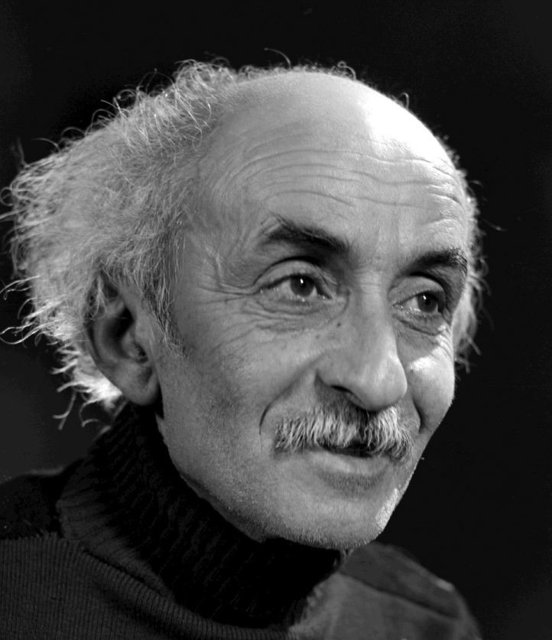
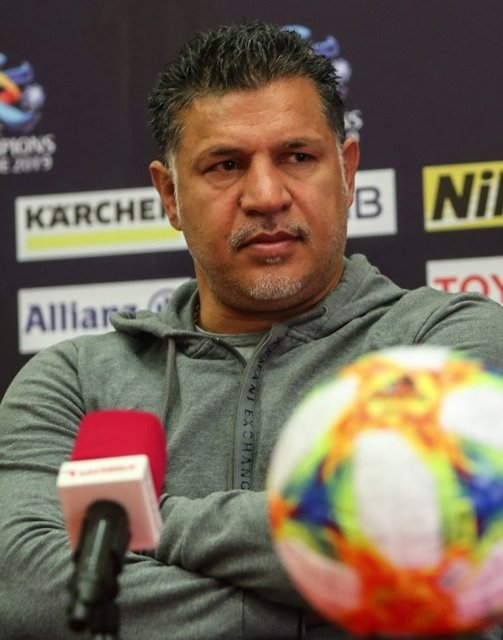
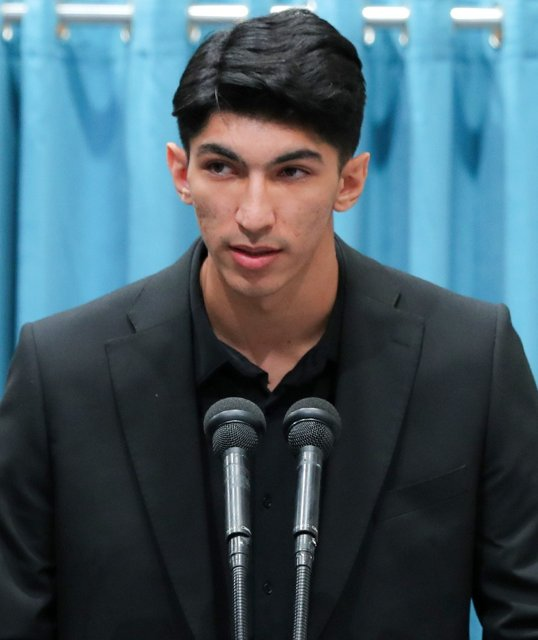
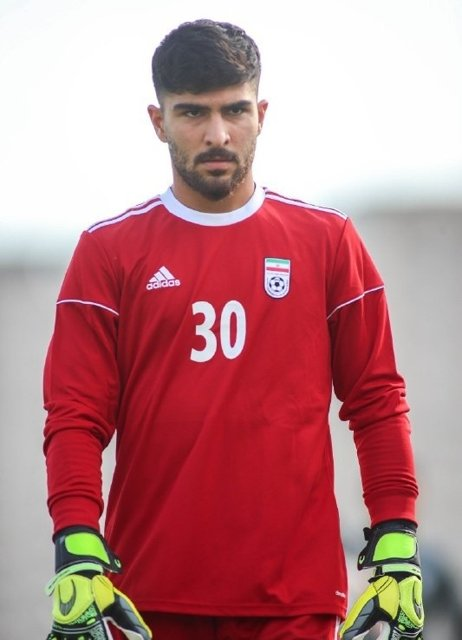
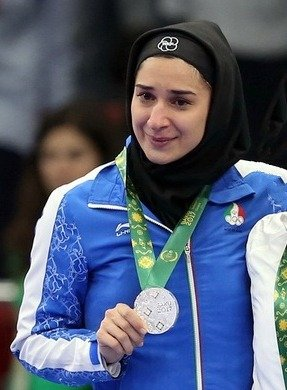
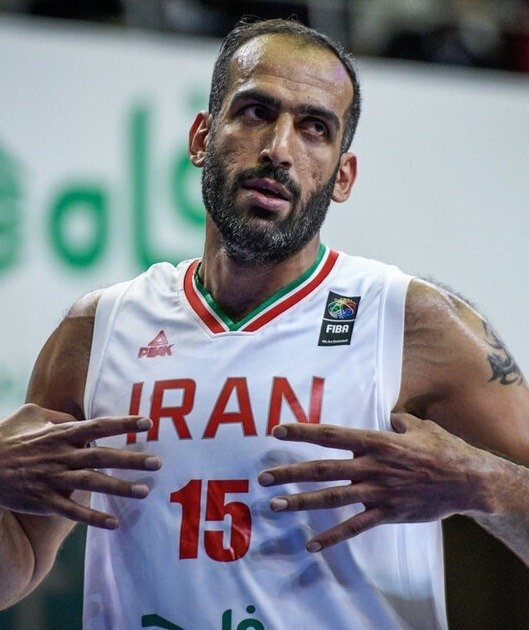
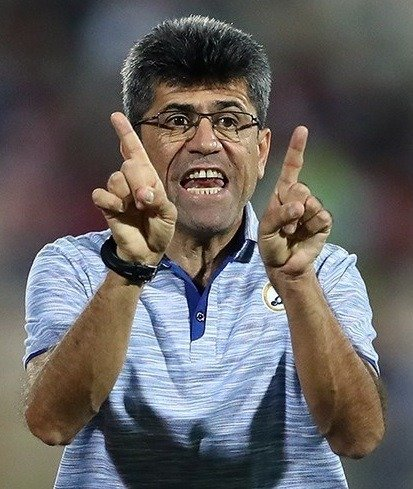
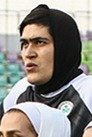
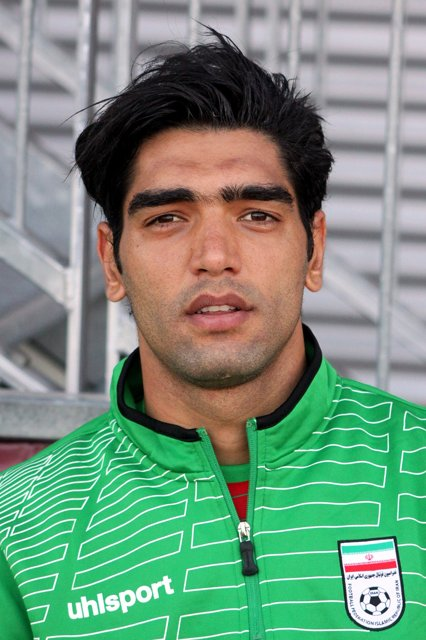
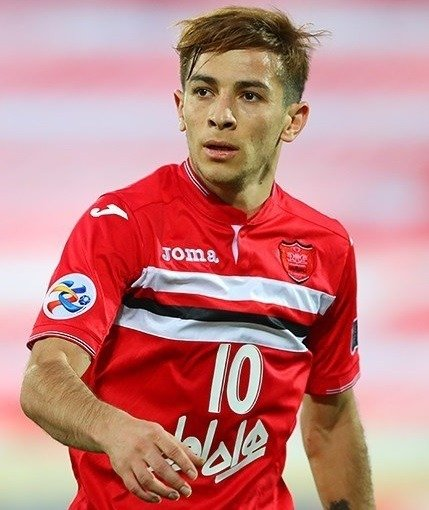
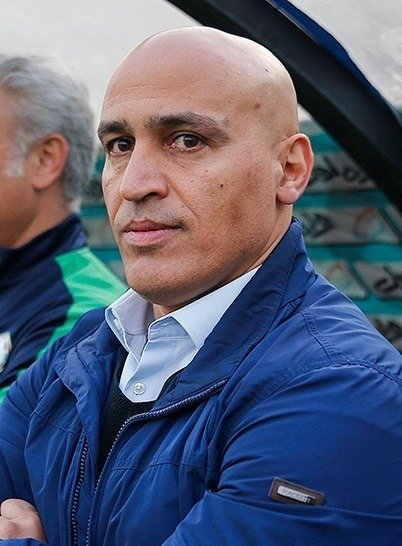
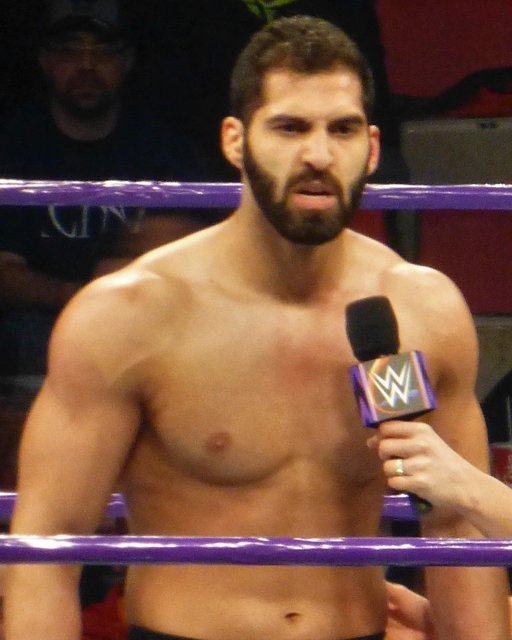
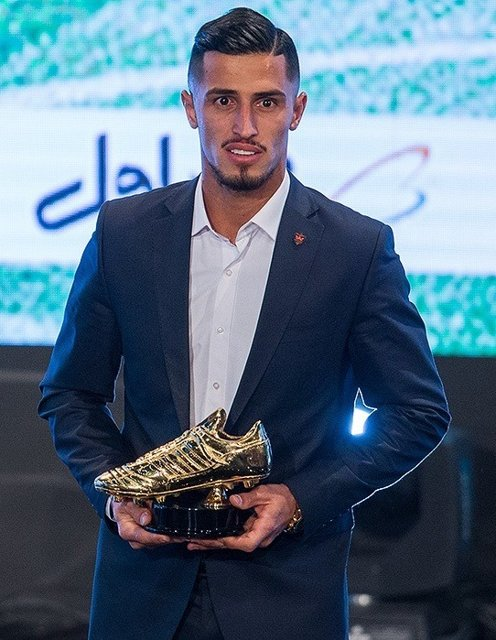
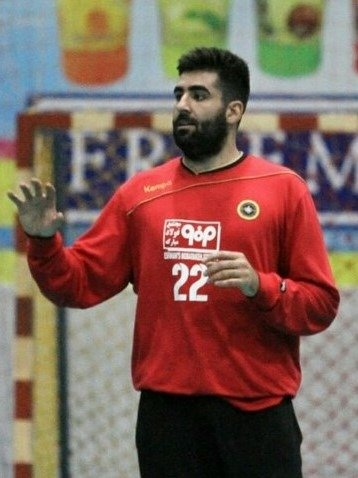
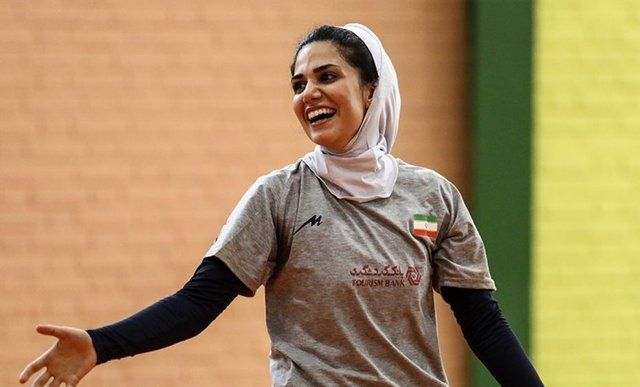
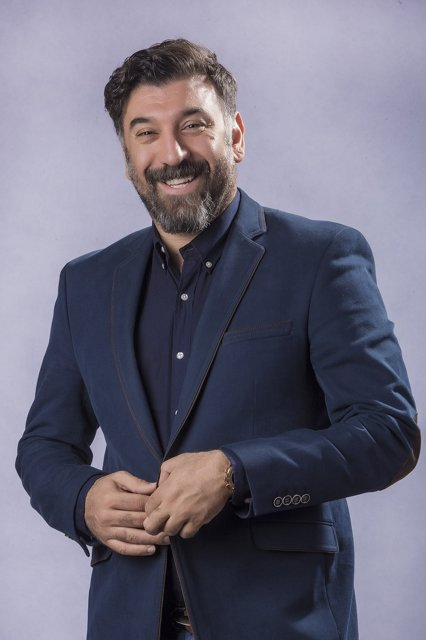
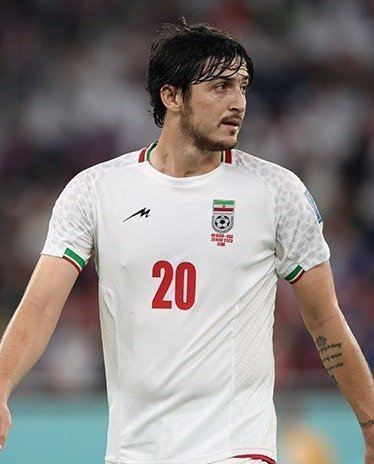
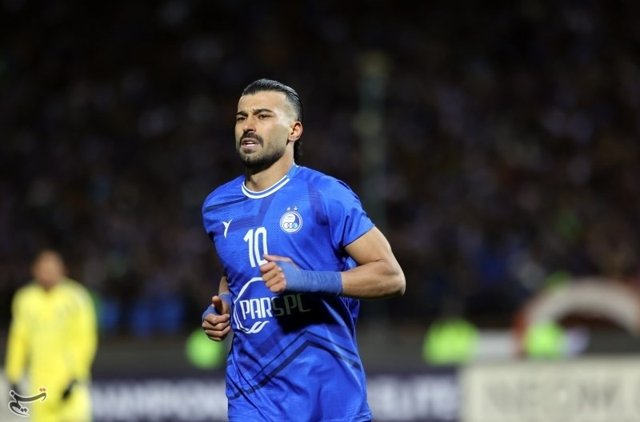
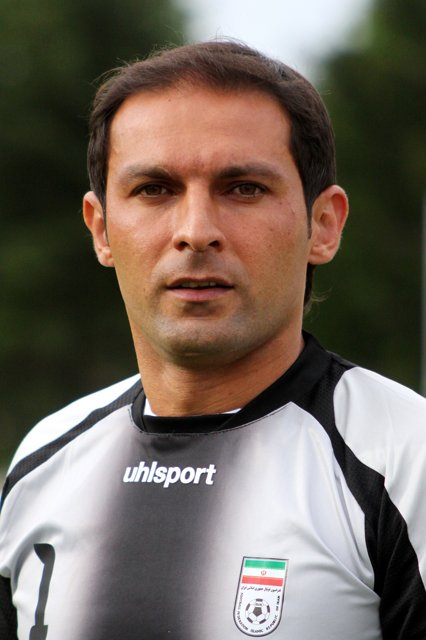
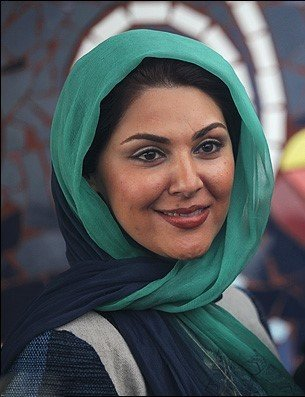
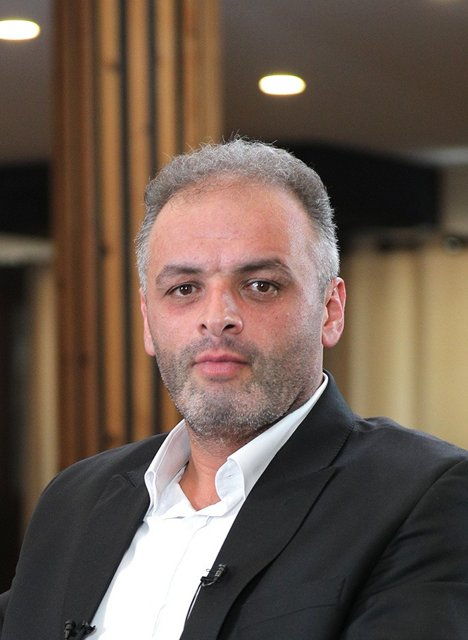
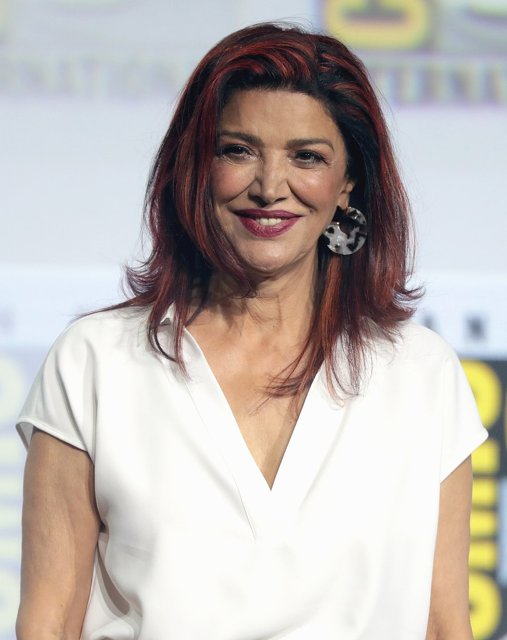
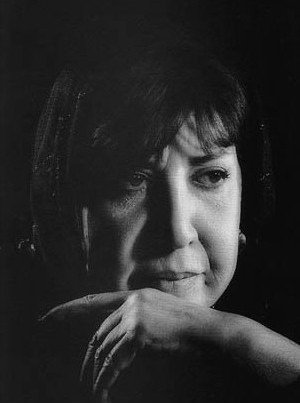
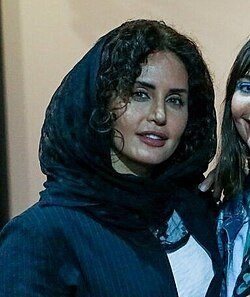
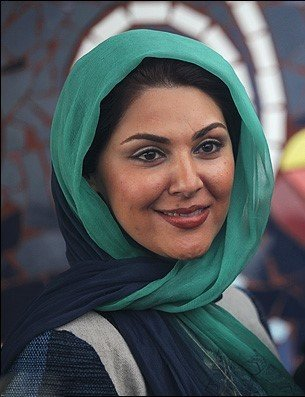
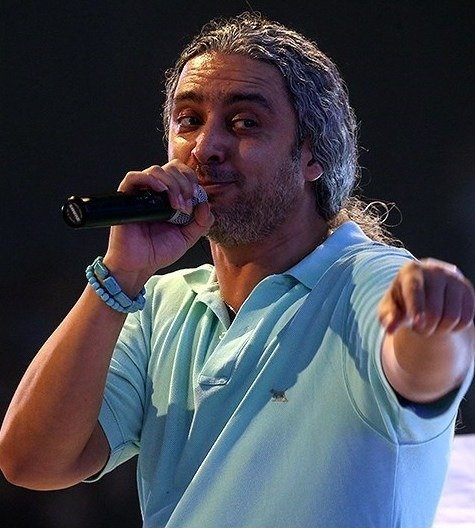
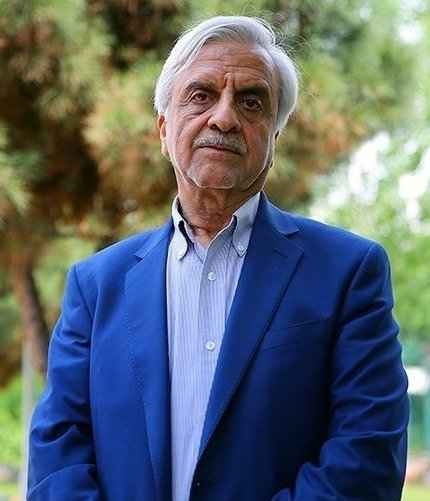
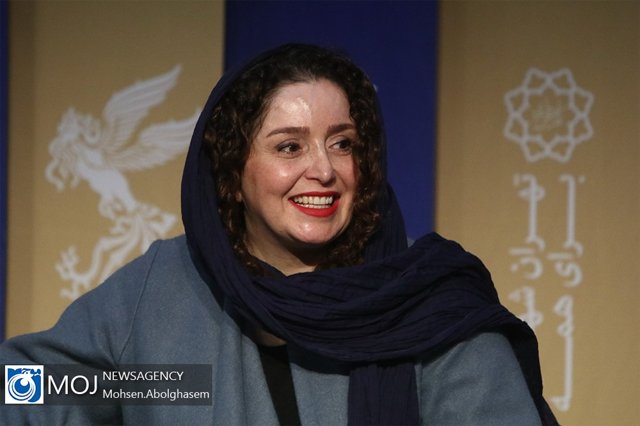
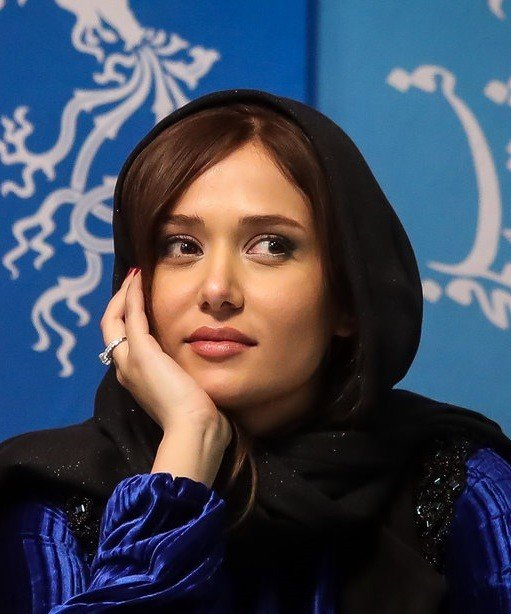
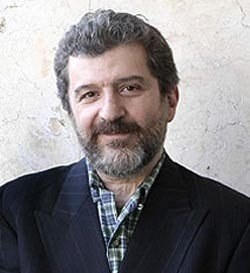
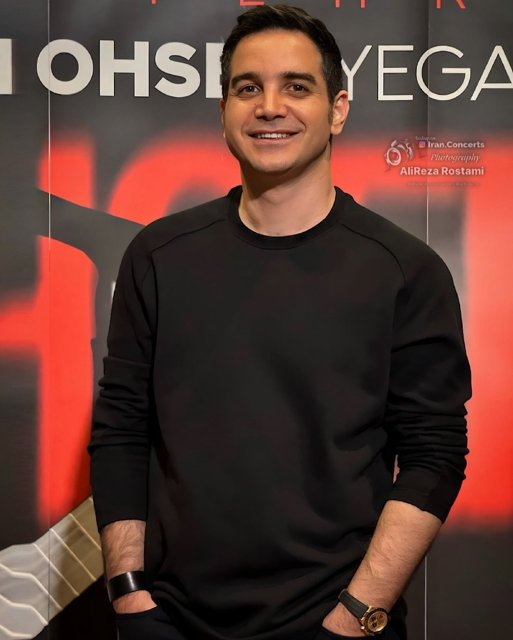
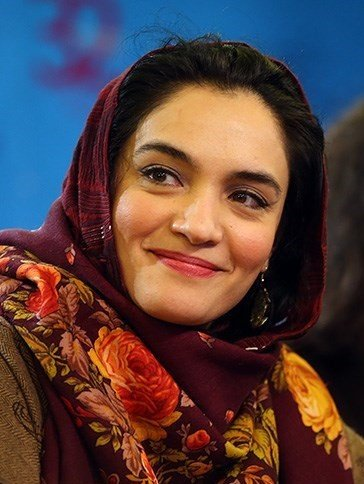
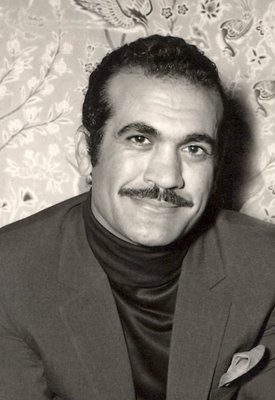
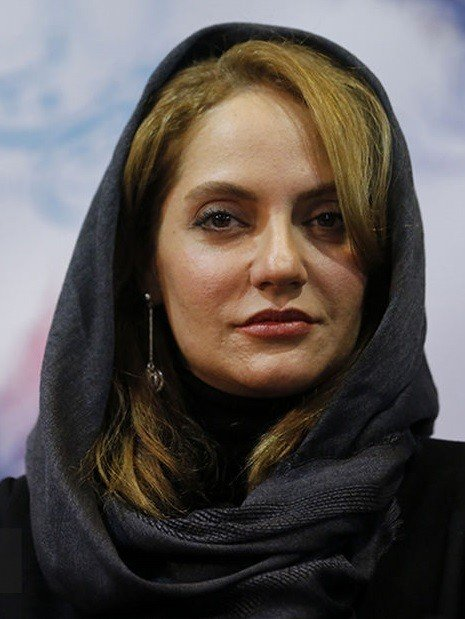
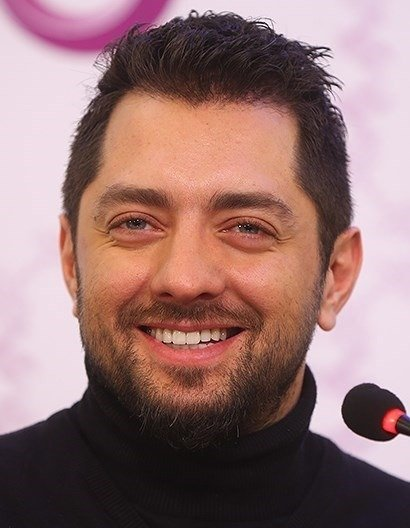
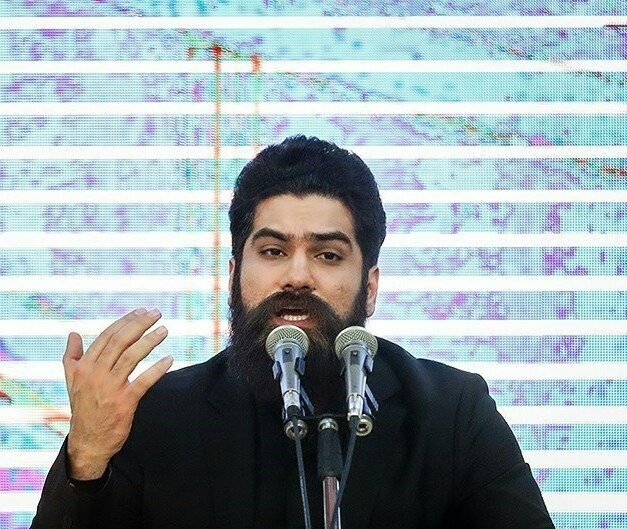
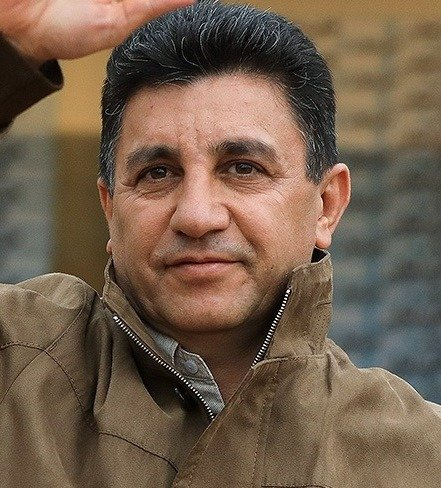
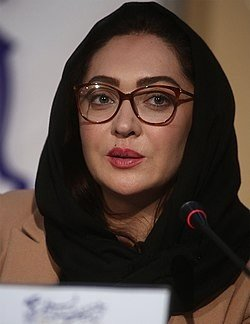
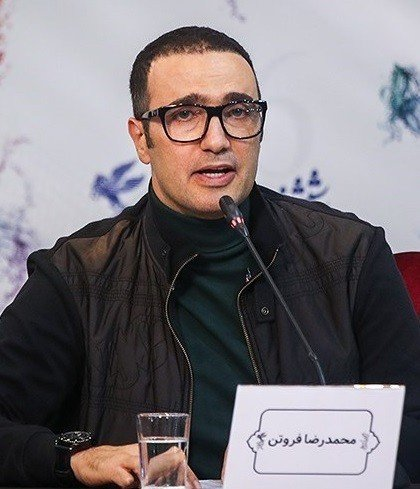
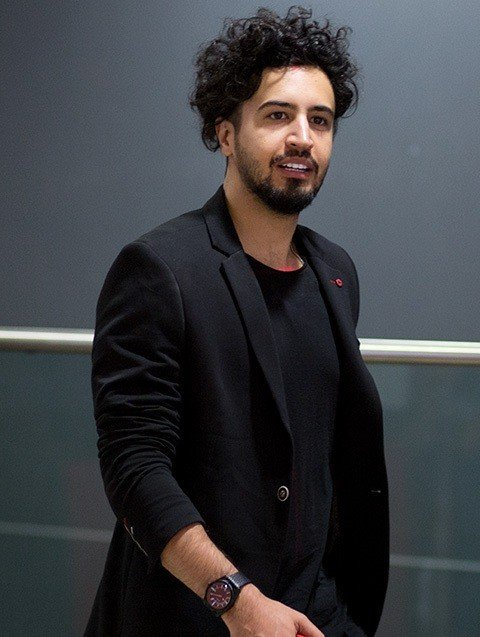
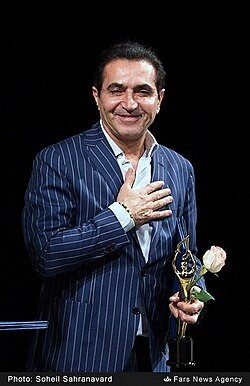
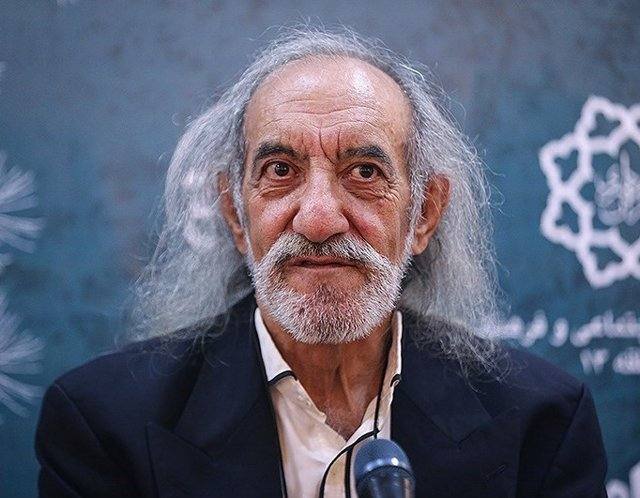
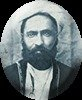
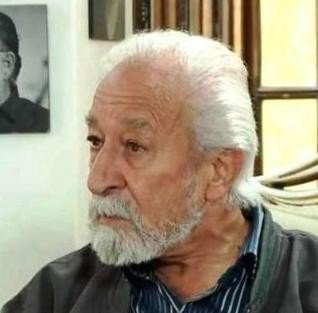
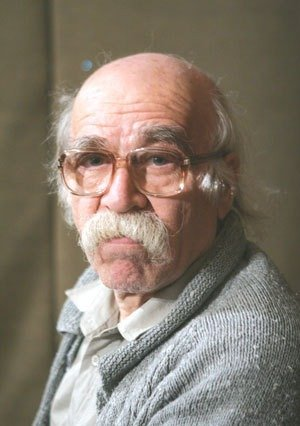

In [32]:
show_approach_1(OUT_DIR / "generative_multimodal_results.csv", start_index=1)

## 2nd approach (API face identification between top3) result for each question


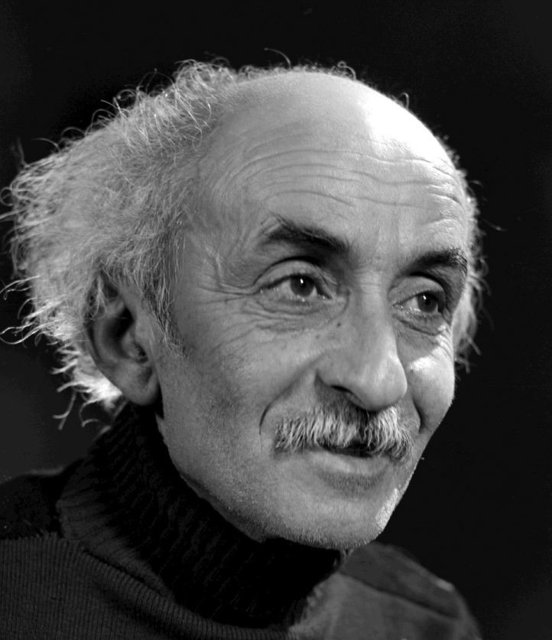
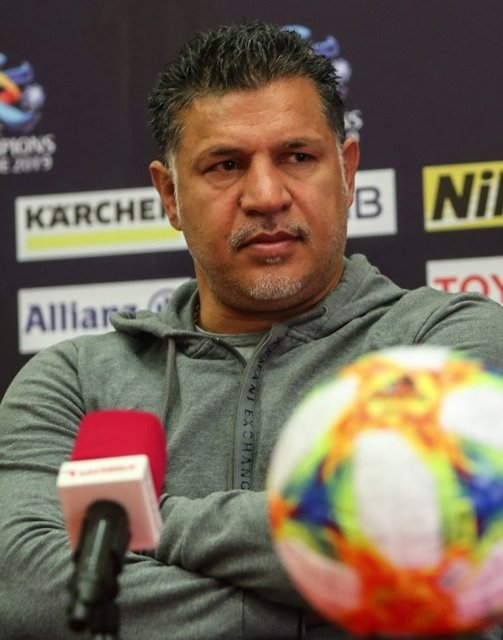
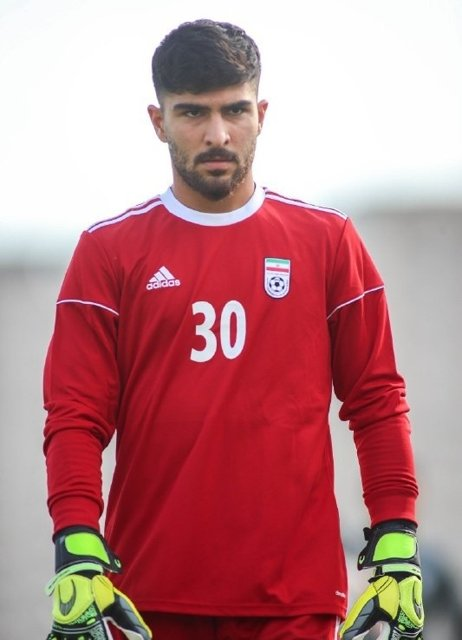
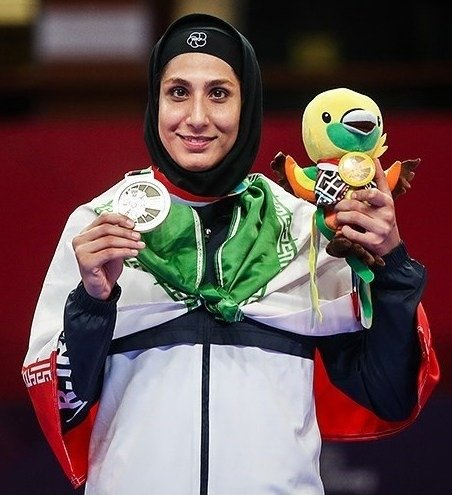
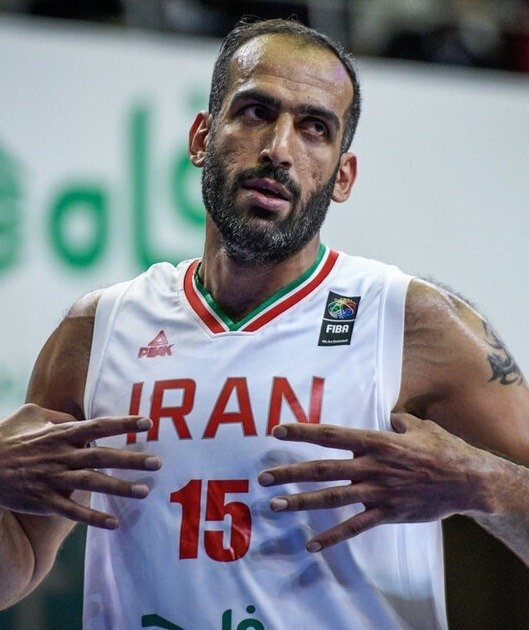
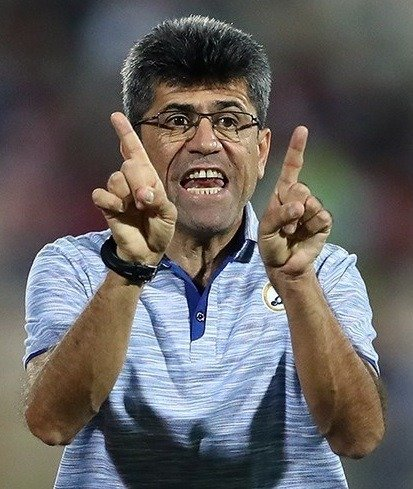
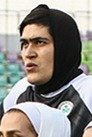
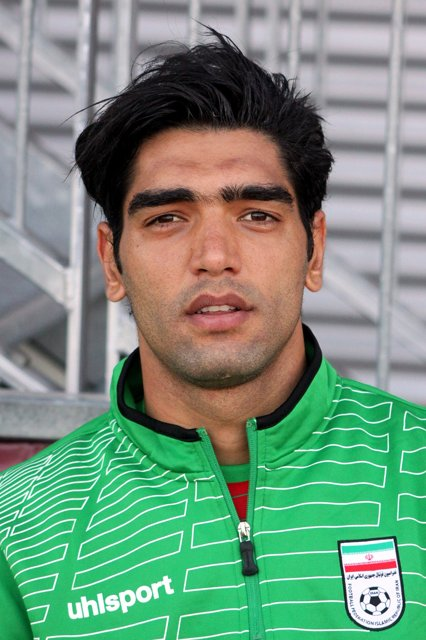
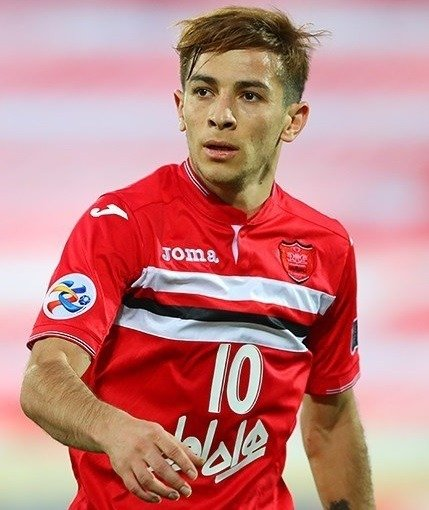
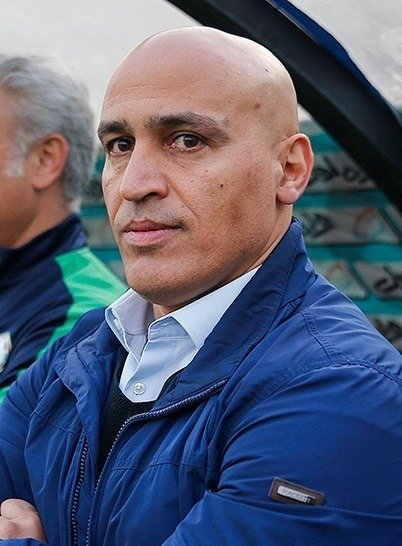
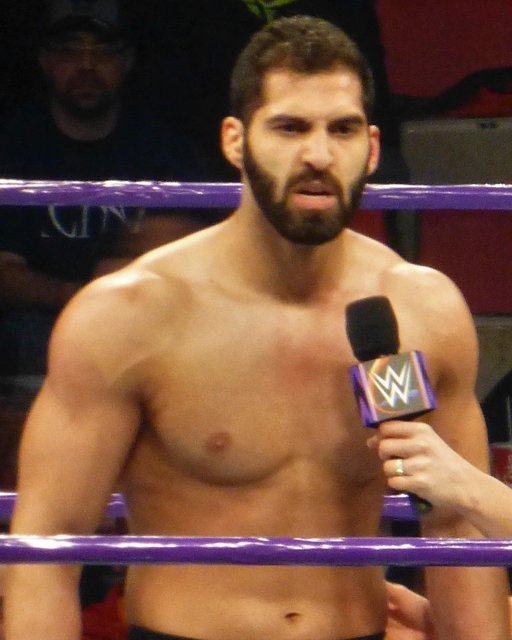
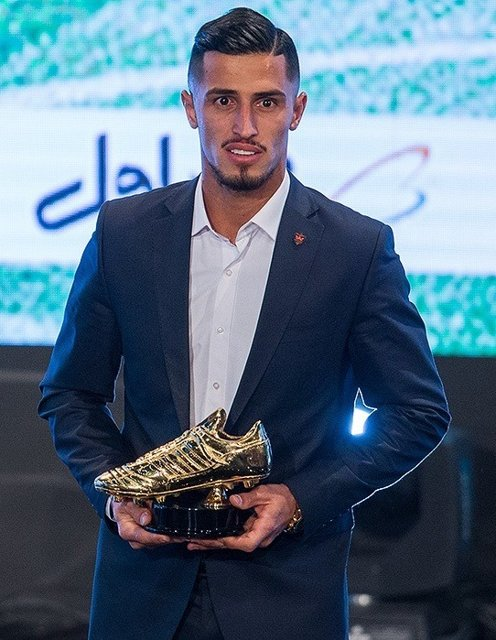
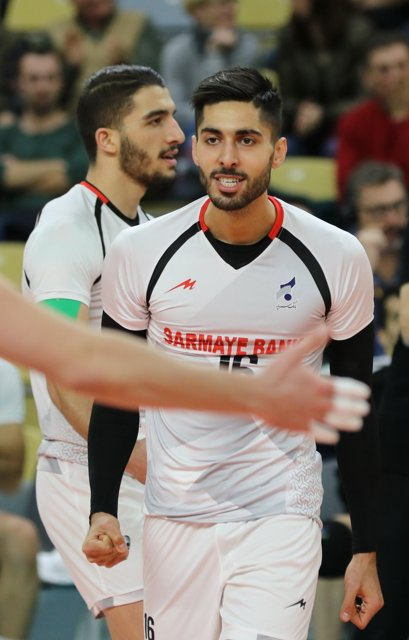
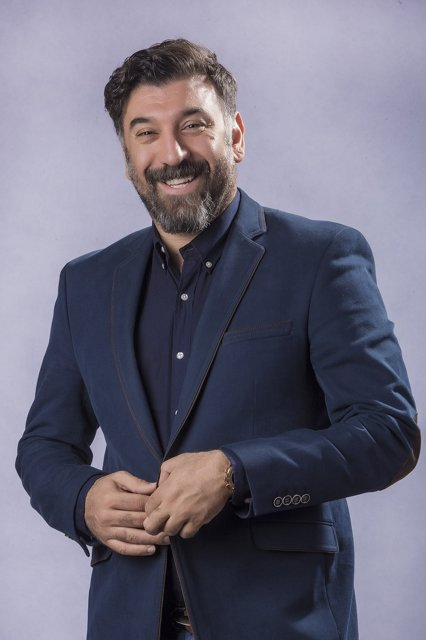
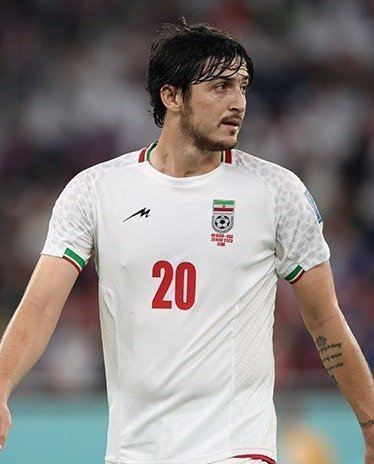
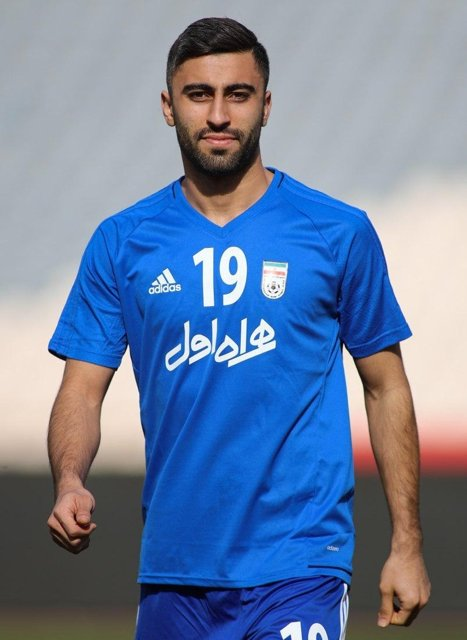
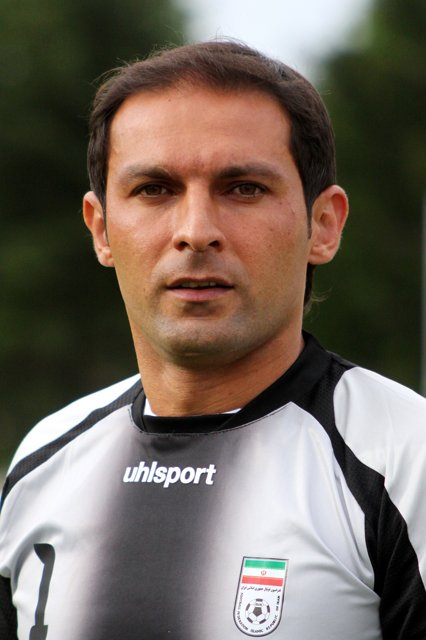
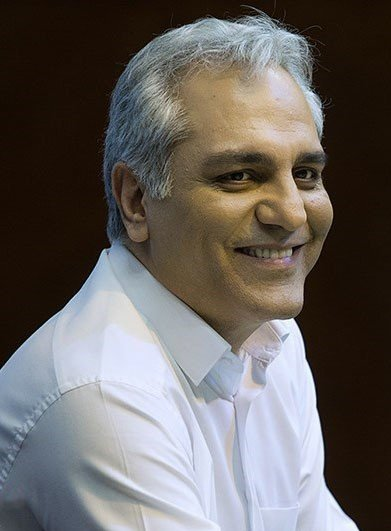
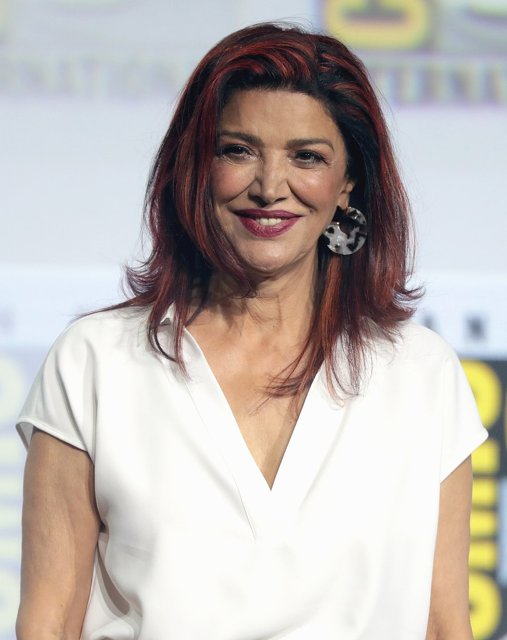
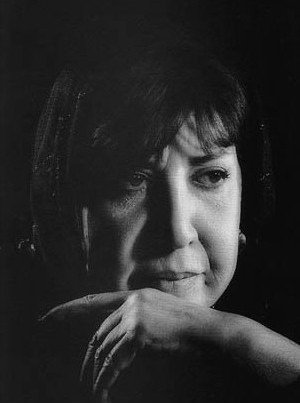
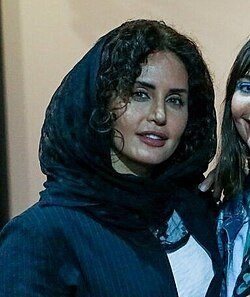
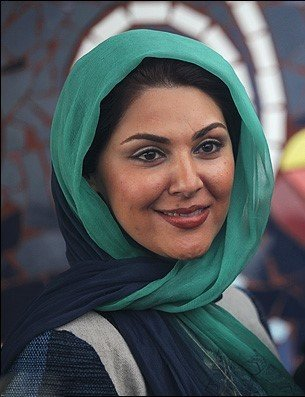
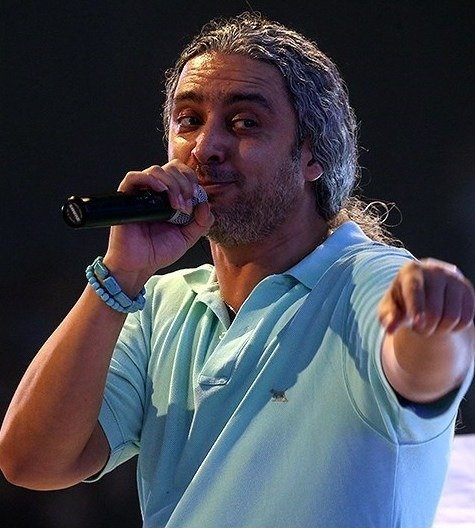
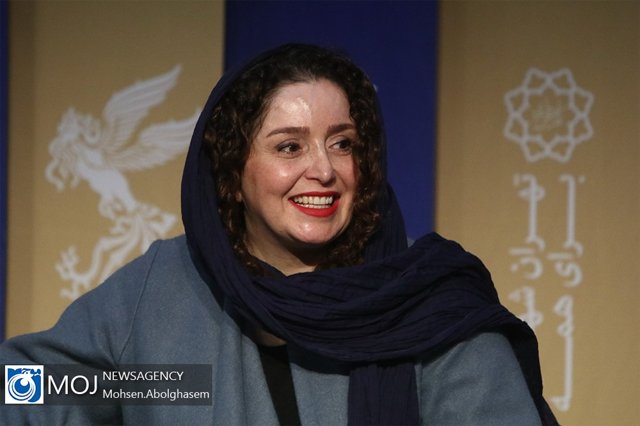
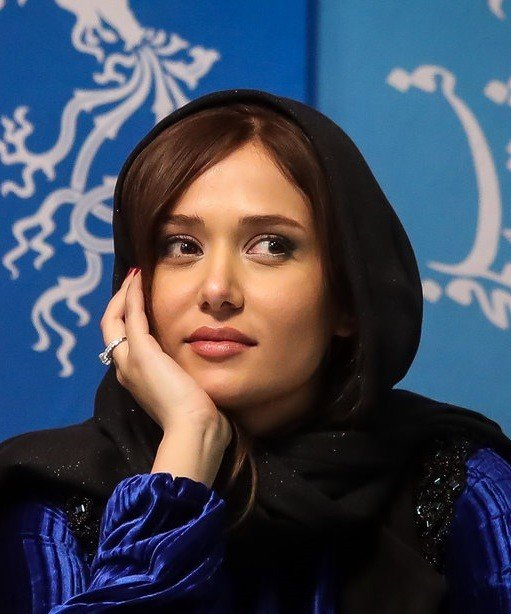
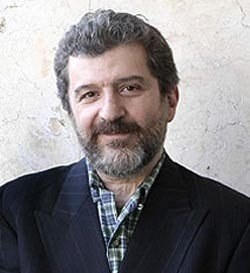
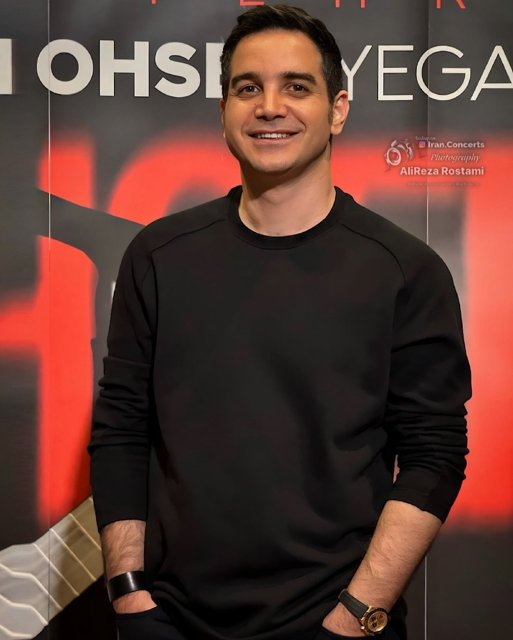
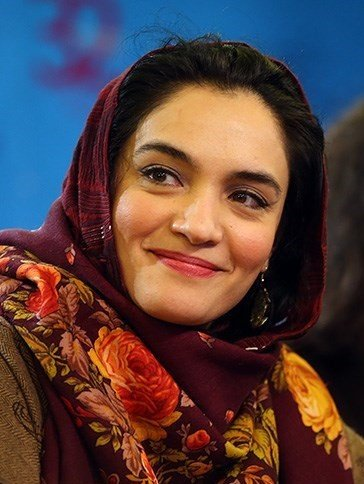
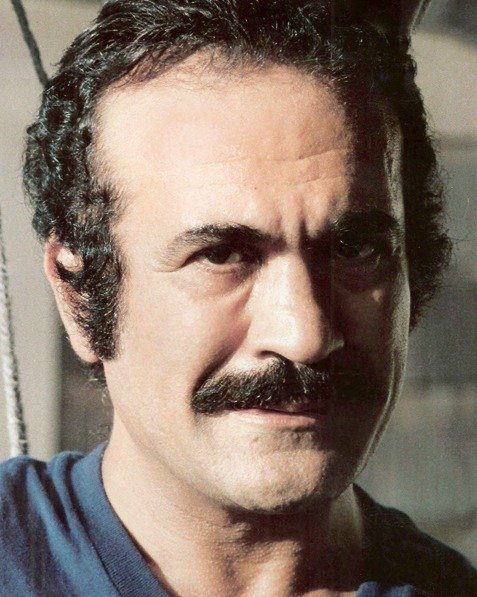
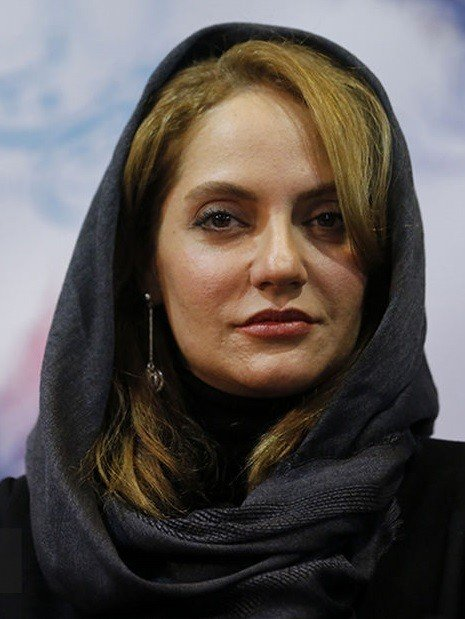
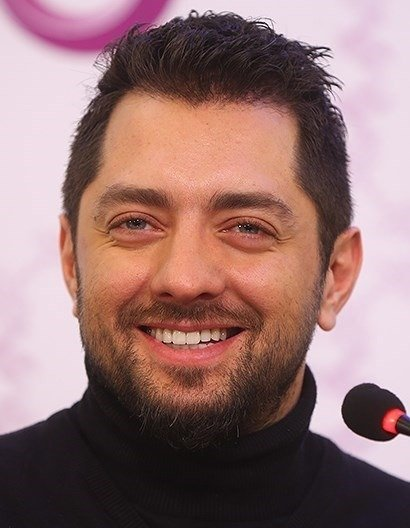
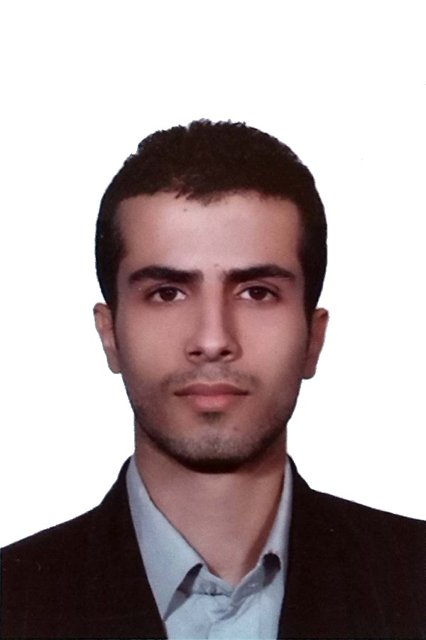
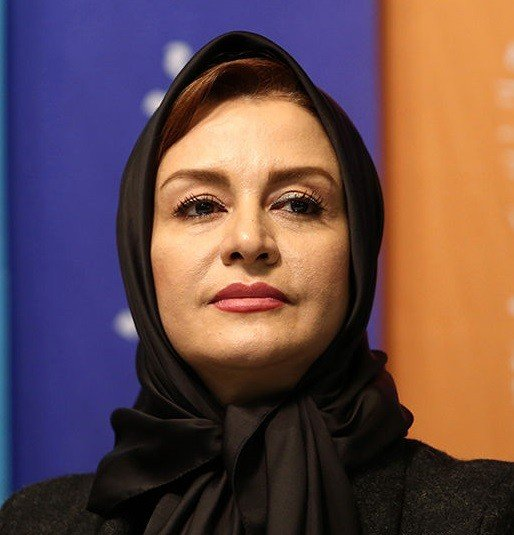
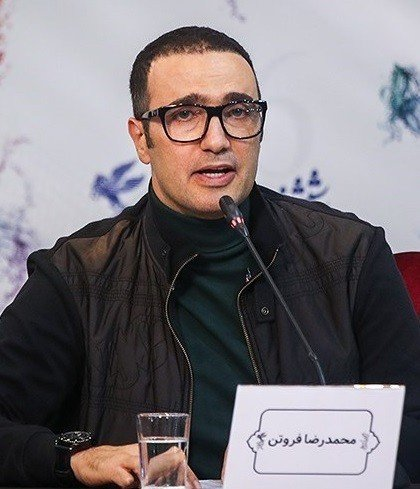
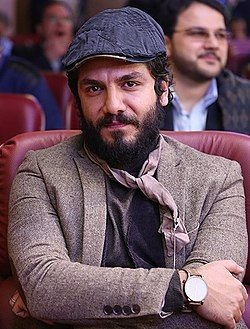
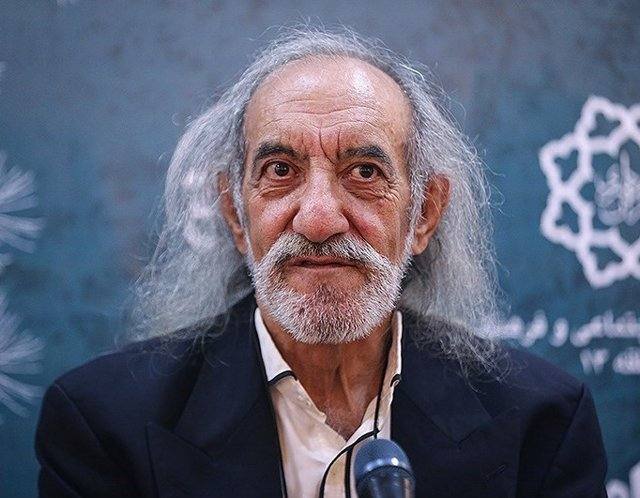
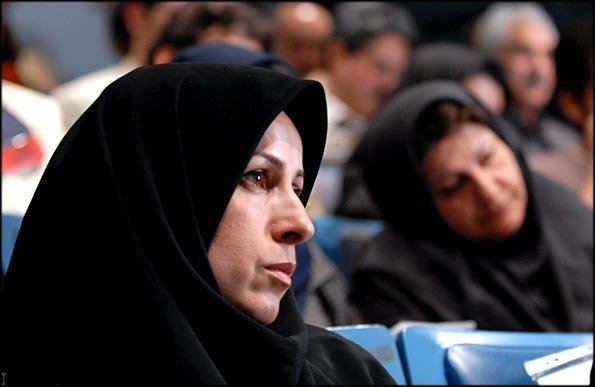
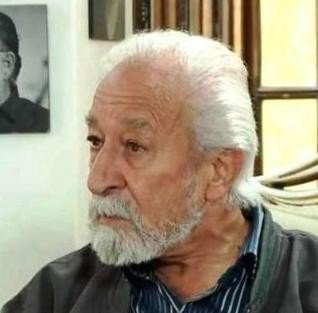
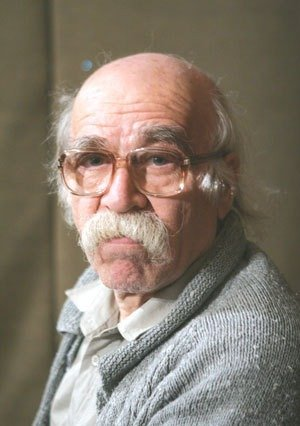

In [33]:
show_approach_2(OUT_DIR / "generative_multimodal_results_identify_between_3.csv", start_index=1)

## 3rd approach (Insightface face clustering) result for each question


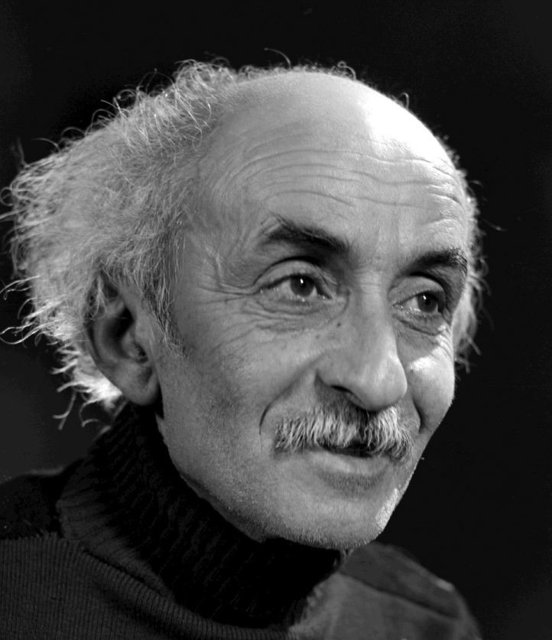
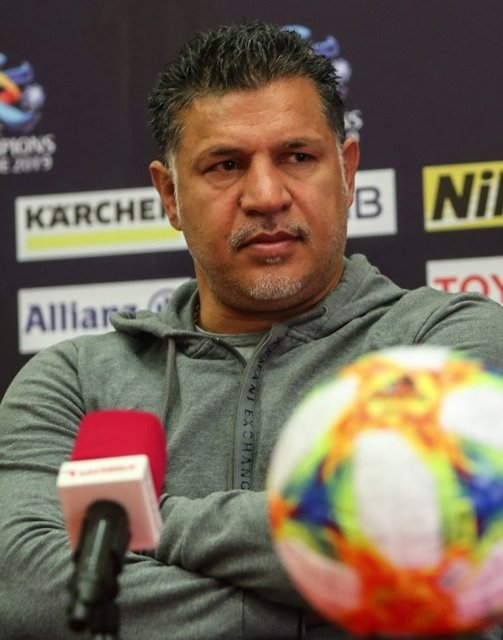
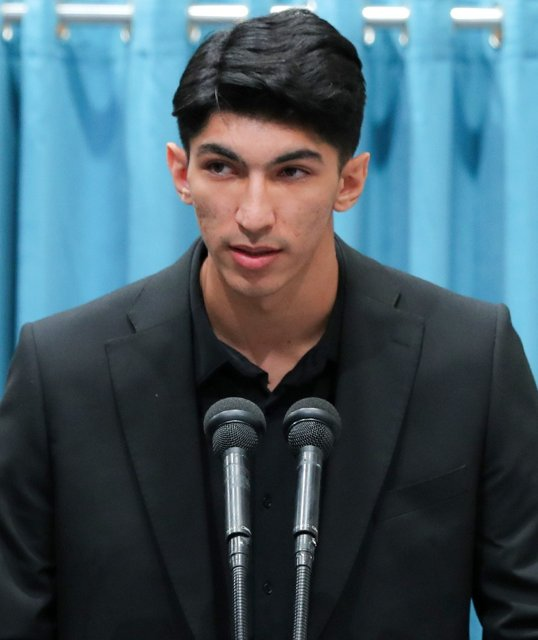
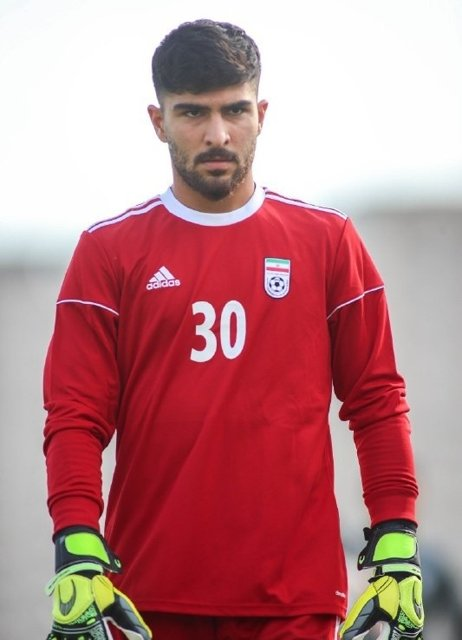
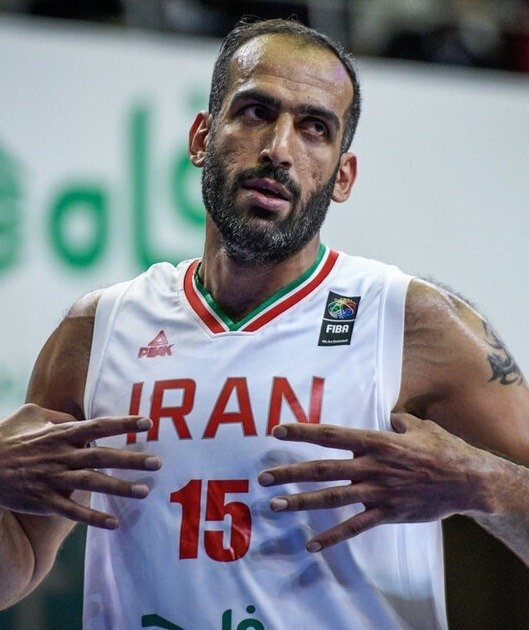
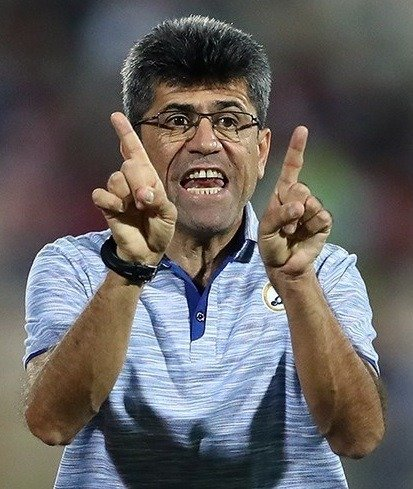
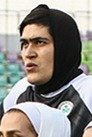
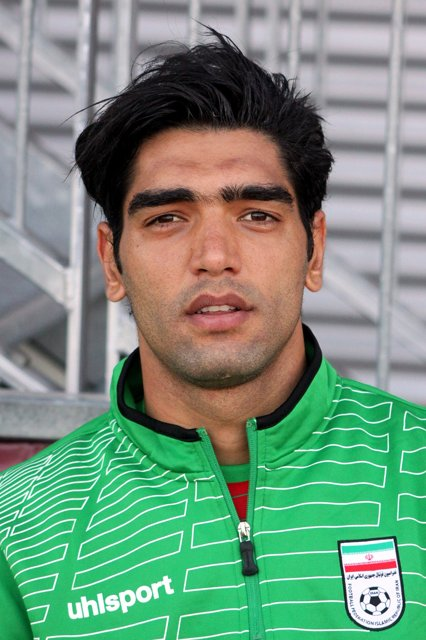
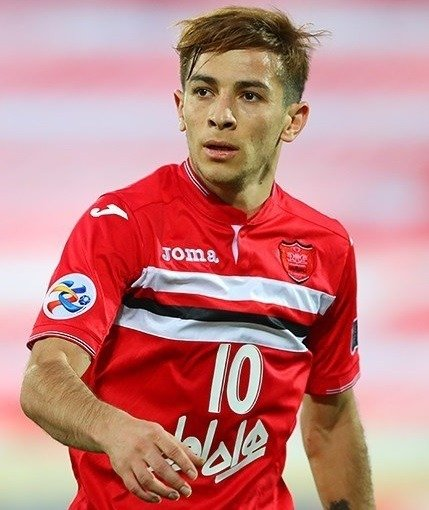
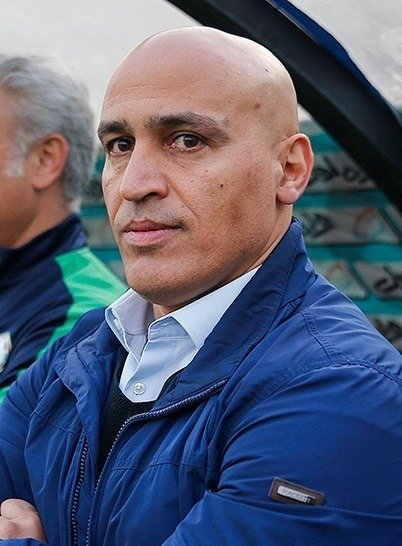
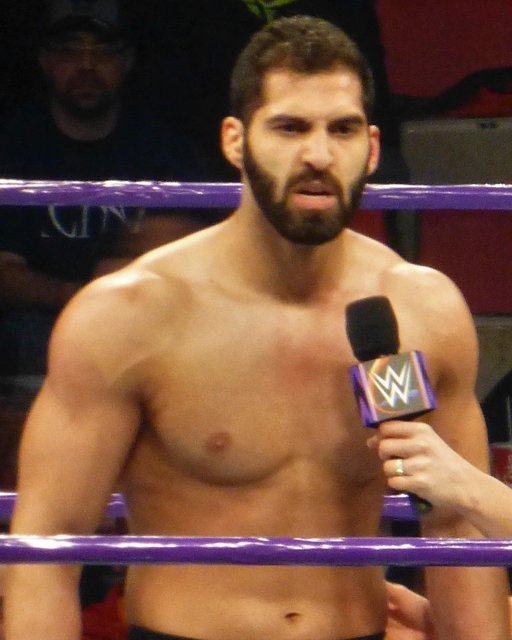
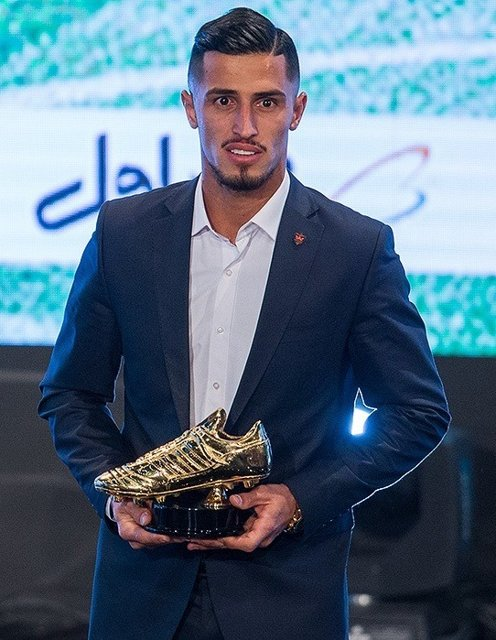
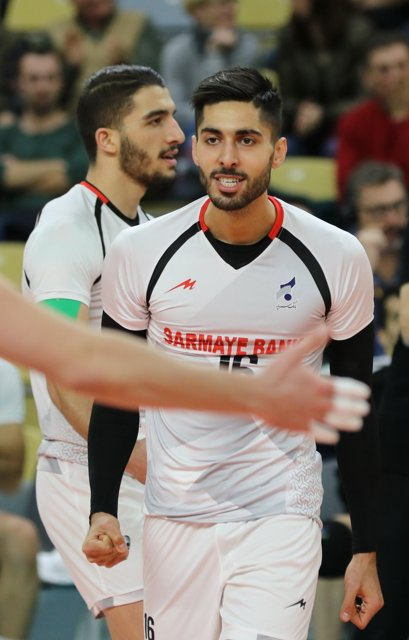
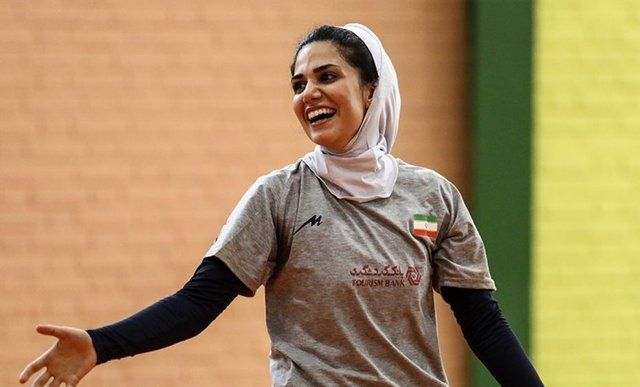
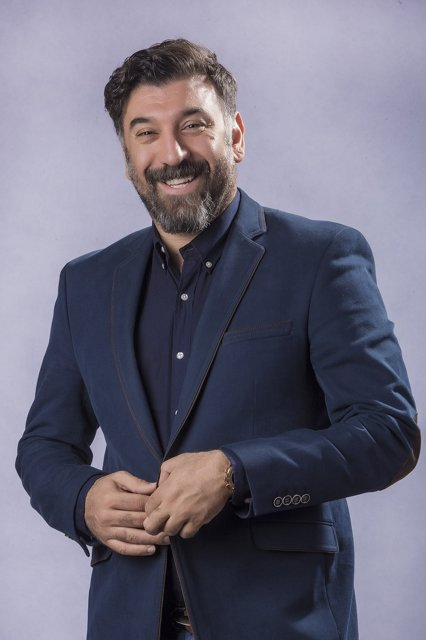
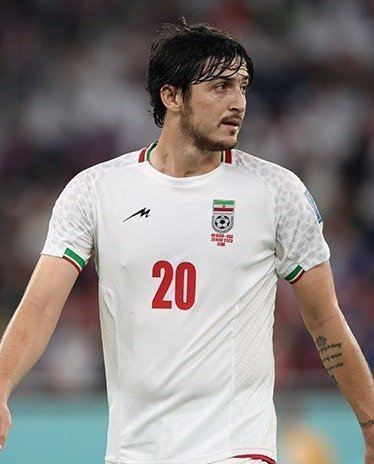
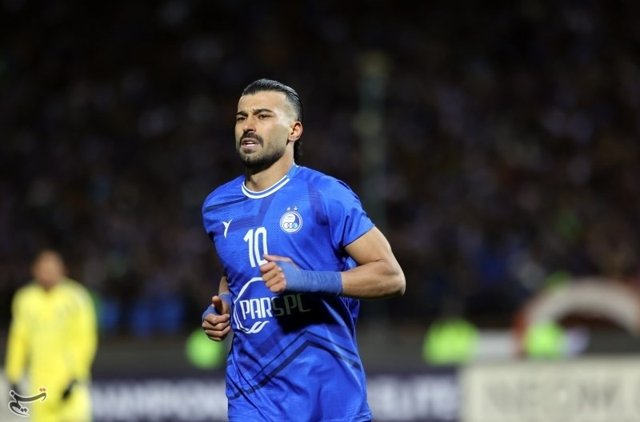
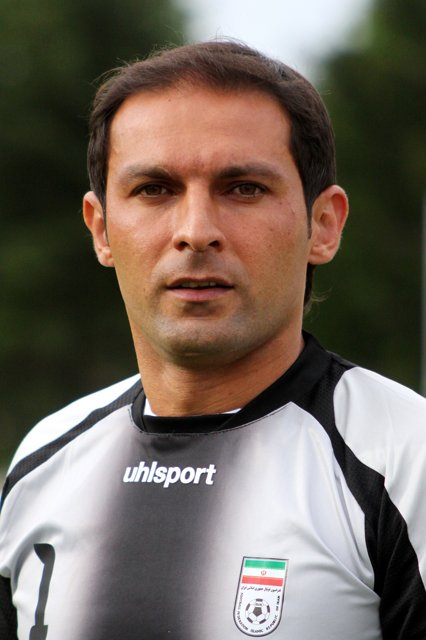
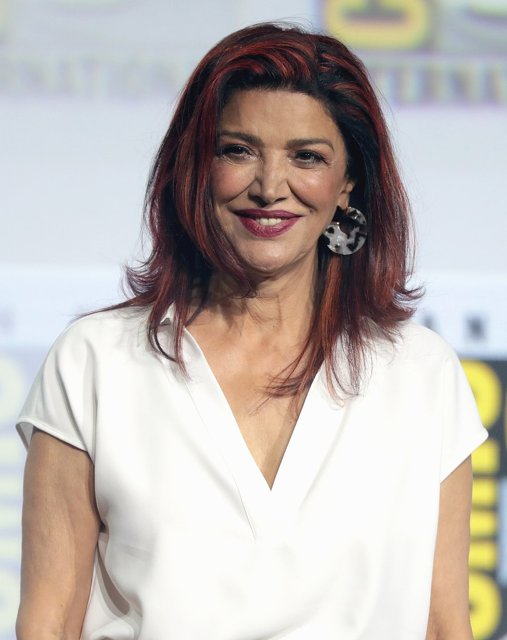
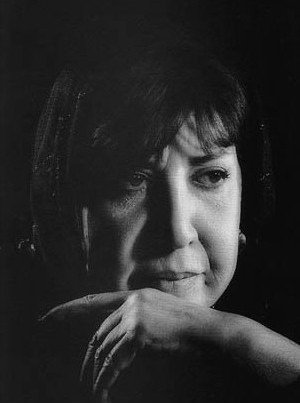
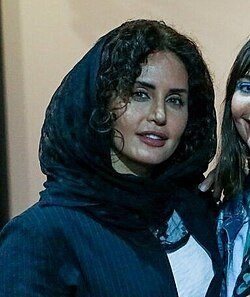
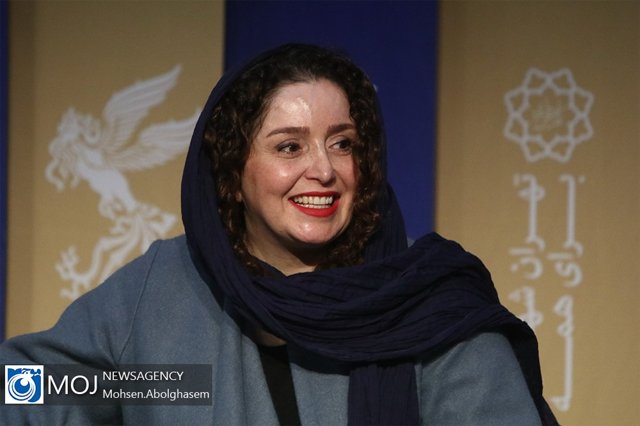
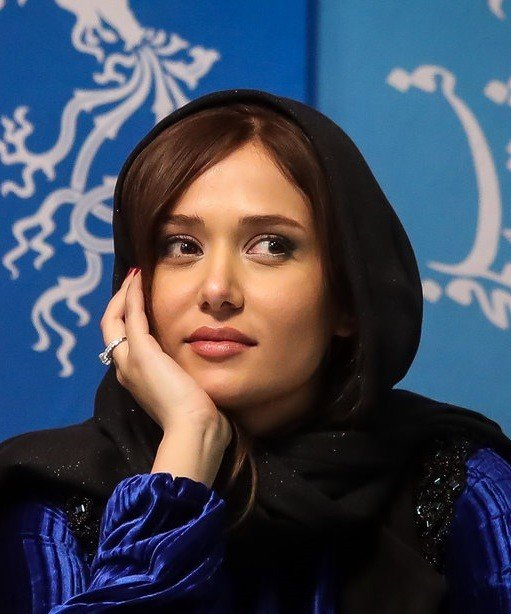
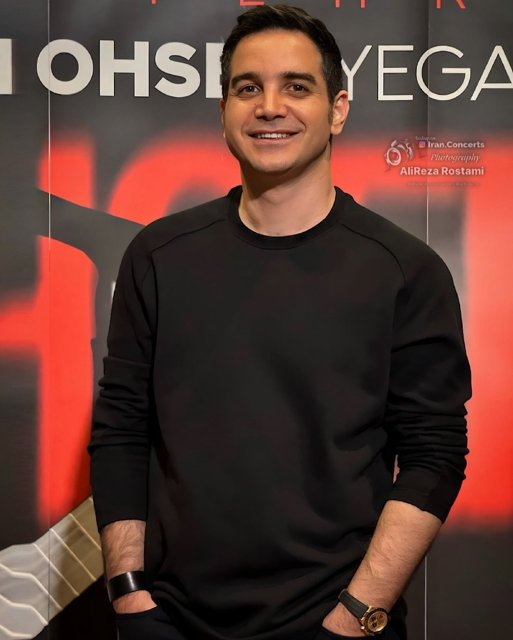
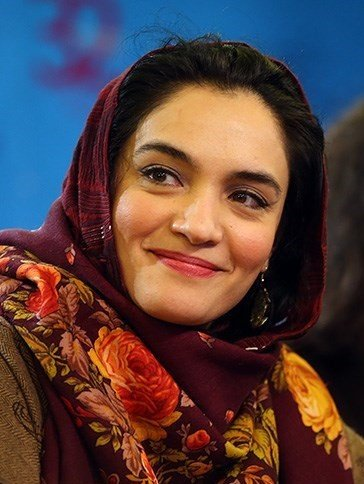
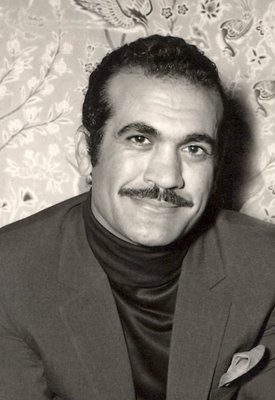
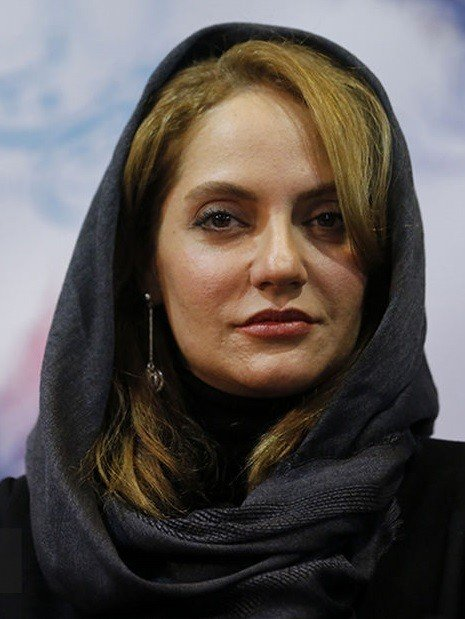
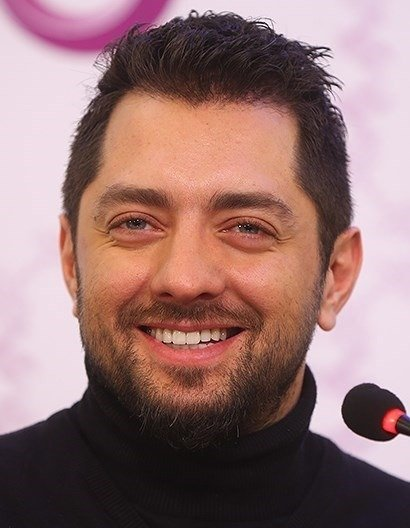
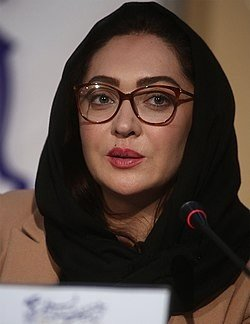
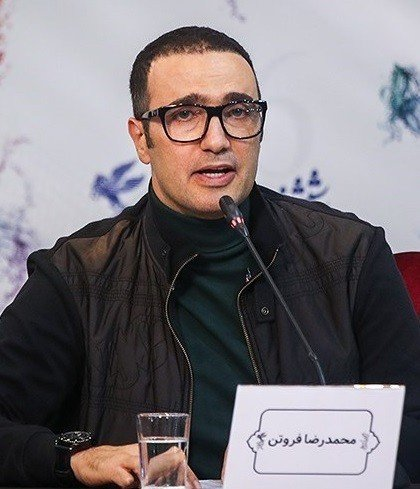
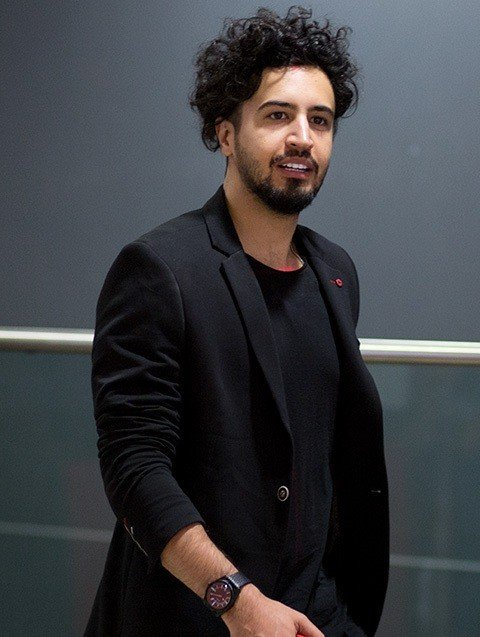
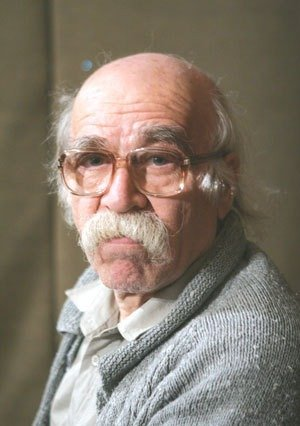

In [34]:
show_approach_3(OUT_DIR / "generative_multimodal_results_faceid.csv", start_index=1)

# Evaluation

## Setup and loading

In [35]:
import json, re
from pathlib import Path
from typing import Dict, Any
import pandas as pd

In [36]:
BASE = Path(r"G:\My Drive\NLP\project")

RAG_OUT = BASE / "rag_out"
QUESTIONS_PATH = BASE / "Questions" / "mcq_with_image_50_final.json"

RET_CSV   = RAG_OUT / "Multimodal_mcq_results_top3.csv"
GEN1_CSV  = RAG_OUT / "generative_multimodal_results.csv"
GEN2_CSV  = RAG_OUT / "generative_multimodal_results_identify_between_3.csv"
GEN3_CSV  = RAG_OUT / "generative_multimodal_results_faceid.csv"

assert QUESTIONS_PATH.exists(), QUESTIONS_PATH
assert RET_CSV.exists(), RET_CSV
assert GEN1_CSV.exists(), GEN1_CSV
assert GEN2_CSV.exists(), GEN2_CSV
assert GEN3_CSV.exists(), GEN3_CSV

In [37]:
import unicodedata, re as _re
ARABIC_TO_PERSIAN = str.maketrans({
    "ي":"ی","ك":"ک","ة":"ه","ۀ":"ه","ؤ":"و","إ":"ا","أ":"ا","ٱ":"ا","ى":"ی"
})
EASTERN_DIGITS = str.maketrans({
    "۰":"0","۱":"1","۲":"2","۳":"3","۴":"4","۵":"5","۶":"6","۷":"7","۸":"8","۹":"9",
    "٠":"0","١":"1","٢":"2","٣":"3","٤":"4","٥":"5","٦":"6","٧":"7","٨":"8","٩":"9",
})
CTRL_RE = _re.compile(r"[\u200c\u200d\u200e\u202a-\u202e]")

def norm_str(s: str) -> str:
    if not isinstance(s, str):
        s = "" if s is None else str(s)
    s = s.translate(ARABIC_TO_PERSIAN)
    s = unicodedata.normalize("NFKC", s)
    s = s.translate(EASTERN_DIGITS)
    s = CTRL_RE.sub("", s)
    s = _re.sub(r"\s+", " ", s).strip()
    return s

def eq(a: str, b: str) -> bool:
    return norm_str(a).lower() == norm_str(b).lower()

In [38]:
q_data = json.loads(QUESTIONS_PATH.read_text(encoding="utf-8"))
q_rows = []
for it in q_data:
    q_rows.append({
        "image_url": (it.get("image_url") or "").strip(),
        "gold_answer": it.get("answer") or "",
        "category": it.get("category") or "",
        "options": list(it.get("options") or []),
        "question_text": it.get("question") or ""
    })
Q = pd.DataFrame(q_rows)
assert not Q["image_url"].duplicated().any(), "image_url must be unique in questions JSON"

In [39]:
RET  = pd.read_csv(RET_CSV, dtype=str, keep_default_na=False)
G1   = pd.read_csv(GEN1_CSV, dtype=str, keep_default_na=False)  # approach 1
G2   = pd.read_csv(GEN2_CSV, dtype=str, keep_default_na=False)  # approach 2
G3   = pd.read_csv(GEN3_CSV, dtype=str, keep_default_na=False)  # approach 3

In [40]:
RET = RET.rename(columns={"input_image_url":"image_url"})
for df in (RET, G1, G2, G3):
    if "image_url" in df.columns:
        df["image_url"] = df["image_url"].astype(str).str.strip()

In [41]:
def pred_from_raw(raw_text: str) -> str:
    t = (raw_text or "").strip()
    if not t:
        return ""
    if t.startswith("```"):
        t = re.sub(r"^```(?:json)?\s*|\s*```$", "", t, flags=re.DOTALL)
    try:
        obj = json.loads(t)
    except Exception:
        m = re.search(r"\{.*\}", t, flags=re.DOTALL)
        if not m:
            return ""
        try:
            obj = json.loads(m.group(0))
        except Exception:
            return ""
    return str(obj.get("predicted_option", "") or "").strip()

if "pred_from_raw" not in G1.columns and "raw_answer_text" in G1.columns:
    G1["pred_from_raw"] = G1["raw_answer_text"].apply(pred_from_raw)
if "pred_from_raw" not in G2.columns and "raw_answer_text" in G2.columns:
    G2["pred_from_raw"] = G2["raw_answer_text"].apply(pred_from_raw)

In [42]:
EVAL = Q.merge(RET, on="image_url", how="left", suffixes=("", "_ret"))
EVAL = EVAL.merge(G1[["image_url","chosen_name","hit_at","pred_from_raw"]].rename(
                    columns={"chosen_name":"g1_chosen_name","hit_at":"g1_hit_at","pred_from_raw":"g1_pred"}),
                  on="image_url", how="left")
EVAL = EVAL.merge(G2[["image_url","identified_name","hit_at","pred_from_raw"]].rename(
                    columns={"identified_name":"g2_identified_name","hit_at":"g2_hit_at","pred_from_raw":"g2_pred"}),
                  on="image_url", how="left")
EVAL = EVAL.merge(G3[["image_url","chosen_name","hit_at","pred_answer"]].rename(
                    columns={"chosen_name":"g3_chosen_name","hit_at":"g3_hit_at","pred_answer":"g3_pred"}),
                  on="image_url", how="left")

In [43]:
for c in ["g1_hit_at","g2_hit_at","g3_hit_at"]:
    if c in EVAL.columns:
        EVAL[c] = EVAL[c].apply(lambda x: int(float(x)) if str(x).strip() not in ("",) else 0)

pd.set_option("display.max_colwidth", 200)
EVAL.head(10)

image_url  \
0                                                                                                           https://th.bing.com/th/id/R.160f7eae6c078d2470d8ddaf9ac63852?rik=PAp6KjqSKQI7DQ&pid=ImgRaw&r=0   
1                                                                                                           https://th.bing.com/th/id/R.f19cd7c574fb1ceb37d0dd7557333735?rik=lLL0kQFoooPrMA&pid=ImgRaw&r=0   
2                                                                                                           https://tse3.mm.bing.net/th/id/OIP.jYgq1FpWPqXFzJozqYAbaAHaE8?r=0&rs=1&pid=ImgDetMain&o=7&rm=3   
3                                                                                                           https://tse1.mm.bing.net/th/id/OIP.HWeitJoEEB6czPH9_vBFnAAAAA?r=0&rs=1&pid=ImgDetMain&o=7&rm=3   
4                                                                                                           https://th.bing.com/th/id/R.57c6d4b5dd95b0ab883305644766e509?rik=pe6okxuixqaihQ&pid=ImgRaw&r=0   
5                                                                                                           https://tse3.mm.bing.net/th/id/OIP.1SroD7i6k-t2T7z7T8ulsAHaE8?r=0&rs=1&pid=ImgDetMain&o=7&rm=3   
6                                                                                                           https://tse1.mm.bing.net/th/id/OIP.nU_OzOvZ6YmVGsrnEwkJfAHaFk?r=0&rs=1&pid=ImgDetMain&o=7&rm=3   
7                                                                                                           https://tse1.mm.bing.net/th/id/OIP.99bDP9MqeM01dUFJwcS5JQHaGL?r=0&rs=1&pid=ImgDetMain&o=7&rm=3   
8  https://th.bing.com/th/id/R.0041d3d9cef0a1d121c4a610b90e36cc?rik=e5XMOU%2bP0YtBKw&riu=http%3a%2f%2fwww.parvaresheafkar.com%2fwp-content%2fuploads%2f2018%2f07%2fReza-Yazdani-24.jpg&ehk=6pBqo35rfX9r...   
9                                                                                                           https://tse1.mm.bing.net/th/id/OIP.UnmNcdG5ULdYoUDye-VChAHaFG?r=0&rs=1&pid=ImgDetMain&o=7&rm=3   

                gold_answer category  \
0           نیما یوشیج شاعر    poets   
1                  علی دایی  athlete   
2                آرین سلیمی  athlete   
3   امیر عابدزاده، پرسپولیس  athlete   
4      رزیتا علیپور، کاراته  athlete   
5      حامد حدادی ، بسکتبال  athlete   
6  بهروز مکوندی، مسجدسلیمان  athlete   
7        زهره کودایی سپاهان  athlete   
8                رضا یزدانی  athlete   
9          رضا حقیقی فوتبال  athlete   

                                                                                       options  \
0               [نیما یوشیج شاعر, نیما یوشیج بازیگر, ابراهیم نبوی نویسنده, بهروز وثوقی بازیگر]   
1                                              [علی دایی, آرش افشین, محسن بیرانوند, محمد خادم]   
2                                            [امیر یاوری, آرین سلیمی, بابک معصومی, امید خالدی]   
3  [افشین ناظمی، استقلال, محمد محمدی، سایپا, امیر عابدزاده، پرسپولیس, ابراهیم شکوری، پرسپولیس]   
4     [الهه احمدی، تیراندازی, زهرا نبیزاده، اسکیت, ترانه احمدی، تکواندو, رزیتا علیپور، کاراته]   
5         [حامد حدادی ، بسکتبال, حسن عسگری ، والیبال, نیما عالمیان ، شنا, حامد حدادی ، فوتبال]   
6     [جاسم امیری، تهران, امیرحسین صابری، شیراز, بهروز مکوندی، مسجدسلیمان, بهرام توکلی، تهران]   
7         [الهام حسنی سپاهان, بهاره قادریان پرسپولیس, زهره کودایی سپاهان, مریم یوسفی پرسپولیس]   
8                                           [رضا یزدانی, داوود فنایی, حمید درخشان, حسین کریمی]   
9                  [رضا حقیقی فوتبال, سبحان روحی کشتی, رضا حقیقی والیبال, ایرج سلیمانی فوتبال]   

                                         question_text  \
0      این فرد کیست و در چه زمینه ای فعالیت داشته است؟   
1                               این چهره ی چه کسی است؟   
2                               این چهره ی چه کسی است؟   
3    این چهره ی چه کسی است و در چه تیمی بازی کرده است؟   
4  این چهره ی چه کسی است و در چه رشته ای فعالیت میکند؟   
5  این چهره ی چه کسی است و در چه رشته ای فعالیت میکند؟   


## Retrieval phase evaluation

In [44]:
def retrieval_rank(row: pd.Series) -> int:
    gold = row["gold_answer"]
    # compare to the *options* columns
    if "top1_option" in row and eq(gold, row["top1_option"]): return 1
    if "top2_option" in row and eq(gold, row["top2_option"]): return 2
    if "top3_option" in row and eq(gold, row["top3_option"]): return 3
    return 0  # 0 => not in top3

R = EVAL.copy()
R["ret_rank"] = R.apply(retrieval_rank, axis=1)
R["hit@1"] = (R["ret_rank"] == 1).astype(int)
R["hit@3"] = (R["ret_rank"] > 0).astype(int)
R["mrr"]   = R["ret_rank"].apply(lambda r: 1.0/r if r in (1,2,3) else 0.0)

In [45]:
print("Retrieval — overall")
print({
    "N": len(R),
    "Hit@1": R["hit@1"].mean(),
    "Hit@3": R["hit@3"].mean(),
    "MRR": R["mrr"].mean(),
})

Retrieval — overall
{'N': 50, 'Hit@1': 0.74, 'Hit@3': 0.86, 'MRR': 0.7933333333333334}


In [46]:
print("\nRetrieval — by category")
bycat = R.groupby("category").agg(
    N=("image_url","count"),
    Hit1=("hit@1","mean"),
    Hit3=("hit@3","mean"),
    MRR=("mrr","mean")
).reset_index().sort_values("Hit3", ascending=False)
bycat


Retrieval — by category


category   N      Hit1      Hit3       MRR
1      athlete  20  0.900000  1.000000  0.950000
2        poets   6  1.000000  1.000000  1.000000
0    art_music  19  0.578947  0.736842  0.649123
3  politicians   5  0.400000  0.600000  0.466667

## Generative phase evaluation

In [47]:
G = EVAL.copy()
G["gold"] = G["gold_answer"]

# Approach 1 and 2: use predicted_option parsed from raw JSON
G["pred1"] = G.get("g1_pred", "")
G["pred2"] = G.get("g2_pred", "")
# Approach 3: use its pred_answer column
G["pred3"] = G.get("g3_pred", "")

# Correctness (normalized exact match)
G["acc1"] = [int(eq(a,b)) for a,b in zip(G["gold"], G["pred1"])]
G["acc2"] = [int(eq(a,b)) for a,b in zip(G["gold"], G["pred2"])]
G["acc3"] = [int(eq(a,b)) for a,b in zip(G["gold"], G["pred3"])]

In [48]:
print("Generative accuracy — overall")
print({
    "N": len(G),
    "Approach1": G["acc1"].mean(),
    "Approach2": G["acc2"].mean(),
    "Approach3": G["acc3"].mean(),
})

Generative accuracy — overall
{'N': 50, 'Approach1': 0.68, 'Approach2': 0.64, 'Approach3': 0.64}


In [49]:
print("\nGenerative accuracy — by category")
gen_bycat = G.groupby("category").agg(
    N=("image_url","count"),
    A1=("acc1","mean"),
    A2=("acc2","mean"),
    A3=("acc3","mean"),
).reset_index().sort_values("A3", ascending=False)
gen_bycat


Generative accuracy — by category


category   N        A1        A2        A3
1      athlete  20  0.850000  0.800000  0.850000
2        poets   6  0.666667  0.666667  0.666667
0    art_music  19  0.684211  0.631579  0.578947
3  politicians   5  0.000000  0.000000  0.000000

## End-to-end view

In [50]:
END = G.copy()
END["answerable@3"] = (R["ret_rank"] > 0).astype(int)

def cond_acc(col_acc: str) -> float:
    m = END[END["answerable@3"] == 1][col_acc]
    return float(m.mean()) if len(m) else float("nan")

In [51]:
print("End-to-end (conditioned on retrieval top-3 contains gold):")
print({
    "Coverage@3": END["answerable@3"].mean(),
    "Approach1|answerable": cond_acc("acc1"),
    "Approach2|answerable": cond_acc("acc2"),
    "Approach3|answerable": cond_acc("acc3"),
})

End-to-end (conditioned on retrieval top-3 contains gold):
{'Coverage@3': 0.86, 'Approach1|answerable': 0.7906976744186046, 'Approach2|answerable': 0.7441860465116279, 'Approach3|answerable': 0.7441860465116279}


In [52]:
print("\nBy category (answerable coverage & conditional accuracy)")
def cat_stats(grp: pd.DataFrame) -> Dict[str, Any]:
    ans3 = grp["answerable@3"].mean()
    a1 = grp.loc[grp["answerable@3"]==1, "acc1"].mean() if (grp["answerable@3"]==1).any() else float("nan")
    a2 = grp.loc[grp["answerable@3"]==1, "acc2"].mean() if (grp["answerable@3"]==1).any() else float("nan")
    a3 = grp.loc[grp["answerable@3"]==1, "acc3"].mean() if (grp["answerable@3"]==1).any() else float("nan")
    return {"Coverage@3": ans3, "A1|cov": a1, "A2|cov": a2, "A3|cov": a3}

end_bycat = END.groupby("category").apply(cat_stats).apply(pd.Series).reset_index()
end_bycat


By category (answerable coverage & conditional accuracy)


C:\Users\sinab\AppData\Local\Temp\ipykernel_14212\3053642221.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  end_bycat = END.groupby("category").apply(cat_stats).apply(pd.Series).reset_index()


category  Coverage@3    A1|cov    A2|cov    A3|cov
0    art_music    0.736842  0.928571  0.857143  0.785714
1      athlete    1.000000  0.850000  0.800000  0.850000
2        poets    1.000000  0.666667  0.666667  0.666667
3  politicians    0.600000  0.000000  0.000000  0.000000

## Detailed error

In [53]:
D = END.copy()
D["ret_rank"] = R["ret_rank"]

# Core columns for review
cols = [
    "category", "image_url", "question_text", "options", "gold",
    "ret_rank",
    "g1_hit_at","g1_chosen_name","pred1","acc1",
    "g2_hit_at","g2_identified_name","pred2","acc2",
    "g3_hit_at","g3_chosen_name","pred3","acc3",
]

ERR = D[cols].copy()

In [54]:
ERR_ANY = ERR[(ERR["acc1"]==0) | (ERR["acc2"]==0) | (ERR["acc3"]==0)].reset_index(drop=True)
print("Examples of mistakes (first 10):")
ERR_ANY.head(10)

Examples of mistakes (first 10):


category  \
0    athlete   
1    athlete   
2    athlete   
3    athlete   
4    athlete   
5    athlete   
6  art_music   
7  art_music   
8  art_music   
9  art_music   

                                                                                                                                                                                                 image_url  \
0                                                                                                           https://tse3.mm.bing.net/th/id/OIP.jYgq1FpWPqXFzJozqYAbaAHaE8?r=0&rs=1&pid=ImgDetMain&o=7&rm=3   
1                                                                                                           https://th.bing.com/th/id/R.57c6d4b5dd95b0ab883305644766e509?rik=pe6okxuixqaihQ&pid=ImgRaw&r=0   
2  https://th.bing.com/th/id/R.0041d3d9cef0a1d121c4a610b90e36cc?rik=e5XMOU%2bP0YtBKw&riu=http%3a%2f%2fwww.parvaresheafkar.com%2fwp-content%2fuploads%2f2018%2f07%2fReza-Yazdani-24.jpg&ehk=6pBqo35rfX9r...   
3                                                                                                           https://tse3.mm.bing.net/th/id/OIP.y9VAAtWqiE2cGNB1H_2jXAHaFj?r=0&rs=1&pid=ImgDetMain&o=7&rm=3   
4                                                                                                           https://tse2.mm.bing.net/th/id/OIP.gvGKE6y8v7rzVLqEg-Q1ngHaHa?r=0&rs=1&pid=ImgDetMain&o=7&rm=3   
5                                                                                                         https://th.bing.com/th/id/R.27d5e77674dd8e33a13543d12cc74c14?rik=eki3Mdcb%2fEyL7Q&pid=ImgRaw&r=0   
6                                                                                                           https://tse1.mm.bing.net/th/id/OIP.eH2W9QEttNzFORPGnT5qmAHaHJ?r=0&rs=1&pid=ImgDetMain&o=7&rm=3   
7                                                                                                           https://tse3.mm.bing.net/th/id/OIP.wTv1ZDsK6QEbw3zhHMJdOAHaE7?r=0&rs=1&pid=ImgDetMain&o=7&rm=3   
8                                                                                                           https://tse3.mm.bing.net/th/id/OIP.wHlmXn_JJW9lhdz-RXvpXgHaKU?r=0&rs=1&pid=ImgDetMain&o=7&rm=3   
9                                                                                                           https://tse1.mm.bing.net/th/id/OIP.0SodOeiZfiitss2ADxrPngHaFJ?r=0&rs=1&pid=ImgDetMain&o=7&rm=3   

                                         question_text  \
0                               این چهره ی چه کسی است؟   
1  این چهره ی چه کسی است و در چه رشته ای فعالیت میکند؟   
2                                  این فرد چه کسی است؟   
3           این استادبزرگ شطرنج در کجا متولد  شده است؟   
4                     فردی که در تصویر است چه کسی است؟   
5                     نام و رشته ی ورزشی این فرد چیست؟   
6   نام این فرد چیست و در چه فیلمی ایفای نقش کرده است؟   
7   نام این فرد چیست و در چه فیلمی ایفای نقش کرده است؟   
8   نام این فرد چیست و در چه فیلمی ایفای نقش کرده است؟   
9     این فرد چه کسی است و در چه زمینه ای فعالیت دارد؟   

                                                                                            options  \
0                                                 [امیر یاوری, آرین سلیمی, بابک معصومی, امید خالدی]   
1          [الهه احمدی، تیراندازی, زهرا نبیزاده، اسکیت, ترانه احمدی، تکواندو, رزیتا علیپور، کاراته]   
2                                                [رضا یزدانی, داوود فنایی, حمید درخشان, حسین کریمی]   
3                                                                      [بابل, شیراز, تهران, اصفهان]   
4                                                       [حجت صدقی, علی کریمی, علی شفیعی, حسن اکرمی]   
5                     [الهام قنبروف فوتبال, الهام فلاح والیبال, زهره کودایی فوتبال, مریم یوسفی شنا]   
6               [رعنا آزادیور زخم کاری, رعنا آزادیور شیدا, لیلا حاتمی مادر, گوهر خیراندیش زخم کاری]   
7       [رضا عطاران کلید ازدواج, پرویز پرستویی دیار عاشقان, سیامک انصاری روشن, مهران مدیری سال خو

In [55]:
ERR_ANY.to_csv(RAG_OUT / "evaluation_errors_full.csv", index=False, encoding="utf-8-sig")
print("Saved:", RAG_OUT / "evaluation_errors_full.csv")

Saved: G:\My Drive\NLP\project\rag_out\evaluation_errors_full.csv


## Make report csv files

In [63]:
required = ["EVAL","R","G","END","bycat","gen_bycat","end_bycat"]
missing = [x for x in required if x not in globals()]
assert not missing, f"Missed vars: {missing}"

RAG_OUT = RAG_OUT / "evaluation/"
RAG_OUT.mkdir(parents=True, exist_ok=True)

### Retrieval phase

In [61]:
retrieval_overall = pd.DataFrame([{
    "N": len(R),
    "Hit@1": R["hit@1"].mean(),
    "Hit@3": R["hit@3"].mean(),
    "MRR": R["mrr"].mean(),
}])

retrieval_by_category = bycat.rename(columns={
    "N":"N","Hit1":"Hit@1","Hit3":"Hit@3","MRR":"MRR"
})

In [62]:
retrieval_per_item = R[[
    "category","image_url","question_text","options","gold_answer",
    "top1_option","top2_option","top3_option",
    "ret_rank","hit@1","hit@3","mrr"
]].copy()

In [64]:
retrieval_overall.to_csv(RAG_OUT / "eval_retrieval_overall.csv", index=False, encoding="utf-8-sig")
retrieval_by_category.to_csv(RAG_OUT / "eval_retrieval_by_category.csv", index=False, encoding="utf-8-sig")
retrieval_per_item.to_csv(RAG_OUT / "eval_retrieval_per_item.csv", index=False, encoding="utf-8-sig")

print("Saved retrieval CSVs:",
      (RAG_OUT / "eval_retrieval_overall.csv"),
      (RAG_OUT / "eval_retrieval_by_category.csv"),
      (RAG_OUT / "eval_retrieval_per_item.csv"), sep="\n- ")

Saved retrieval CSVs:
- G:\My Drive\NLP\project\rag_out\evaluation\eval_retrieval_overall.csv
- G:\My Drive\NLP\project\rag_out\evaluation\eval_retrieval_by_category.csv
- G:\My Drive\NLP\project\rag_out\evaluation\eval_retrieval_per_item.csv


### Generative phase

In [65]:
generative_overall = pd.DataFrame([{
    "N": len(G),
    "Approach1_Acc": G["acc1"].mean(),
    "Approach2_Acc": G["acc2"].mean(),
    "Approach3_Acc": G["acc3"].mean(),
}])

In [67]:
# By-category
generative_by_category = gen_bycat.rename(columns={
    "A1":"Approach1_Acc","A2":"Approach2_Acc","A3":"Approach3_Acc"
})

# Per-item
generative_per_item = G[[
    "category","image_url","question_text","options","gold",
    "g1_hit_at","g1_chosen_name","pred1","acc1",
    "g2_hit_at","g2_identified_name","pred2","acc2",
    "g3_hit_at","g3_chosen_name","pred3","acc3",
]].copy()

In [68]:
generative_overall.to_csv(RAG_OUT / "eval_generative_overall.csv", index=False, encoding="utf-8-sig")
generative_by_category.to_csv(RAG_OUT / "eval_generative_by_category.csv", index=False, encoding="utf-8-sig")
generative_per_item.to_csv(RAG_OUT / "eval_generative_per_item.csv", index=False, encoding="utf-8-sig")

print("\nSaved generative CSVs:",
      (RAG_OUT / "eval_generative_overall.csv"),
      (RAG_OUT / "eval_generative_by_category.csv"),
      (RAG_OUT / "eval_generative_per_item.csv"), sep="\n- ")


Saved generative CSVs:
- G:\My Drive\NLP\project\rag_out\evaluation\eval_generative_overall.csv
- G:\My Drive\NLP\project\rag_out\evaluation\eval_generative_by_category.csv
- G:\My Drive\NLP\project\rag_out\evaluation\eval_generative_per_item.csv


### Aggregated

In [69]:
aggregated_overall = pd.DataFrame([{
    "N": len(END),
    "Retrieval_Hit@1": R["hit@1"].mean(),
    "Retrieval_Hit@3": R["hit@3"].mean(),
    "Retrieval_MRR":   R["mrr"].mean(),
    "Coverage@3":      END["answerable@3"].mean(),
    "Approach1_Acc":   G["acc1"].mean(),
    "Approach2_Acc":   G["acc2"].mean(),
    "Approach3_Acc":   G["acc3"].mean(),
    "A1|Answerable":   END.loc[END["answerable@3"]==1, "acc1"].mean() if (END["answerable@3"]==1).any() else np.nan,
    "A2|Answerable":   END.loc[END["answerable@3"]==1, "acc2"].mean() if (END["answerable@3"]==1).any() else np.nan,
    "A3|Answerable":   END.loc[END["answerable@3"]==1, "acc3"].mean() if (END["answerable@3"]==1).any() else np.nan,
}])

aggregated_by_category = end_bycat.rename(columns={
    "Coverage@3":"Coverage@3",
    "A1|cov":"A1|Answerable",
    "A2|cov":"A2|Answerable",
    "A3|cov":"A3|Answerable",
})

In [70]:
aggregated_overall.to_csv(RAG_OUT / "eval_aggregated_overall.csv", index=False, encoding="utf-8-sig")
aggregated_by_category.to_csv(RAG_OUT / "eval_aggregated_by_category.csv", index=False, encoding="utf-8-sig")

print("\nSaved aggregated CSVs:",
      (RAG_OUT / "eval_aggregated_overall.csv"),
      (RAG_OUT / "eval_aggregated_by_category.csv"), sep="\n- ")


Saved aggregated CSVs:
- G:\My Drive\NLP\project\rag_out\evaluation\eval_aggregated_overall.csv
- G:\My Drive\NLP\project\rag_out\evaluation\eval_aggregated_by_category.csv


## Diagrams

In [77]:
import matplotlib.pyplot as plt
import numpy as np

RAG_OUT = BASE / "rag_out/evaluation/"

In [73]:
def save_show(fig, filename):
    out = RAG_OUT / filename
    fig.savefig(out, bbox_inches="tight", dpi=140)
    plt.show()
    print("Saved figure:", out)

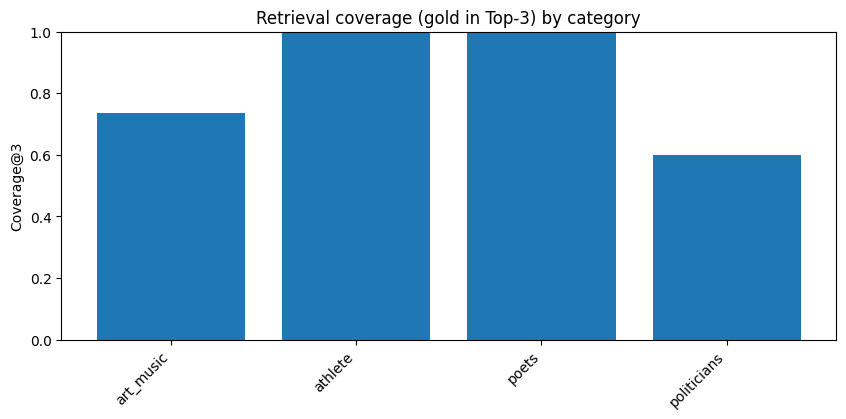

Saved figure: G:\My Drive\NLP\project\rag_out\evaluation\fig_coverage_by_category.png


In [80]:
fig = plt.figure(figsize=(10,4))
plt.bar(range(len(aggregated_by_category)), aggregated_by_category["Coverage@3"])
plt.xticks(range(len(aggregated_by_category)), aggregated_by_category["category"], rotation=45, ha="right")
plt.ylim(0,1)
plt.ylabel("Coverage@3")
plt.title("Retrieval coverage (gold in Top-3) by category")
save_show(fig, "fig_coverage_by_category.png")

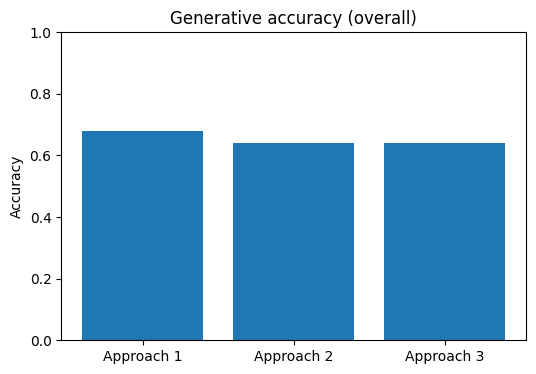

Saved figure: G:\My Drive\NLP\project\rag_out\evaluation\fig_accuracy_overall.png


In [75]:
fig = plt.figure(figsize=(6,4))
plt.bar([0,1,2], [G["acc1"].mean(), G["acc2"].mean(), G["acc3"].mean()])
plt.xticks([0,1,2], ["Approach 1","Approach 2","Approach 3"])
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Generative accuracy (overall)")
save_show(fig, "fig_accuracy_overall.png")

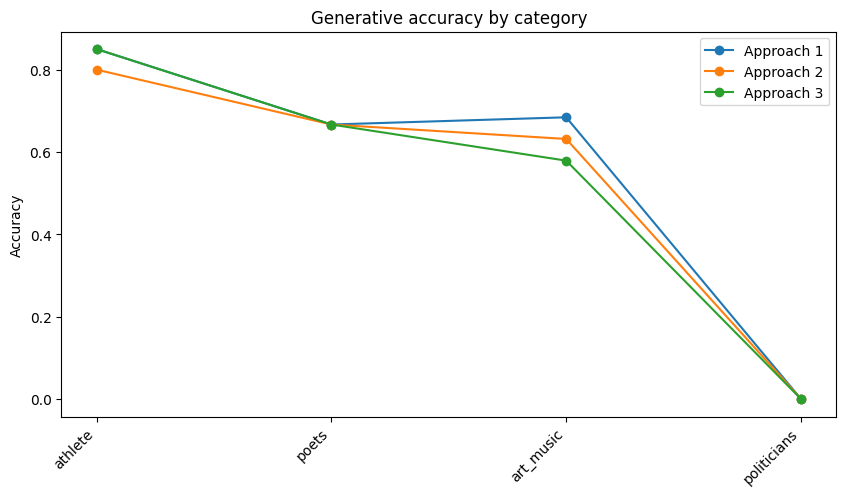

Saved figure: G:\My Drive\NLP\project\rag_out\evaluation\fig_generative_by_category.png


In [79]:
fig = plt.figure(figsize=(10,5))
x = range(len(generative_by_category))
plt.plot(x, generative_by_category["Approach1_Acc"], marker="o", label="Approach 1")
plt.plot(x, generative_by_category["Approach2_Acc"], marker="o", label="Approach 2")
plt.plot(x, generative_by_category["Approach3_Acc"], marker="o", label="Approach 3")
plt.xticks(list(x), generative_by_category["category"], rotation=45, ha="right")
plt.ylabel("Accuracy")
plt.title("Generative accuracy by category")
plt.legend()
save_show(fig, "fig_generative_by_category.png")

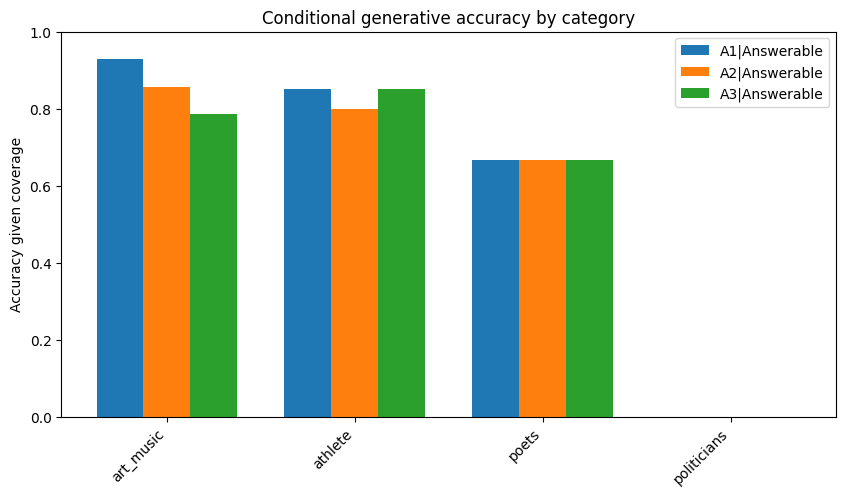

Saved figure: G:\My Drive\NLP\project\rag_out\evaluation\fig_conditional_accuracy_by_category.png


In [81]:
fig = plt.figure(figsize=(10,5))
x = np.arange(len(aggregated_by_category))
w = 0.25
plt.bar(x - w, aggregated_by_category["A1|Answerable"], width=w, label="A1|Answerable")
plt.bar(x,       aggregated_by_category["A2|Answerable"], width=w, label="A2|Answerable")
plt.bar(x + w,   aggregated_by_category["A3|Answerable"], width=w, label="A3|Answerable")
plt.xticks(x, aggregated_by_category["category"], rotation=45, ha="right")
plt.ylim(0,1)
plt.ylabel("Accuracy given coverage")
plt.title("Conditional generative accuracy by category")
plt.legend()
save_show(fig, "fig_conditional_accuracy_by_category.png")

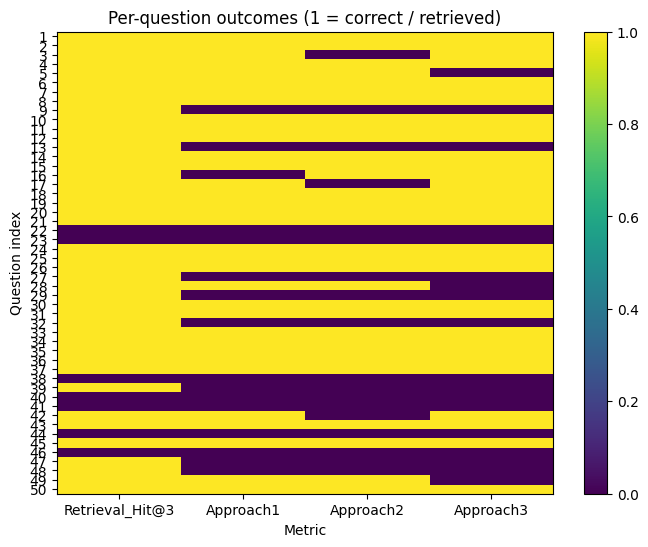

Saved figure: G:\My Drive\NLP\project\rag_out\evaluation\fig_per_question_matrix.png


In [74]:
M = pd.DataFrame({
    "Retrieval_Hit@3": (R["ret_rank"] > 0).astype(int).values,
    "Approach1": G["acc1"].astype(int).values,
    "Approach2": G["acc2"].astype(int).values,
    "Approach3": G["acc3"].astype(int).values,
})
fig = plt.figure(figsize=(8, max(3, len(M)*0.12)))
plt.imshow(M.values, aspect="auto")
plt.yticks(range(len(M)), [f"{i+1}" for i in range(len(M))])
plt.xticks(range(M.shape[1]), list(M.columns), rotation=0)
plt.title("Per-question outcomes (1 = correct / retrieved)")
plt.xlabel("Metric")
plt.ylabel("Question index")
plt.colorbar()
save_show(fig, "fig_per_question_matrix.png")

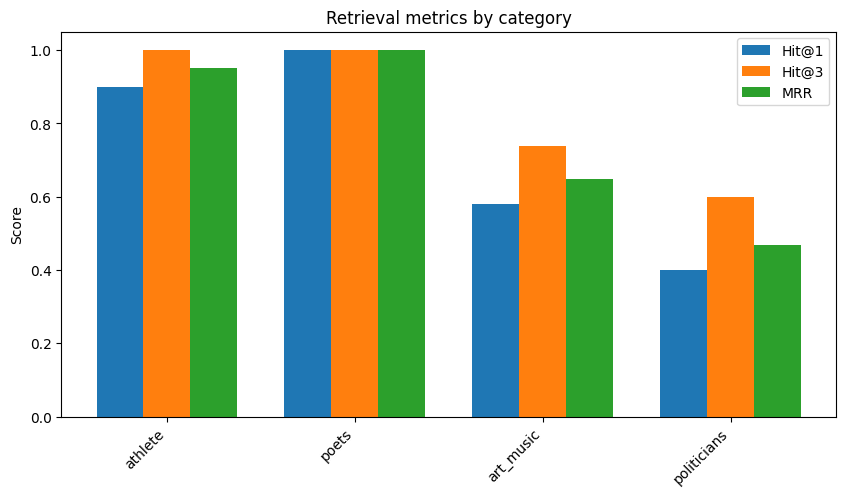

Saved figure: G:\My Drive\NLP\project\rag_out\evaluation\fig_retrieval_by_category.png


In [78]:
fig = plt.figure(figsize=(10,5))
x = np.arange(len(retrieval_by_category))
w = 0.25
plt.bar(x - w, retrieval_by_category["Hit@1"], width=w, label="Hit@1")
plt.bar(x,       retrieval_by_category["Hit@3"], width=w, label="Hit@3")
plt.bar(x + w,   retrieval_by_category["MRR"],   width=w, label="MRR")
plt.xticks(x, retrieval_by_category["category"], rotation=45, ha="right")
plt.ylabel("Score")
plt.title("Retrieval metrics by category")
plt.legend()
save_show(fig, "fig_retrieval_by_category.png")

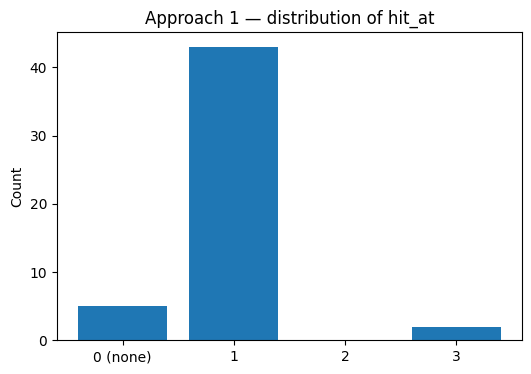

Saved figure: G:\My Drive\NLP\project\rag_out\evaluation\fig_a1_hit_at_dist.png


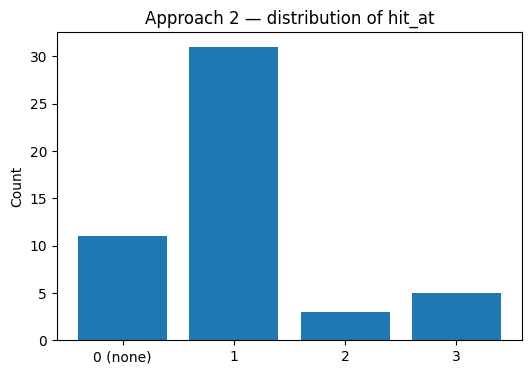

Saved figure: G:\My Drive\NLP\project\rag_out\evaluation\fig_a2_hit_at_dist.png


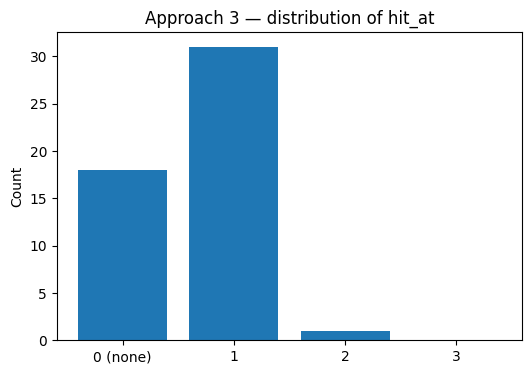

Saved figure: G:\My Drive\NLP\project\rag_out\evaluation\fig_a3_hit_at_dist.png


In [82]:
def hist_hit_at(series, title, filename):
    counts = pd.Series(series).value_counts().reindex([0,1,2,3], fill_value=0)
    fig = plt.figure(figsize=(6,4))
    plt.bar([0,1,2,3], counts.values)
    plt.xticks([0,1,2,3], ["0 (none)","1","2","3"])
    plt.ylabel("Count")
    plt.title(title)
    save_show(fig, filename)

hist_hit_at(G["g1_hit_at"], "Approach 1 — distribution of hit_at", "fig_a1_hit_at_dist.png")
hist_hit_at(G["g2_hit_at"], "Approach 2 — distribution of hit_at", "fig_a2_hit_at_dist.png")
hist_hit_at(G["g3_hit_at"], "Approach 3 — distribution of hit_at", "fig_a3_hit_at_dist.png")

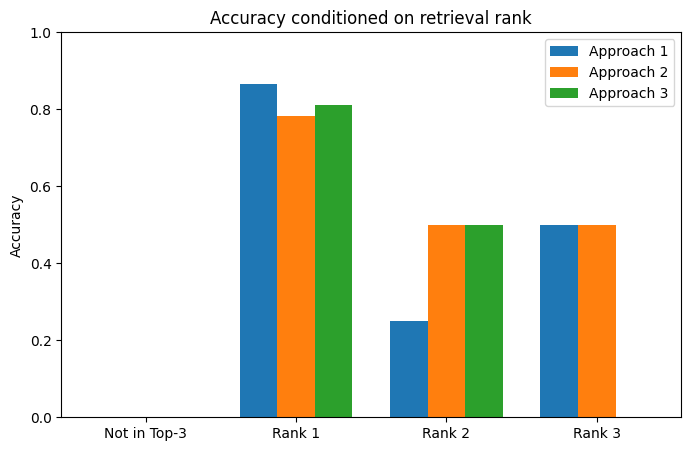

Saved figure: G:\My Drive\NLP\project\rag_out\evaluation\fig_accuracy_by_retrieval_rank.png


In [83]:
rank_groups = G.copy()
rank_groups["rank_bucket"] = R["ret_rank"]  # 0..3
def acc_by_rank(col):
    return rank_groups.groupby("rank_bucket")[col].mean().reindex([0,1,2,3], fill_value=np.nan)

a1r = acc_by_rank("acc1"); a2r = acc_by_rank("acc2"); a3r = acc_by_rank("acc3")
fig = plt.figure(figsize=(8,5))
x = np.arange(4)
w = 0.25
plt.bar(x - w, a1r.values, width=w, label="Approach 1")
plt.bar(x,       a2r.values, width=w, label="Approach 2")
plt.bar(x + w,   a3r.values, width=w, label="Approach 3")
plt.xticks(x, ["Not in Top-3","Rank 1","Rank 2","Rank 3"], rotation=0)
plt.ylim(0,1)
plt.ylabel("Accuracy")
plt.title("Accuracy conditioned on retrieval rank")
plt.legend()
save_show(fig, "fig_accuracy_by_retrieval_rank.png")